In [1]:
import sys
sys.path.insert(0, '/home/student.unimelb.edu.au/shorte1/Documents/TINT')

import sys
sys.path.insert(0, '/home/563/esh563/TINT')

# Core
import datetime
import os
import glob
import tempfile
import pickle
import copy

# Analysis
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams

# Debugging
import pdb, traceback
# %load_ext line_profiler

# Radar Tools
import pyart
import tint
# import tint.animate
# from tint.visualisation import animate

import CPOL_func as cf
import classification as cl
import caine_func as caf
import analysis
import boring_stats_AURA as bs
import two_dimensional_analysis as td

# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport CPOL_func
%aimport caine_func
%aimport classification
%aimport tint.visualisation.figures
%aimport tint.visualisation.animate
%aimport tint.visualisation.horizontal_helpers
%aimport tint.visualisation.vertical_helpers
%aimport tint.tracks
%aimport tint.objects
%aimport tint.grid_utils
%aimport tint.steiner
%aimport tint.matching
%aimport tint.rain
%aimport tint.cells
%aimport tint.tracks_helpers
%aimport tint.process_ERA5
%aimport tint.process_WRF
%aimport boring_stats_AURA
%aimport two_dimensional_analysis

%pdb

base_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/CPOL/'
save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/ACCESS_radar_lower_wind_level/'
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/ACCESS_radar_lower_wind_level/'
ERA5_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/era5/'
ERA5_dir += 'pressure-levels/reanalysis/'
WRF_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/caine_WRF_data/'


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/graphml.py:346: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (np.int, "int"), (np.int8, "int"),
/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/gexf.py:220: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to us

Automatic pdb calling has been turned ON


In [2]:
test_names = [
    'base', 'ambient_swapped', 'ambient_swapped_lower_wind_level', 
    'lower_wind_level', 'higher_wind_level',
    'no_steiner', 'lower_ref_thresh',
    'higher_offset_thresh', 'higher_border_thresh',
    'higher_area_thresh', 'higher_conv_area_thresh', 'linear_50', 'linear_25', 
    'combined_sensitivity']

In [6]:
class_thresh_base = {
    'OFFSET_MAG': 10000,  # metres
    'SHEAR_MAG': 2,  # m/s
    'VEL_MAG': 5,  # m/s
    'REL_VEL_MAG': 2,  # m/s
    'ANGLE_BUFFER': 10}

excl_thresh_base = {
    'SMALL_AREA': 500,  # km^2
    'LARGE_AREA': 50000,  # km^2
    'BORD_THRESH': 0.001,  # Ratio border pixels to total pixels
    'MAJOR_AXIS_LENGTH': 25,  # km
    'AXIS_RATIO': 2,
    'DURATION': 30}  # minutes

test_names = [
    'base', 'ambient_swapped', 'ambient_swapped_lower_wind_level', 
    'lower_wind_level', 'higher_wind_level', 'no_steiner', 
    'lower_ref_thresh', 'higher_offset_thresh', 'higher_border_thresh',
    'higher_area_thresh', 'higher_conv_area_thresh', 'linear_50', 
    'linear_25', 'combined_sensitivity']

tracks_dir = [
    'base', 'ambient_swapped', 'ambient_swapped_lower_wind_level',
    'lower_wind_level', 'higher_wind_level', 'no_steiner', 
    'lower_ref_thresh', 'base', 'base',
    'base', 'base', 'base',
    'base', 'base']

[
    class_thresh_SO15] = [
    copy.deepcopy(class_thresh_base) for i in range(1)]

class_thresh_SO15['OFFSET_MAG'] = 15000

class_thresh_comb = {
    'OFFSET_MAG': 12500,
    'SHEAR_MAG': 3,
    'VEL_MAG': 5,
    'REL_VEL_MAG': 3,
    'ANGLE_BUFFER': 15}

class_threshes = [
    None, None, None, 
    None, None, None,
    None, class_thresh_SO15, None, 
    None, None, None, 
    None, class_thresh_comb]

[
    excl_thresh_B05, excl_thresh_A2000, excl_thresh_CA240,
    excl_thresh_L50, excl_thresh_L25] = [
    copy.deepcopy(excl_thresh_base) for i in range(5)]

excl_thresh_B05['BORD_THRESH'] = 0.0005
excl_thresh_A2000['SMALL_AREA'] = 2000
excl_thresh_CA240['SMALL_AREA'] = 240
excl_thresh_L50['MAJOR_AXIS_LENGTH'] = 50
excl_thresh_L25['MAJOR_AXIS_LENGTH'] = 25

excl_thresh_comb = {
    'SMALL_AREA': 2000,
    'LARGE_AREA': 50000,
    'BORD_THRESH': 0.001,
    'MAJOR_AXIS_LENGTH': 25,
    'AXIS_RATIO': 2,
    'DURATION': 30}

# test_names = [
#     'base', 'ambient_swapped', 'ambient_swapped_lower_wind_level', 
#     'lower_wind_level', 'higher_wind_level', 'no_steiner', 
#     'lower_ref_thresh', 'higher_offset_thresh', 'higher_border_thresh',
#     'higher_area_thresh', 'higher_conv_area_thresh', 'linear_50', 
#     'linear_25', 'combined_sensitivity']

excl_threshes = [
    None, None, None, 
    None, None, None,
    None, None, excl_thresh_B05, 
    excl_thresh_A2000, excl_thresh_CA240, excl_thresh_L50, 
    excl_thresh_L25, excl_thresh_comb]

non_linear_conds = [
    False, False, False, 
    False, False, False, 
    False, False, False, 
    False, False, True, 
    True, False]

# Define the restricted samples
exclusion_lists = [
    [
        'small_area', 'large_area', 'intersect_border',
        'intersect_border_convective', 'duration_cond',
        'small_velocity', 'small_offset'] for i in range(14)]

exclusion_lists[10] += ['small_conv_area']
exclusion_lists[11] += ['non_linear']
exclusion_lists[12] += ['non_linear']

In [115]:
path = save_dir + 'radar_{}/{}/{:02}_{}_{:02}.pkl'.format(
    63, 2013, 63, 2013, 12)

with open(path, 'rb') as f:
    tracks_obj = pickle.load(f)

In [117]:
tracks_obj.params

{'SEARCH_MARGIN': 50000,
 'FLOW_MARGIN': 40000,
 'MAX_FLOW_MAG': 60,
 'MAX_DISPARITY': 999,
 'MAX_SHIFT_DISP': 60,
 'MAX_SHIFT_DISP_ALT': 25,
 'ISO_SMOOTH': 3,
 'GS_ALT': 1500,
 'LEVELS': array([[  500,  3500],
        [ 3500,  7500],
        [ 7500, 10000]]),
 'WIND_LEVELS': array([[  500,  3500],
        [ 3500,  7500],
        [ 7500, 10000]]),
 'MIN_SIZE': [80, 400, 800],
 'FIELD_THRESH': ['convective', 20, 15],
 'ISO_THRESH': [10, 10, 10],
 'TRACK_INTERVAL': 0,
 'CELL_THRESH': 25,
 'CELL_START': 3000,
 'RAIN': False,
 'SAVE_RAIN': False,
 'AMBIENT': 'ERA5',
 'AMBIENT_BASE_DIR': '/g/data/w40/esh563/era5/pressure-levels/reanalysis/',
 'DT': 10,
 'CLASS_THRESH': {'OFFSET_MAG': 10000,
  'SHEAR_MAG': 2,
  'VEL_MAG': 5,
  'REL_VEL_MAG': 2,
  'ANGLE_BUFFER': 10},
 'EXCL_THRESH': {'SMALL_AREA': 500,
  'LARGE_AREA': 50000,
  'BORD_THRESH': 0.001,
  'MAJOR_AXIS_LENGTH': 100,
  'AXIS_RATIO': 3,
  'DURATION': 30},
 'INPUT_TYPE': 'OPER_DATETIMES',
 'REMOTE': True,
 'AMBIENT_TIMESTEP': 1,
 'SAV

In [4]:
exclusion_lists[0]

['small_area',
 'large_area',
 'intersect_border',
 'intersect_border_convective',
 'duration_cond',
 'small_velocity',
 'small_offset']

# Generate Figures

In [2]:
# for i in range(len(tracks_dir)):

save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/national/'
save_dir_alt = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/national/'
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/national/'
suff = fig_dir.split('/')[-2][13:]

In [3]:
if not os.path.exists(save_dir_alt):
    os.makedirs(save_dir)
    print('Creating new directory.')

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print('Creating new directory.')

In [4]:
radars = [
    2, 3, 4, 5, 6, 8, 9, 14, 16, 17, 19, 22, 23, 24, 25, 27, 28, 29, 31, 32, 
    33, 36, 37, 40, 41, 42, 44, 46, 48, 49, 50, 52, 53, 54, 55, 56, 63, 64, 
    66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77]

In [7]:
all_radar = bs.get_all_and_QC_radar_stats(
    save_dir, class_thresh=None,
    excl_thresh=None, exclusions=exclusion_lists[0], radars=radars)

Radar 2, year 2012, month 1.
Calculating system tracks.
Radar 2, year 2012, month 2.
Calculating system tracks.
Radar 2, year 2012, month 3.
Calculating system tracks.
Radar 2, year 2012, month 4.
Calculating system tracks.
Radar 2, year 2012, month 5.
Calculating system tracks.
No included observations.
Radar 2, year 2012, month 6.
Calculating system tracks.
Radar 2, year 2012, month 7.
Radar 2, year 2012, month 8.
Radar 2, year 2012, month 9.
Calculating system tracks.
Radar 2, year 2012, month 10.
Radar 2, year 2012, month 11.
Calculating system tracks.
Radar 2, year 2012, month 12.
Calculating system tracks.
Radar 2, year 2013, month 1.
Calculating system tracks.
Radar 2, year 2013, month 2.
Calculating system tracks.
Radar 2, year 2013, month 3.
Calculating system tracks.
Radar 2, year 2013, month 4.
Radar 2, year 2013, month 5.
Radar 2, year 2013, month 6.
Radar 2, year 2013, month 7.
Calculating system tracks.
Radar 2, year 2013, month 8.
Calculating system tracks.
Radar 2, year

Radar 3, year 2013, month 11.
Calculating system tracks.
Radar 3, year 2013, month 12.
Calculating system tracks.
Radar 3, year 2014, month 1.
Calculating system tracks.
No included observations.
Radar 3, year 2014, month 2.
Calculating system tracks.
Radar 3, year 2014, month 3.
Calculating system tracks.
Radar 3, year 2014, month 4.
Calculating system tracks.
Radar 3, year 2014, month 5.
Calculating system tracks.
Radar 3, year 2014, month 6.
Calculating system tracks.
Radar 3, year 2014, month 7.
Calculating system tracks.
Radar 3, year 2014, month 8.
Calculating system tracks.
Radar 3, year 2014, month 9.
Calculating system tracks.
Radar 3, year 2014, month 10.
Calculating system tracks.
Radar 3, year 2014, month 11.
Calculating system tracks.
Radar 3, year 2014, month 12.
Calculating system tracks.
Radar 3, year 2015, month 1.
Calculating system tracks.
Radar 3, year 2015, month 2.
Calculating system tracks.
Radar 3, year 2015, month 3.
Calculating system tracks.
Radar 3, year 201

Radar 4, year 2015, month 1.
Calculating system tracks.
Radar 4, year 2015, month 2.
Calculating system tracks.
Radar 4, year 2015, month 3.
Calculating system tracks.
Radar 4, year 2015, month 4.
Calculating system tracks.
Radar 4, year 2015, month 5.
Calculating system tracks.
Radar 4, year 2015, month 6.
Calculating system tracks.
Radar 4, year 2015, month 7.
Calculating system tracks.
Radar 4, year 2015, month 8.
Calculating system tracks.
Radar 4, year 2015, month 9.
Calculating system tracks.
Radar 4, year 2015, month 10.
Calculating system tracks.
Radar 4, year 2015, month 11.
Calculating system tracks.
Radar 4, year 2015, month 12.
Calculating system tracks.
Radar 4, year 2016, month 1.
Calculating system tracks.
Radar 4, year 2016, month 2.
Calculating system tracks.
Radar 4, year 2016, month 3.
Calculating system tracks.
Radar 4, year 2016, month 4.
Calculating system tracks.
Radar 4, year 2016, month 5.
Calculating system tracks.
No included observations.
Radar 4, year 2016,

Radar 5, year 2016, month 12.
Calculating system tracks.
Radar 5, year 2017, month 1.
Calculating system tracks.
Radar 5, year 2017, month 2.
Calculating system tracks.
Radar 5, year 2017, month 3.
Calculating system tracks.
Radar 5, year 2017, month 4.
Calculating system tracks.
Radar 5, year 2017, month 5.
Radar 5, year 2017, month 6.
Calculating system tracks.
Radar 5, year 2017, month 7.
Radar 5, year 2017, month 8.
Calculating system tracks.
Radar 5, year 2017, month 9.
Calculating system tracks.
Radar 5, year 2017, month 10.
Calculating system tracks.
Radar 5, year 2017, month 11.
Calculating system tracks.
Radar 5, year 2017, month 12.
Calculating system tracks.
Radar 5, year 2018, month 1.
Calculating system tracks.
Radar 5, year 2018, month 2.
Calculating system tracks.
Radar 5, year 2018, month 3.
Calculating system tracks.
Radar 5, year 2018, month 4.
Calculating system tracks.
Radar 5, year 2018, month 5.
Calculating system tracks.
Radar 5, year 2018, month 6.
Calculating s

Radar 6, year 2018, month 3.
Calculating system tracks.
Radar 6, year 2018, month 4.
Calculating system tracks.
Radar 6, year 2018, month 5.
Calculating system tracks.
Radar 6, year 2018, month 6.
Calculating system tracks.
Radar 6, year 2018, month 7.
Calculating system tracks.
Radar 6, year 2018, month 8.
Radar 6, year 2018, month 9.
Calculating system tracks.
Radar 6, year 2018, month 10.
Calculating system tracks.
No included observations.
Radar 6, year 2018, month 11.
Calculating system tracks.
Radar 6, year 2018, month 12.
Calculating system tracks.
Radar 6, year 2019, month 1.
Calculating system tracks.
Radar 6, year 2019, month 2.
Calculating system tracks.
Radar 6, year 2019, month 3.
Calculating system tracks.
Radar 6, year 2019, month 4.
Missing file: skipping.
Radar 6, year 2019, month 5.
Missing file: skipping.
Radar 6, year 2019, month 6.
Calculating system tracks.
Radar 6, year 2019, month 7.
Calculating system tracks.
Radar 6, year 2019, month 8.
Calculating system trac

Radar 8, year 2020, month 2.
Calculating system tracks.
Radar 8, year 2020, month 3.
Calculating system tracks.
Radar 8, year 2020, month 4.
Calculating system tracks.
Radar 8, year 2020, month 5.
Radar 8, year 2020, month 6.
Calculating system tracks.
Radar 8, year 2020, month 7.
Calculating system tracks.
Radar 8, year 2020, month 8.
Calculating system tracks.
Radar 8, year 2020, month 9.
Calculating system tracks.
Radar 8, year 2020, month 10.
Calculating system tracks.
Radar 8, year 2020, month 11.
Calculating system tracks.
Radar 8, year 2020, month 12.
Calculating system tracks.
Radar 8, year 2021, month 1.
Calculating system tracks.
Radar 8, year 2021, month 2.
Calculating system tracks.
Radar 8, year 2021, month 3.
Calculating system tracks.
Radar 8, year 2021, month 4.
Calculating system tracks.
Radar 8, year 2021, month 5.
Calculating system tracks.
Radar 8, year 2021, month 6.
Calculating system tracks.
Radar 8, year 2021, month 7.
Calculating system tracks.
Radar 8, year 20

Radar 9, year 2022, month 2.
Calculating system tracks.
Radar 9, year 2022, month 3.
Calculating system tracks.
Radar 9, year 2022, month 4.
Calculating system tracks.
Radar 9, year 2022, month 5.
Calculating system tracks.
Radar 9, year 2022, month 6.
Calculating system tracks.
Radar 9, year 2022, month 7.
Radar 9, year 2022, month 8.
Radar 9, year 2022, month 9.
Calculating system tracks.
Radar 9, year 2022, month 10.
Calculating system tracks.
Radar 9, year 2022, month 11.
Calculating system tracks.
Radar 9, year 2022, month 12.
Calculating system tracks.
Radar 14, year 2012, month 1.
Calculating system tracks.
Radar 14, year 2012, month 2.
Calculating system tracks.
Radar 14, year 2012, month 3.
Calculating system tracks.
Radar 14, year 2012, month 4.
Calculating system tracks.
Radar 14, year 2012, month 5.
Calculating system tracks.
Radar 14, year 2012, month 6.
Calculating system tracks.
Radar 14, year 2012, month 7.
Calculating system tracks.
Radar 14, year 2012, month 8.
Calcul

Radar 16, year 2012, month 2.
Calculating system tracks.
Radar 16, year 2012, month 3.
Calculating system tracks.
Radar 16, year 2012, month 4.
Calculating system tracks.
Radar 16, year 2012, month 5.
Calculating system tracks.
Radar 16, year 2012, month 6.
Calculating system tracks.
Radar 16, year 2012, month 7.
Radar 16, year 2012, month 8.
Calculating system tracks.
Radar 16, year 2012, month 9.
Calculating system tracks.
Radar 16, year 2012, month 10.
Calculating system tracks.
Radar 16, year 2012, month 11.
Calculating system tracks.
Radar 16, year 2012, month 12.
Calculating system tracks.
Radar 16, year 2013, month 1.
Calculating system tracks.
Radar 16, year 2013, month 2.
Calculating system tracks.
Radar 16, year 2013, month 3.
Calculating system tracks.
Radar 16, year 2013, month 4.
Calculating system tracks.
Radar 16, year 2013, month 5.
Calculating system tracks.
Radar 16, year 2013, month 6.
Calculating system tracks.
Radar 16, year 2013, month 7.
Radar 16, year 2013, mont

Radar 17, year 2013, month 4.
Calculating system tracks.
Radar 17, year 2013, month 5.
Calculating system tracks.
Radar 17, year 2013, month 6.
Calculating system tracks.
Radar 17, year 2013, month 7.
Calculating system tracks.
Radar 17, year 2013, month 8.
Calculating system tracks.
Radar 17, year 2013, month 9.
Calculating system tracks.
Radar 17, year 2013, month 10.
Calculating system tracks.
Radar 17, year 2013, month 11.
Calculating system tracks.
Radar 17, year 2013, month 12.
Calculating system tracks.
Radar 17, year 2014, month 1.
Calculating system tracks.
Radar 17, year 2014, month 2.
Calculating system tracks.
Radar 17, year 2014, month 3.
Calculating system tracks.
Radar 17, year 2014, month 4.
Calculating system tracks.
Radar 17, year 2014, month 5.
Calculating system tracks.
Radar 17, year 2014, month 6.
Radar 17, year 2014, month 7.
Calculating system tracks.
Radar 17, year 2014, month 8.
Calculating system tracks.
Radar 17, year 2014, month 9.
Calculating system tracks

Radar 19, year 2015, month 12.
Calculating system tracks.
No included observations.
Radar 19, year 2016, month 1.
Calculating system tracks.
No included observations.
Radar 19, year 2016, month 2.
Calculating system tracks.
Radar 19, year 2016, month 3.
Calculating system tracks.
Radar 19, year 2016, month 4.
Calculating system tracks.
Radar 19, year 2016, month 5.
Calculating system tracks.
Radar 19, year 2016, month 6.
Radar 19, year 2016, month 7.
Calculating system tracks.
Radar 19, year 2016, month 8.
Radar 19, year 2016, month 9.
Radar 19, year 2016, month 10.
Radar 19, year 2016, month 11.
Calculating system tracks.
Radar 19, year 2016, month 12.
Calculating system tracks.
Radar 19, year 2017, month 1.
Calculating system tracks.
Radar 19, year 2017, month 2.
Calculating system tracks.
Radar 19, year 2017, month 3.
Calculating system tracks.
Radar 19, year 2017, month 4.
Calculating system tracks.
Radar 19, year 2017, month 5.
Calculating system tracks.
Radar 19, year 2017, month

Radar 22, year 2018, month 5.
Radar 22, year 2018, month 6.
Radar 22, year 2018, month 7.
Radar 22, year 2018, month 8.
Radar 22, year 2018, month 9.
Radar 22, year 2018, month 10.
Calculating system tracks.
Radar 22, year 2018, month 11.
Calculating system tracks.
Radar 22, year 2018, month 12.
Calculating system tracks.
Radar 22, year 2019, month 1.
Calculating system tracks.
Radar 22, year 2019, month 2.
Calculating system tracks.
Radar 22, year 2019, month 3.
Calculating system tracks.
Radar 22, year 2019, month 4.
Calculating system tracks.
Radar 22, year 2019, month 5.
Radar 22, year 2019, month 6.
Radar 22, year 2019, month 7.
Calculating system tracks.
Radar 22, year 2019, month 8.
Radar 22, year 2019, month 9.
Radar 22, year 2019, month 10.
Calculating system tracks.
Radar 22, year 2019, month 11.
Calculating system tracks.
No included observations.
Radar 22, year 2019, month 12.
Calculating system tracks.
Radar 22, year 2020, month 1.
Calculating system tracks.
Radar 22, year

Calculating system tracks.
Radar 23, year 2020, month 2.
Calculating system tracks.
Radar 23, year 2020, month 3.
Calculating system tracks.
Radar 23, year 2020, month 4.
Calculating system tracks.
Radar 23, year 2020, month 5.
Calculating system tracks.
Radar 23, year 2020, month 6.
Calculating system tracks.
Radar 23, year 2020, month 7.
Calculating system tracks.
Radar 23, year 2020, month 8.
Calculating system tracks.
Radar 23, year 2020, month 9.
Calculating system tracks.
Radar 23, year 2020, month 10.
Calculating system tracks.
Radar 23, year 2020, month 11.
Calculating system tracks.
Radar 23, year 2020, month 12.
Calculating system tracks.
Radar 23, year 2021, month 1.
Calculating system tracks.
Radar 23, year 2021, month 2.
Calculating system tracks.
Radar 23, year 2021, month 3.
Calculating system tracks.
Radar 23, year 2021, month 4.
Calculating system tracks.
Radar 23, year 2021, month 5.
Calculating system tracks.
Radar 23, year 2021, month 6.
Calculating system tracks.
R

Radar 24, year 2022, month 5.
Calculating system tracks.
Radar 24, year 2022, month 6.
Calculating system tracks.
Radar 24, year 2022, month 7.
Calculating system tracks.
Radar 24, year 2022, month 8.
Radar 24, year 2022, month 9.
Calculating system tracks.
Radar 24, year 2022, month 10.
Calculating system tracks.
Radar 24, year 2022, month 11.
Calculating system tracks.
Radar 24, year 2022, month 12.
Calculating system tracks.
Radar 25, year 2012, month 1.
Calculating system tracks.
Radar 25, year 2012, month 2.
Calculating system tracks.
Radar 25, year 2012, month 3.
Radar 25, year 2012, month 4.
Calculating system tracks.
No included observations.
Radar 25, year 2012, month 5.
Radar 25, year 2012, month 6.
Radar 25, year 2012, month 7.
Radar 25, year 2012, month 8.
Radar 25, year 2012, month 9.
Calculating system tracks.
Radar 25, year 2012, month 10.
Radar 25, year 2012, month 11.
Calculating system tracks.
Radar 25, year 2012, month 12.
Calculating system tracks.
Radar 25, year 20

Radar 27, year 2014, month 10.
Calculating system tracks.
Radar 27, year 2014, month 11.
Calculating system tracks.
Radar 27, year 2014, month 12.
Calculating system tracks.
Radar 27, year 2015, month 1.
Calculating system tracks.
Radar 27, year 2015, month 2.
Calculating system tracks.
Radar 27, year 2015, month 3.
Calculating system tracks.
Radar 27, year 2015, month 4.
Calculating system tracks.
Radar 27, year 2015, month 5.
Calculating system tracks.
Radar 27, year 2015, month 6.
Calculating system tracks.
Radar 27, year 2015, month 7.
Calculating system tracks.
Radar 27, year 2015, month 8.
Calculating system tracks.
Radar 27, year 2015, month 9.
Calculating system tracks.
Radar 27, year 2015, month 10.
Calculating system tracks.
Radar 27, year 2015, month 11.
Calculating system tracks.
Radar 27, year 2015, month 12.
Calculating system tracks.
Radar 27, year 2016, month 1.
Calculating system tracks.
Radar 27, year 2016, month 2.
Calculating system tracks.
Radar 27, year 2016, mont

Radar 28, year 2015, month 10.
Calculating system tracks.
Radar 28, year 2015, month 11.
Calculating system tracks.
Radar 28, year 2015, month 12.
Calculating system tracks.
Radar 28, year 2016, month 1.
Calculating system tracks.
Radar 28, year 2016, month 2.
Calculating system tracks.
Radar 28, year 2016, month 3.
Calculating system tracks.
Radar 28, year 2016, month 4.
Calculating system tracks.
Radar 28, year 2016, month 5.
Calculating system tracks.
Radar 28, year 2016, month 6.
Calculating system tracks.
Radar 28, year 2016, month 7.
Calculating system tracks.
Radar 28, year 2016, month 8.
Calculating system tracks.
Radar 28, year 2016, month 9.
Calculating system tracks.
Radar 28, year 2016, month 10.
Calculating system tracks.
Radar 28, year 2016, month 11.
Calculating system tracks.
Radar 28, year 2016, month 12.
Calculating system tracks.
Radar 28, year 2017, month 1.
Calculating system tracks.
Radar 28, year 2017, month 2.
Calculating system tracks.
Radar 28, year 2017, mont

Radar 29, year 2017, month 1.
Calculating system tracks.
Radar 29, year 2017, month 2.
Calculating system tracks.
Radar 29, year 2017, month 3.
Calculating system tracks.
Radar 29, year 2017, month 4.
Calculating system tracks.
Radar 29, year 2017, month 5.
Calculating system tracks.
Radar 29, year 2017, month 6.
Radar 29, year 2017, month 7.
Radar 29, year 2017, month 8.
Radar 29, year 2017, month 9.
Calculating system tracks.
Radar 29, year 2017, month 10.
Calculating system tracks.
Radar 29, year 2017, month 11.
Calculating system tracks.
Radar 29, year 2017, month 12.
Calculating system tracks.
Radar 29, year 2018, month 1.
Calculating system tracks.
Radar 29, year 2018, month 2.
Calculating system tracks.
Radar 29, year 2018, month 3.
Calculating system tracks.
Radar 29, year 2018, month 4.
Calculating system tracks.
Radar 29, year 2018, month 5.
Calculating system tracks.
Radar 29, year 2018, month 6.
Calculating system tracks.
Radar 29, year 2018, month 7.
Radar 29, year 2018, m

Radar 31, year 2020, month 5.
Calculating system tracks.
Radar 31, year 2020, month 6.
Calculating system tracks.
Radar 31, year 2020, month 7.
Calculating system tracks.
Radar 31, year 2020, month 8.
Calculating system tracks.
Radar 31, year 2020, month 9.
Calculating system tracks.
Radar 31, year 2020, month 10.
Calculating system tracks.
Radar 31, year 2020, month 11.
Calculating system tracks.
Radar 31, year 2020, month 12.
Calculating system tracks.
Radar 31, year 2021, month 1.
Calculating system tracks.
Radar 31, year 2021, month 2.
Calculating system tracks.
Radar 31, year 2021, month 3.
Calculating system tracks.
Radar 31, year 2021, month 4.
Calculating system tracks.
Radar 31, year 2021, month 5.
Calculating system tracks.
Radar 31, year 2021, month 6.
Calculating system tracks.
Radar 31, year 2021, month 7.
Calculating system tracks.
Radar 31, year 2021, month 8.
Calculating system tracks.
Radar 31, year 2021, month 9.
Calculating system tracks.
Radar 31, year 2021, month 1

Radar 32, year 2021, month 8.
Calculating system tracks.
No included observations.
Radar 32, year 2021, month 9.
Calculating system tracks.
Radar 32, year 2021, month 10.
Calculating system tracks.
Radar 32, year 2021, month 11.
Calculating system tracks.
Radar 32, year 2021, month 12.
Calculating system tracks.
Radar 32, year 2022, month 1.
Calculating system tracks.
Radar 32, year 2022, month 2.
Calculating system tracks.
Radar 32, year 2022, month 3.
Calculating system tracks.
Radar 32, year 2022, month 4.
Calculating system tracks.
Radar 32, year 2022, month 5.
Calculating system tracks.
Radar 32, year 2022, month 6.
Calculating system tracks.
Radar 32, year 2022, month 7.
Calculating system tracks.
Radar 32, year 2022, month 8.
Calculating system tracks.
Radar 32, year 2022, month 9.
Calculating system tracks.
Radar 32, year 2022, month 10.
Calculating system tracks.
Radar 32, year 2022, month 11.
Calculating system tracks.
Radar 32, year 2022, month 12.
Calculating system tracks.

Radar 36, year 2012, month 12.
Calculating system tracks.
Radar 36, year 2013, month 1.
Calculating system tracks.
Radar 36, year 2013, month 2.
Calculating system tracks.
Radar 36, year 2013, month 3.
Calculating system tracks.
Radar 36, year 2013, month 4.
Calculating system tracks.
Radar 36, year 2013, month 5.
Calculating system tracks.
Radar 36, year 2013, month 6.
Radar 36, year 2013, month 7.
Radar 36, year 2013, month 8.
Radar 36, year 2013, month 9.
Radar 36, year 2013, month 10.
Calculating system tracks.
Radar 36, year 2013, month 11.
Calculating system tracks.
Radar 36, year 2013, month 12.
Calculating system tracks.
Radar 36, year 2014, month 1.
Calculating system tracks.
Radar 36, year 2014, month 2.
Calculating system tracks.
Radar 36, year 2014, month 3.
Calculating system tracks.
Radar 36, year 2014, month 4.
Calculating system tracks.
Radar 36, year 2014, month 5.
Radar 36, year 2014, month 6.
Calculating system tracks.
Radar 36, year 2014, month 7.
Radar 36, year 201

No included observations.
Radar 37, year 2019, month 12.
Calculating system tracks.
Radar 37, year 2020, month 1.
Calculating system tracks.
Radar 37, year 2020, month 2.
Calculating system tracks.
Radar 37, year 2020, month 3.
Calculating system tracks.
Radar 37, year 2020, month 4.
Calculating system tracks.
Radar 37, year 2020, month 5.
Radar 37, year 2020, month 6.
Calculating system tracks.
Radar 37, year 2020, month 7.
Radar 37, year 2020, month 8.
Radar 37, year 2020, month 9.
Radar 37, year 2020, month 10.
Radar 37, year 2020, month 11.
Calculating system tracks.
No included observations.
Radar 37, year 2020, month 12.
Radar 37, year 2021, month 1.
Calculating system tracks.
No included observations.
Radar 37, year 2021, month 2.
Calculating system tracks.
No included observations.
Radar 37, year 2021, month 3.
Calculating system tracks.
Radar 37, year 2021, month 4.
Radar 37, year 2021, month 5.
Radar 37, year 2021, month 6.
Radar 37, year 2021, month 7.
Calculating system tra

Radar 40, year 2021, month 6.
Calculating system tracks.
Radar 40, year 2021, month 7.
Calculating system tracks.
Radar 40, year 2021, month 8.
Calculating system tracks.
Radar 40, year 2021, month 9.
Calculating system tracks.
Radar 40, year 2021, month 10.
Calculating system tracks.
Radar 40, year 2021, month 11.
Calculating system tracks.
Radar 40, year 2021, month 12.
Calculating system tracks.
Radar 40, year 2022, month 1.
Calculating system tracks.
Radar 40, year 2022, month 2.
Calculating system tracks.
Radar 40, year 2022, month 3.
Calculating system tracks.
Radar 40, year 2022, month 4.
Calculating system tracks.
Radar 40, year 2022, month 5.
Calculating system tracks.
Radar 40, year 2022, month 6.
Calculating system tracks.
Radar 40, year 2022, month 7.
Calculating system tracks.
Radar 40, year 2022, month 8.
Calculating system tracks.
Radar 40, year 2022, month 9.
Calculating system tracks.
Radar 40, year 2022, month 10.
Calculating system tracks.
Radar 40, year 2022, month 

Radar 42, year 2013, month 6.
Radar 42, year 2013, month 7.
Radar 42, year 2013, month 8.
Radar 42, year 2013, month 9.
Calculating system tracks.
No included observations.
Radar 42, year 2013, month 10.
Calculating system tracks.
Radar 42, year 2013, month 11.
Calculating system tracks.
Radar 42, year 2013, month 12.
Calculating system tracks.
Radar 42, year 2014, month 1.
Calculating system tracks.
Radar 42, year 2014, month 2.
Calculating system tracks.
No included observations.
Radar 42, year 2014, month 3.
Calculating system tracks.
Radar 42, year 2014, month 4.
Calculating system tracks.
Radar 42, year 2014, month 5.
Calculating system tracks.
Radar 42, year 2014, month 6.
Radar 42, year 2014, month 7.
Radar 42, year 2014, month 8.
Radar 42, year 2014, month 9.
Radar 42, year 2014, month 10.
Calculating system tracks.
No included observations.
Radar 42, year 2014, month 11.
Calculating system tracks.
Radar 42, year 2014, month 12.
Calculating system tracks.
Radar 42, year 2015, m

Calculating system tracks.
Radar 44, year 2016, month 12.
Calculating system tracks.
Radar 44, year 2017, month 1.
Calculating system tracks.
Radar 44, year 2017, month 2.
Radar 44, year 2017, month 3.
Missing file: skipping.
Radar 44, year 2017, month 4.
Missing file: skipping.
Radar 44, year 2017, month 5.
Missing file: skipping.
Radar 44, year 2017, month 6.
Missing file: skipping.
Radar 44, year 2017, month 7.
Missing file: skipping.
Radar 44, year 2017, month 8.
Radar 44, year 2017, month 9.
Radar 44, year 2017, month 10.
Radar 44, year 2017, month 11.
Calculating system tracks.
No included observations.
Radar 44, year 2017, month 12.
Calculating system tracks.
No included observations.
Radar 44, year 2018, month 1.
Radar 44, year 2018, month 2.
Calculating system tracks.
Radar 44, year 2018, month 3.
Radar 44, year 2018, month 4.
Radar 44, year 2018, month 5.
Radar 44, year 2018, month 6.
Radar 44, year 2018, month 7.
Missing file: skipping.
Radar 44, year 2018, month 8.
Radar 44

Radar 46, year 2019, month 10.
Radar 46, year 2019, month 11.
Calculating system tracks.
Radar 46, year 2019, month 12.
Calculating system tracks.
Radar 46, year 2020, month 1.
Calculating system tracks.
Radar 46, year 2020, month 2.
Calculating system tracks.
Radar 46, year 2020, month 3.
Calculating system tracks.
Radar 46, year 2020, month 4.
Calculating system tracks.
Radar 46, year 2020, month 5.
Calculating system tracks.
Radar 46, year 2020, month 6.
Calculating system tracks.
No included observations.
Radar 46, year 2020, month 7.
Radar 46, year 2020, month 8.
Calculating system tracks.
No included observations.
Radar 46, year 2020, month 9.
Calculating system tracks.
Radar 46, year 2020, month 10.
Calculating system tracks.
Radar 46, year 2020, month 11.
Calculating system tracks.
Radar 46, year 2020, month 12.
Calculating system tracks.
Radar 46, year 2021, month 1.
Calculating system tracks.
Radar 46, year 2021, month 2.
Calculating system tracks.
Radar 46, year 2021, month 

Radar 48, year 2021, month 4.
Calculating system tracks.
Radar 48, year 2021, month 5.
Calculating system tracks.
Radar 48, year 2021, month 6.
Radar 48, year 2021, month 7.
Calculating system tracks.
Radar 48, year 2021, month 8.
Calculating system tracks.
Radar 48, year 2021, month 9.
Calculating system tracks.
No included observations.
Radar 48, year 2021, month 10.
Calculating system tracks.
Radar 48, year 2021, month 11.
Calculating system tracks.
Radar 48, year 2021, month 12.
Calculating system tracks.
Radar 48, year 2022, month 1.
Calculating system tracks.
Radar 48, year 2022, month 2.
Calculating system tracks.
Radar 48, year 2022, month 3.
Calculating system tracks.
Radar 48, year 2022, month 4.
Calculating system tracks.
Radar 48, year 2022, month 5.
Calculating system tracks.
Radar 48, year 2022, month 6.
Calculating system tracks.
Radar 48, year 2022, month 7.
Calculating system tracks.
Radar 48, year 2022, month 8.
Calculating system tracks.
Radar 48, year 2022, month 9.

Radar 50, year 2012, month 7.
Radar 50, year 2012, month 8.
Calculating system tracks.
Radar 50, year 2012, month 9.
Calculating system tracks.
Radar 50, year 2012, month 10.
Calculating system tracks.
Radar 50, year 2012, month 11.
Calculating system tracks.
Radar 50, year 2012, month 12.
Calculating system tracks.
Radar 50, year 2013, month 1.
Calculating system tracks.
Radar 50, year 2013, month 2.
Calculating system tracks.
Radar 50, year 2013, month 3.
Calculating system tracks.
Radar 50, year 2013, month 4.
Calculating system tracks.
Radar 50, year 2013, month 5.
Calculating system tracks.
Radar 50, year 2013, month 6.
Calculating system tracks.
Radar 50, year 2013, month 7.
Calculating system tracks.
Radar 50, year 2013, month 8.
Radar 50, year 2013, month 9.
Calculating system tracks.
Radar 50, year 2013, month 10.
Calculating system tracks.
Radar 50, year 2013, month 11.
Calculating system tracks.
Radar 50, year 2013, month 12.
Calculating system tracks.
Radar 50, year 2014, m

Radar 52, year 2015, month 8.
Radar 52, year 2015, month 9.
Radar 52, year 2015, month 10.
Radar 52, year 2015, month 11.
Radar 52, year 2015, month 12.
Radar 52, year 2016, month 1.
Calculating system tracks.
Radar 52, year 2016, month 2.
Radar 52, year 2016, month 3.
Missing file: skipping.
Radar 52, year 2016, month 4.
Radar 52, year 2016, month 5.
Calculating system tracks.
No included observations.
Radar 52, year 2016, month 6.
Radar 52, year 2016, month 7.
Calculating system tracks.
No included observations.
Radar 52, year 2016, month 8.
Radar 52, year 2016, month 9.
Radar 52, year 2016, month 10.
Radar 52, year 2016, month 11.
Calculating system tracks.
Radar 52, year 2016, month 12.
Calculating system tracks.
No included observations.
Radar 52, year 2017, month 1.
Calculating system tracks.
No included observations.
Radar 52, year 2017, month 2.
Calculating system tracks.
No included observations.
Radar 52, year 2017, month 3.
Calculating system tracks.
Radar 52, year 2017, mon

Radar 53, year 2018, month 2.
Calculating system tracks.
Radar 53, year 2018, month 3.
Radar 53, year 2018, month 4.
Calculating system tracks.
Radar 53, year 2018, month 5.
Radar 53, year 2018, month 6.
Radar 53, year 2018, month 7.
Radar 53, year 2018, month 8.
Radar 53, year 2018, month 9.
Radar 53, year 2018, month 10.
Calculating system tracks.
Radar 53, year 2018, month 11.
Calculating system tracks.
Radar 53, year 2018, month 12.
Calculating system tracks.
Radar 53, year 2019, month 1.
Calculating system tracks.
Radar 53, year 2019, month 2.
Calculating system tracks.
Radar 53, year 2019, month 3.
Calculating system tracks.
Radar 53, year 2019, month 4.
Radar 53, year 2019, month 5.
Calculating system tracks.
Radar 53, year 2019, month 6.
Radar 53, year 2019, month 7.
Radar 53, year 2019, month 8.
Radar 53, year 2019, month 9.
Radar 53, year 2019, month 10.
Calculating system tracks.
Radar 53, year 2019, month 11.
Calculating system tracks.
Radar 53, year 2019, month 12.
Calcula

Radar 54, year 2020, month 5.
Calculating system tracks.
Radar 54, year 2020, month 6.
Calculating system tracks.
Radar 54, year 2020, month 7.
Calculating system tracks.
Radar 54, year 2020, month 8.
Calculating system tracks.
Radar 54, year 2020, month 9.
Calculating system tracks.
Radar 54, year 2020, month 10.
Calculating system tracks.
Radar 54, year 2020, month 11.
Calculating system tracks.
Radar 54, year 2020, month 12.
Calculating system tracks.
Radar 54, year 2021, month 1.
Calculating system tracks.
Radar 54, year 2021, month 2.
Calculating system tracks.
Radar 54, year 2021, month 3.
Calculating system tracks.
Radar 54, year 2021, month 4.
Calculating system tracks.
Radar 54, year 2021, month 5.
Calculating system tracks.
Radar 54, year 2021, month 6.
Calculating system tracks.
Radar 54, year 2021, month 7.
Calculating system tracks.
Radar 54, year 2021, month 8.
Calculating system tracks.
Radar 54, year 2021, month 9.
Calculating system tracks.
Radar 54, year 2021, month 1

Radar 56, year 2012, month 6.
Calculating system tracks.
Radar 56, year 2012, month 7.
Calculating system tracks.
Radar 56, year 2012, month 8.
Radar 56, year 2012, month 9.
Calculating system tracks.
Radar 56, year 2012, month 10.
Calculating system tracks.
Radar 56, year 2012, month 11.
Calculating system tracks.
Radar 56, year 2012, month 12.
Calculating system tracks.
Radar 56, year 2013, month 1.
Calculating system tracks.
Radar 56, year 2013, month 2.
Calculating system tracks.
Radar 56, year 2013, month 3.
Calculating system tracks.
Radar 56, year 2013, month 4.
Calculating system tracks.
Radar 56, year 2013, month 5.
Calculating system tracks.
Radar 56, year 2013, month 6.
Radar 56, year 2013, month 7.
Radar 56, year 2013, month 8.
Radar 56, year 2013, month 9.
Calculating system tracks.
No included observations.
Radar 56, year 2013, month 10.
Calculating system tracks.
Radar 56, year 2013, month 11.
Calculating system tracks.
Radar 56, year 2013, month 12.
Calculating system t

Calculating system tracks.
Radar 63, year 2014, month 12.
Calculating system tracks.
Radar 63, year 2015, month 1.
Calculating system tracks.
Radar 63, year 2015, month 2.
Calculating system tracks.
Radar 63, year 2015, month 3.
Calculating system tracks.
Radar 63, year 2015, month 4.
Calculating system tracks.
Radar 63, year 2015, month 5.
Calculating system tracks.
Radar 63, year 2015, month 6.
Radar 63, year 2015, month 7.
Radar 63, year 2015, month 8.
Radar 63, year 2015, month 9.
Calculating system tracks.
Radar 63, year 2015, month 10.
Calculating system tracks.
Radar 63, year 2015, month 11.
Calculating system tracks.
Radar 63, year 2015, month 12.
Calculating system tracks.
Radar 63, year 2016, month 1.
Calculating system tracks.
Radar 63, year 2016, month 2.
Calculating system tracks.
Radar 63, year 2016, month 3.
Calculating system tracks.
Radar 63, year 2016, month 4.
Calculating system tracks.
Radar 63, year 2016, month 5.
Calculating system tracks.
Radar 63, year 2016, mon

Radar 64, year 2016, month 11.
Calculating system tracks.
Radar 64, year 2016, month 12.
Calculating system tracks.
Radar 64, year 2017, month 1.
Calculating system tracks.
Radar 64, year 2017, month 2.
Calculating system tracks.
Radar 64, year 2017, month 3.
Calculating system tracks.
Radar 64, year 2017, month 4.
Calculating system tracks.
Radar 64, year 2017, month 5.
Calculating system tracks.
Radar 64, year 2017, month 6.
Calculating system tracks.
Radar 64, year 2017, month 7.
Calculating system tracks.
Radar 64, year 2017, month 8.
Calculating system tracks.
Radar 64, year 2017, month 9.
Calculating system tracks.
Radar 64, year 2017, month 10.
Calculating system tracks.
Radar 64, year 2017, month 11.
Calculating system tracks.
Radar 64, year 2017, month 12.
Calculating system tracks.
Radar 64, year 2018, month 1.
Calculating system tracks.
Radar 64, year 2018, month 2.
Calculating system tracks.
Radar 64, year 2018, month 3.
Calculating system tracks.
Radar 64, year 2018, month

Radar 66, year 2017, month 11.
Calculating system tracks.
Radar 66, year 2017, month 12.
Calculating system tracks.
Radar 66, year 2018, month 1.
Calculating system tracks.
Radar 66, year 2018, month 2.
Calculating system tracks.
Radar 66, year 2018, month 3.
Calculating system tracks.
Radar 66, year 2018, month 4.
Calculating system tracks.
Radar 66, year 2018, month 5.
Calculating system tracks.
Radar 66, year 2018, month 6.
Calculating system tracks.
Radar 66, year 2018, month 7.
Calculating system tracks.
Radar 66, year 2018, month 8.
Calculating system tracks.
Radar 66, year 2018, month 9.
Calculating system tracks.
Radar 66, year 2018, month 10.
Calculating system tracks.
Radar 66, year 2018, month 11.
Calculating system tracks.
Radar 66, year 2018, month 12.
Calculating system tracks.
Radar 66, year 2019, month 1.
Calculating system tracks.
Radar 66, year 2019, month 2.
Calculating system tracks.
Radar 66, year 2019, month 3.
Calculating system tracks.
Radar 66, year 2019, month

Radar 67, year 2019, month 5.
Radar 67, year 2019, month 6.
Radar 67, year 2019, month 7.
Radar 67, year 2019, month 8.
Radar 67, year 2019, month 9.
Calculating system tracks.
Radar 67, year 2019, month 10.
Calculating system tracks.
Radar 67, year 2019, month 11.
Calculating system tracks.
Radar 67, year 2019, month 12.
Calculating system tracks.
Radar 67, year 2020, month 1.
Calculating system tracks.
Radar 67, year 2020, month 2.
Calculating system tracks.
Radar 67, year 2020, month 3.
Calculating system tracks.
Radar 67, year 2020, month 4.
Calculating system tracks.
Radar 67, year 2020, month 5.
Radar 67, year 2020, month 6.
Calculating system tracks.
Radar 67, year 2020, month 7.
Calculating system tracks.
No included observations.
Radar 67, year 2020, month 8.
Calculating system tracks.
Radar 67, year 2020, month 9.
Calculating system tracks.
Radar 67, year 2020, month 10.
Calculating system tracks.
Radar 67, year 2020, month 11.
Calculating system tracks.
Radar 67, year 2020, 

Radar 68, year 2021, month 12.
Calculating system tracks.
Radar 68, year 2022, month 1.
Calculating system tracks.
Radar 68, year 2022, month 2.
Calculating system tracks.
Radar 68, year 2022, month 3.
Calculating system tracks.
Radar 68, year 2022, month 4.
Calculating system tracks.
Radar 68, year 2022, month 5.
Calculating system tracks.
Radar 68, year 2022, month 6.
Calculating system tracks.
Radar 68, year 2022, month 7.
Calculating system tracks.
Radar 68, year 2022, month 8.
Calculating system tracks.
Radar 68, year 2022, month 9.
Calculating system tracks.
Radar 68, year 2022, month 10.
Calculating system tracks.
Radar 68, year 2022, month 11.
Calculating system tracks.
Radar 68, year 2022, month 12.
Calculating system tracks.
Radar 69, year 2012, month 1.
Calculating system tracks.
Radar 69, year 2012, month 2.
Calculating system tracks.
Radar 69, year 2012, month 3.
Calculating system tracks.
Radar 69, year 2012, month 4.
Calculating system tracks.
Radar 69, year 2012, month 

Radar 70, year 2012, month 1.
Calculating system tracks.
Radar 70, year 2012, month 2.
Calculating system tracks.
Radar 70, year 2012, month 3.
Radar 70, year 2012, month 4.
Calculating system tracks.
Radar 70, year 2012, month 5.
Calculating system tracks.
Radar 70, year 2012, month 6.
Calculating system tracks.
Radar 70, year 2012, month 7.
Calculating system tracks.
Radar 70, year 2012, month 8.
Radar 70, year 2012, month 9.
Calculating system tracks.
No included observations.
Radar 70, year 2012, month 10.
Radar 70, year 2012, month 11.
Calculating system tracks.
Radar 70, year 2012, month 12.
Calculating system tracks.
Radar 70, year 2013, month 1.
Calculating system tracks.
Radar 70, year 2013, month 2.
Calculating system tracks.
Radar 70, year 2013, month 3.
Calculating system tracks.
Radar 70, year 2013, month 4.
Calculating system tracks.
Radar 70, year 2013, month 5.
Calculating system tracks.
Radar 70, year 2013, month 6.
Radar 70, year 2013, month 7.
Calculating system trac

Calculating system tracks.
Radar 71, year 2013, month 12.
Calculating system tracks.
Radar 71, year 2014, month 1.
Calculating system tracks.
Radar 71, year 2014, month 2.
Calculating system tracks.
Radar 71, year 2014, month 3.
Calculating system tracks.
Radar 71, year 2014, month 4.
Calculating system tracks.
Radar 71, year 2014, month 5.
Calculating system tracks.
Radar 71, year 2014, month 6.
Calculating system tracks.
Radar 71, year 2014, month 7.
Radar 71, year 2014, month 8.
Calculating system tracks.
Radar 71, year 2014, month 9.
Calculating system tracks.
Radar 71, year 2014, month 10.
Calculating system tracks.
Radar 71, year 2014, month 11.
Calculating system tracks.
Radar 71, year 2014, month 12.
Calculating system tracks.
Radar 71, year 2015, month 1.
Calculating system tracks.
Radar 71, year 2015, month 2.
Calculating system tracks.
Radar 71, year 2015, month 3.
Calculating system tracks.
Radar 71, year 2015, month 4.
Calculating system tracks.
Radar 71, year 2015, month 

Radar 72, year 2015, month 9.
Calculating system tracks.
Radar 72, year 2015, month 10.
Calculating system tracks.
Radar 72, year 2015, month 11.
Calculating system tracks.
Radar 72, year 2015, month 12.
Calculating system tracks.
Radar 72, year 2016, month 1.
Calculating system tracks.
Radar 72, year 2016, month 2.
Calculating system tracks.
Radar 72, year 2016, month 3.
Calculating system tracks.
Radar 72, year 2016, month 4.
Radar 72, year 2016, month 5.
Calculating system tracks.
Radar 72, year 2016, month 6.
Calculating system tracks.
Radar 72, year 2016, month 7.
Calculating system tracks.
Radar 72, year 2016, month 8.
Calculating system tracks.
Radar 72, year 2016, month 9.
Calculating system tracks.
Radar 72, year 2016, month 10.
Calculating system tracks.
Radar 72, year 2016, month 11.
Calculating system tracks.
Radar 72, year 2016, month 12.
Calculating system tracks.
Radar 72, year 2017, month 1.
Calculating system tracks.
Radar 72, year 2017, month 2.
Calculating system tra

Radar 73, year 2018, month 1.
Calculating system tracks.
Radar 73, year 2018, month 2.
Calculating system tracks.
Radar 73, year 2018, month 3.
Calculating system tracks.
Radar 73, year 2018, month 4.
Calculating system tracks.
Radar 73, year 2018, month 5.
Radar 73, year 2018, month 6.
Calculating system tracks.
Radar 73, year 2018, month 7.
Calculating system tracks.
Radar 73, year 2018, month 8.
Radar 73, year 2018, month 9.
Radar 73, year 2018, month 10.
Calculating system tracks.
Radar 73, year 2018, month 11.
Calculating system tracks.
Radar 73, year 2018, month 12.
Calculating system tracks.
Radar 73, year 2019, month 1.
Calculating system tracks.
Radar 73, year 2019, month 2.
Calculating system tracks.
Radar 73, year 2019, month 3.
Calculating system tracks.
Radar 73, year 2019, month 4.
Radar 73, year 2019, month 5.
Calculating system tracks.
Radar 73, year 2019, month 6.
Calculating system tracks.
Radar 73, year 2019, month 7.
Radar 73, year 2019, month 8.
Radar 73, year 2019

Radar 75, year 2020, month 11.
Calculating system tracks.
Radar 75, year 2020, month 12.
Calculating system tracks.
Radar 75, year 2021, month 1.
Calculating system tracks.
Radar 75, year 2021, month 2.
Calculating system tracks.
Radar 75, year 2021, month 3.
Calculating system tracks.
Radar 75, year 2021, month 4.
Radar 75, year 2021, month 5.
Radar 75, year 2021, month 6.
Calculating system tracks.
Radar 75, year 2021, month 7.
Radar 75, year 2021, month 8.
Radar 75, year 2021, month 9.
Calculating system tracks.
Radar 75, year 2021, month 10.
Calculating system tracks.
Radar 75, year 2021, month 11.
Calculating system tracks.
Radar 75, year 2021, month 12.
Calculating system tracks.
Radar 75, year 2022, month 1.
Calculating system tracks.
Radar 75, year 2022, month 2.
Calculating system tracks.
Radar 75, year 2022, month 3.
Calculating system tracks.
Radar 75, year 2022, month 4.
Calculating system tracks.
Radar 75, year 2022, month 5.
Calculating system tracks.
Radar 75, year 2022,

Radar 77, year 2015, month 3.
Calculating system tracks.
Radar 77, year 2015, month 4.
Calculating system tracks.
Radar 77, year 2015, month 5.
Calculating system tracks.
Radar 77, year 2015, month 6.
Radar 77, year 2015, month 7.
Calculating system tracks.
No included observations.
Radar 77, year 2015, month 8.
Radar 77, year 2015, month 9.
Calculating system tracks.
Radar 77, year 2015, month 10.
Radar 77, year 2015, month 11.
Calculating system tracks.
Radar 77, year 2015, month 12.
Calculating system tracks.
Radar 77, year 2016, month 1.
Calculating system tracks.
Radar 77, year 2016, month 2.
Calculating system tracks.
Radar 77, year 2016, month 3.
Calculating system tracks.
Radar 77, year 2016, month 4.
Calculating system tracks.
Radar 77, year 2016, month 5.
Calculating system tracks.
Radar 77, year 2016, month 6.
Radar 77, year 2016, month 7.
Calculating system tracks.
Radar 77, year 2016, month 8.
Radar 77, year 2016, month 9.
Calculating system tracks.
Radar 77, year 2016, mo

No included observations.
Radar 2, year 2016, month 11.
Calculating system tracks.
No included observations.
Radar 2, year 2016, month 12.
Calculating system tracks.
No included observations.
Radar 2, year 2017, month 1.
Calculating system tracks.
No included observations.
Radar 2, year 2017, month 2.
Calculating system tracks.
No included observations.
Radar 2, year 2017, month 3.
Calculating system tracks.
Radar 2, year 2017, month 4.
Calculating system tracks.
No included observations.
Radar 2, year 2017, month 5.
Calculating system tracks.
No included observations.
Radar 2, year 2017, month 6.
Radar 2, year 2017, month 7.
Radar 2, year 2017, month 8.
Radar 2, year 2017, month 9.
Missing file: skipping.
Radar 2, year 2017, month 10.
Calculating system tracks.
No included observations.
Radar 2, year 2017, month 11.
Calculating system tracks.
Radar 2, year 2017, month 12.
Calculating system tracks.
Radar 2, year 2018, month 1.
Calculating system tracks.
Radar 2, year 2018, month 2.
Ca

Calculating system tracks.
No included observations.
Radar 3, year 2015, month 11.
Calculating system tracks.
Radar 3, year 2015, month 12.
Calculating system tracks.
Radar 3, year 2016, month 1.
Calculating system tracks.
Radar 3, year 2016, month 2.
Calculating system tracks.
Radar 3, year 2016, month 3.
Calculating system tracks.
Radar 3, year 2016, month 4.
Calculating system tracks.
No included observations.
Radar 3, year 2016, month 5.
Calculating system tracks.
No included observations.
Radar 3, year 2016, month 6.
Calculating system tracks.
Radar 3, year 2016, month 7.
Calculating system tracks.
No included observations.
Radar 3, year 2016, month 8.
Radar 3, year 2016, month 9.
Calculating system tracks.
No included observations.
Radar 3, year 2016, month 10.
Radar 3, year 2016, month 11.
Calculating system tracks.
Radar 3, year 2016, month 12.
Calculating system tracks.
No included observations.
Radar 3, year 2017, month 1.
Calculating system tracks.
No included observations.


Radar 4, year 2015, month 2.
Calculating system tracks.
Radar 4, year 2015, month 3.
Calculating system tracks.
Radar 4, year 2015, month 4.
Calculating system tracks.
Radar 4, year 2015, month 5.
Calculating system tracks.
Radar 4, year 2015, month 6.
Calculating system tracks.
Radar 4, year 2015, month 7.
Calculating system tracks.
Radar 4, year 2015, month 8.
Calculating system tracks.
Radar 4, year 2015, month 9.
Calculating system tracks.
No included observations.
Radar 4, year 2015, month 10.
Calculating system tracks.
Radar 4, year 2015, month 11.
Calculating system tracks.
Radar 4, year 2015, month 12.
Calculating system tracks.
Radar 4, year 2016, month 1.
Calculating system tracks.
Radar 4, year 2016, month 2.
Calculating system tracks.
Radar 4, year 2016, month 3.
Calculating system tracks.
Radar 4, year 2016, month 4.
Calculating system tracks.
Radar 4, year 2016, month 5.
Calculating system tracks.
No included observations.
Radar 4, year 2016, month 6.
Calculating system t

No included observations.
Radar 5, year 2014, month 10.
Calculating system tracks.
No included observations.
Radar 5, year 2014, month 11.
Calculating system tracks.
No included observations.
Radar 5, year 2014, month 12.
Radar 5, year 2015, month 1.
Calculating system tracks.
No included observations.
Radar 5, year 2015, month 2.
Calculating system tracks.
No included observations.
Radar 5, year 2015, month 3.
Radar 5, year 2015, month 4.
Radar 5, year 2015, month 5.
Radar 5, year 2015, month 6.
Radar 5, year 2015, month 7.
Calculating system tracks.
No included observations.
Radar 5, year 2015, month 8.
Calculating system tracks.
Radar 5, year 2015, month 9.
Calculating system tracks.
No included observations.
Radar 5, year 2015, month 10.
Calculating system tracks.
No included observations.
Radar 5, year 2015, month 11.
Calculating system tracks.
No included observations.
Radar 5, year 2015, month 12.
Calculating system tracks.
No included observations.
Radar 5, year 2016, month 1.


No included observations.
Radar 6, year 2013, month 9.
Calculating system tracks.
No included observations.
Radar 6, year 2013, month 10.
Calculating system tracks.
No included observations.
Radar 6, year 2013, month 11.
Calculating system tracks.
Radar 6, year 2013, month 12.
Calculating system tracks.
No included observations.
Radar 6, year 2014, month 1.
Calculating system tracks.
No included observations.
Radar 6, year 2014, month 2.
Calculating system tracks.
No included observations.
Radar 6, year 2014, month 3.
Calculating system tracks.
No included observations.
Radar 6, year 2014, month 4.
Calculating system tracks.
No included observations.
Radar 6, year 2014, month 5.
Calculating system tracks.
No included observations.
Radar 6, year 2014, month 6.
Calculating system tracks.
No included observations.
Radar 6, year 2014, month 7.
Calculating system tracks.
No included observations.
Radar 6, year 2014, month 8.
Calculating system tracks.
No included observations.
Radar 6, year

Radar 8, year 2012, month 6.
Calculating system tracks.
Radar 8, year 2012, month 7.
Calculating system tracks.
No included observations.
Radar 8, year 2012, month 8.
Calculating system tracks.
No included observations.
Radar 8, year 2012, month 9.
Calculating system tracks.
Radar 8, year 2012, month 10.
Calculating system tracks.
Radar 8, year 2012, month 11.
Calculating system tracks.
Radar 8, year 2012, month 12.
Calculating system tracks.
Radar 8, year 2013, month 1.
Calculating system tracks.
No included observations.
Radar 8, year 2013, month 2.
Calculating system tracks.
Radar 8, year 2013, month 3.
Calculating system tracks.
No included observations.
Radar 8, year 2013, month 4.
Calculating system tracks.
No included observations.
Radar 8, year 2013, month 5.
Calculating system tracks.
No included observations.
Radar 8, year 2013, month 6.
Radar 8, year 2013, month 7.
Radar 8, year 2013, month 8.
Radar 8, year 2013, month 9.
Calculating system tracks.
No included observations.


No included observations.
Radar 9, year 2012, month 7.
Radar 9, year 2012, month 8.
Calculating system tracks.
No included observations.
Radar 9, year 2012, month 9.
Calculating system tracks.
No included observations.
Radar 9, year 2012, month 10.
Calculating system tracks.
No included observations.
Radar 9, year 2012, month 11.
Calculating system tracks.
No included observations.
Radar 9, year 2012, month 12.
Calculating system tracks.
Radar 9, year 2013, month 1.
Calculating system tracks.
Radar 9, year 2013, month 2.
Calculating system tracks.
Radar 9, year 2013, month 3.
Calculating system tracks.
Radar 9, year 2013, month 4.
Calculating system tracks.
No included observations.
Radar 9, year 2013, month 5.
Calculating system tracks.
No included observations.
Radar 9, year 2013, month 6.
Radar 9, year 2013, month 7.
Calculating system tracks.
No included observations.
Radar 9, year 2013, month 8.
Calculating system tracks.
No included observations.
Radar 9, year 2013, month 9.
Calc

No included observations.
Radar 14, year 2012, month 11.
Calculating system tracks.
Radar 14, year 2012, month 12.
Calculating system tracks.
No included observations.
Radar 14, year 2013, month 1.
Calculating system tracks.
No included observations.
Radar 14, year 2013, month 2.
Calculating system tracks.
No included observations.
Radar 14, year 2013, month 3.
Calculating system tracks.
No included observations.
Radar 14, year 2013, month 4.
Calculating system tracks.
No included observations.
Radar 14, year 2013, month 5.
Calculating system tracks.
Radar 14, year 2013, month 6.
Calculating system tracks.
No included observations.
Radar 14, year 2013, month 7.
Calculating system tracks.
Radar 14, year 2013, month 8.
Calculating system tracks.
Radar 14, year 2013, month 9.
Calculating system tracks.
No included observations.
Radar 14, year 2013, month 10.
Calculating system tracks.
Radar 14, year 2013, month 11.
Calculating system tracks.
No included observations.
Radar 14, year 2013, 

No included observations.
Radar 14, year 2022, month 6.
Calculating system tracks.
No included observations.
Radar 14, year 2022, month 7.
Calculating system tracks.
No included observations.
Radar 14, year 2022, month 8.
Calculating system tracks.
Radar 14, year 2022, month 9.
Calculating system tracks.
No included observations.
Radar 14, year 2022, month 10.
Calculating system tracks.
Radar 14, year 2022, month 11.
Calculating system tracks.
Radar 14, year 2022, month 12.
Calculating system tracks.
No included observations.
Radar 16, year 2012, month 1.
Calculating system tracks.
Radar 16, year 2012, month 2.
Calculating system tracks.
Radar 16, year 2012, month 3.
Calculating system tracks.
Radar 16, year 2012, month 4.
Calculating system tracks.
Radar 16, year 2012, month 5.
Calculating system tracks.
No included observations.
Radar 16, year 2012, month 6.
Calculating system tracks.
Radar 16, year 2012, month 7.
Radar 16, year 2012, month 8.
Calculating system tracks.
No included o

No included observations.
Radar 16, year 2021, month 10.
Radar 16, year 2021, month 11.
Calculating system tracks.
No included observations.
Radar 16, year 2021, month 12.
Calculating system tracks.
No included observations.
Radar 16, year 2022, month 1.
Calculating system tracks.
Radar 16, year 2022, month 2.
Calculating system tracks.
Radar 16, year 2022, month 3.
Calculating system tracks.
Radar 16, year 2022, month 4.
Calculating system tracks.
No included observations.
Radar 16, year 2022, month 5.
Calculating system tracks.
Radar 16, year 2022, month 6.
Calculating system tracks.
No included observations.
Radar 16, year 2022, month 7.
Calculating system tracks.
No included observations.
Radar 16, year 2022, month 8.
Calculating system tracks.
No included observations.
Radar 16, year 2022, month 9.
Calculating system tracks.
No included observations.
Radar 16, year 2022, month 10.
Calculating system tracks.
No included observations.
Radar 16, year 2022, month 11.
Calculating syste

Radar 17, year 2021, month 1.
Calculating system tracks.
Radar 17, year 2021, month 2.
Calculating system tracks.
Radar 17, year 2021, month 3.
Calculating system tracks.
Radar 17, year 2021, month 4.
Radar 17, year 2021, month 5.
Radar 17, year 2021, month 6.
Calculating system tracks.
No included observations.
Radar 17, year 2021, month 7.
Radar 17, year 2021, month 8.
Missing file: skipping.
Radar 17, year 2021, month 9.
Calculating system tracks.
No included observations.
Radar 17, year 2021, month 10.
Calculating system tracks.
No included observations.
Radar 17, year 2021, month 11.
Calculating system tracks.
No included observations.
Radar 17, year 2021, month 12.
Calculating system tracks.
Radar 17, year 2022, month 1.
Calculating system tracks.
Radar 17, year 2022, month 2.
Calculating system tracks.
Radar 17, year 2022, month 3.
Calculating system tracks.
Radar 17, year 2022, month 4.
Calculating system tracks.
No included observations.
Radar 17, year 2022, month 5.
Calculati

Calculating system tracks.
Radar 19, year 2022, month 4.
Calculating system tracks.
No included observations.
Radar 19, year 2022, month 5.
Calculating system tracks.
Radar 19, year 2022, month 6.
Calculating system tracks.
No included observations.
Radar 19, year 2022, month 7.
Calculating system tracks.
No included observations.
Radar 19, year 2022, month 8.
Radar 19, year 2022, month 9.
Calculating system tracks.
No included observations.
Radar 19, year 2022, month 10.
Calculating system tracks.
Radar 19, year 2022, month 11.
Calculating system tracks.
Radar 19, year 2022, month 12.
Calculating system tracks.
Radar 22, year 2012, month 1.
Calculating system tracks.
No included observations.
Radar 22, year 2012, month 2.
Calculating system tracks.
Radar 22, year 2012, month 3.
Calculating system tracks.
Radar 22, year 2012, month 4.
Calculating system tracks.
No included observations.
Radar 22, year 2012, month 5.
Calculating system tracks.
No included observations.
Radar 22, year 20

Radar 22, year 2022, month 1.
Calculating system tracks.
Radar 22, year 2022, month 2.
Calculating system tracks.
Radar 22, year 2022, month 3.
Calculating system tracks.
Radar 22, year 2022, month 4.
Calculating system tracks.
No included observations.
Radar 22, year 2022, month 5.
Calculating system tracks.
Radar 22, year 2022, month 6.
Radar 22, year 2022, month 7.
Calculating system tracks.
Radar 22, year 2022, month 8.
Calculating system tracks.
No included observations.
Radar 22, year 2022, month 9.
Calculating system tracks.
Radar 22, year 2022, month 10.
Calculating system tracks.
Radar 22, year 2022, month 11.
Calculating system tracks.
Radar 22, year 2022, month 12.
Calculating system tracks.
Radar 23, year 2012, month 1.
Calculating system tracks.
Radar 23, year 2012, month 2.
Calculating system tracks.
Radar 23, year 2012, month 3.
Calculating system tracks.
No included observations.
Radar 23, year 2012, month 4.
Calculating system tracks.
No included observations.
Radar 23

Radar 23, year 2021, month 3.
Calculating system tracks.
Radar 23, year 2021, month 4.
Calculating system tracks.
No included observations.
Radar 23, year 2021, month 5.
Calculating system tracks.
No included observations.
Radar 23, year 2021, month 6.
Calculating system tracks.
Radar 23, year 2021, month 7.
Calculating system tracks.
No included observations.
Radar 23, year 2021, month 8.
Calculating system tracks.
No included observations.
Radar 23, year 2021, month 9.
Calculating system tracks.
No included observations.
Radar 23, year 2021, month 10.
Calculating system tracks.
Radar 23, year 2021, month 11.
Calculating system tracks.
Radar 23, year 2021, month 12.
Calculating system tracks.
Radar 23, year 2022, month 1.
Calculating system tracks.
Radar 23, year 2022, month 2.
Calculating system tracks.
Radar 23, year 2022, month 3.
Calculating system tracks.
Radar 23, year 2022, month 4.
Calculating system tracks.
Radar 23, year 2022, month 5.
Calculating system tracks.
Radar 23, ye

Radar 24, year 2021, month 6.
Calculating system tracks.
Radar 24, year 2021, month 7.
Calculating system tracks.
No included observations.
Radar 24, year 2021, month 8.
Calculating system tracks.
Radar 24, year 2021, month 9.
Radar 24, year 2021, month 10.
Calculating system tracks.
Radar 24, year 2021, month 11.
Calculating system tracks.
Radar 24, year 2021, month 12.
Calculating system tracks.
Radar 24, year 2022, month 1.
Calculating system tracks.
Radar 24, year 2022, month 2.
Calculating system tracks.
No included observations.
Radar 24, year 2022, month 3.
Calculating system tracks.
No included observations.
Radar 24, year 2022, month 4.
Calculating system tracks.
No included observations.
Radar 24, year 2022, month 5.
Calculating system tracks.
No included observations.
Radar 24, year 2022, month 6.
Calculating system tracks.
No included observations.
Radar 24, year 2022, month 7.
Calculating system tracks.
No included observations.
Radar 24, year 2022, month 8.
Radar 24, year

Radar 25, year 2022, month 11.
Calculating system tracks.
Radar 25, year 2022, month 12.
Calculating system tracks.
No included observations.
Radar 27, year 2012, month 1.
Calculating system tracks.
Radar 27, year 2012, month 2.
Calculating system tracks.
Radar 27, year 2012, month 3.
Calculating system tracks.
No included observations.
Radar 27, year 2012, month 4.
Calculating system tracks.
Radar 27, year 2012, month 5.
Calculating system tracks.
No included observations.
Radar 27, year 2012, month 6.
Calculating system tracks.
No included observations.
Radar 27, year 2012, month 7.
Calculating system tracks.
No included observations.
Radar 27, year 2012, month 8.
Radar 27, year 2012, month 9.
Calculating system tracks.
Radar 27, year 2012, month 10.
Calculating system tracks.
Radar 27, year 2012, month 11.
Calculating system tracks.
Radar 27, year 2012, month 12.
Calculating system tracks.
Radar 27, year 2013, month 1.
Calculating system tracks.
No included observations.
Radar 27, y

Radar 27, year 2021, month 7.
Calculating system tracks.
No included observations.
Radar 27, year 2021, month 8.
Calculating system tracks.
No included observations.
Radar 27, year 2021, month 9.
Calculating system tracks.
No included observations.
Radar 27, year 2021, month 10.
Calculating system tracks.
No included observations.
Radar 27, year 2021, month 11.
Calculating system tracks.
Radar 27, year 2021, month 12.
Calculating system tracks.
Radar 27, year 2022, month 1.
Calculating system tracks.
Radar 27, year 2022, month 2.
Calculating system tracks.
Radar 27, year 2022, month 3.
Calculating system tracks.
Radar 27, year 2022, month 4.
Calculating system tracks.
Radar 27, year 2022, month 5.
Calculating system tracks.
Radar 27, year 2022, month 6.
Calculating system tracks.
No included observations.
Radar 27, year 2022, month 7.
Calculating system tracks.
No included observations.
Radar 27, year 2022, month 8.
Calculating system tracks.
Radar 27, year 2022, month 9.
Calculating s

Radar 28, year 2021, month 1.
Calculating system tracks.
Radar 28, year 2021, month 2.
Calculating system tracks.
Radar 28, year 2021, month 3.
Calculating system tracks.
Radar 28, year 2021, month 4.
Calculating system tracks.
No included observations.
Radar 28, year 2021, month 5.
Calculating system tracks.
Radar 28, year 2021, month 6.
Calculating system tracks.
No included observations.
Radar 28, year 2021, month 7.
Calculating system tracks.
No included observations.
Radar 28, year 2021, month 8.
Radar 28, year 2021, month 9.
Calculating system tracks.
No included observations.
Radar 28, year 2021, month 10.
Calculating system tracks.
Radar 28, year 2021, month 11.
Calculating system tracks.
Radar 28, year 2021, month 12.
Calculating system tracks.
Radar 28, year 2022, month 1.
Calculating system tracks.
No included observations.
Radar 28, year 2022, month 2.
Calculating system tracks.
Radar 28, year 2022, month 3.
Calculating system tracks.
Radar 28, year 2022, month 4.
Calculati

Calculating system tracks.
No included observations.
Radar 29, year 2021, month 1.
Calculating system tracks.
Radar 29, year 2021, month 2.
Calculating system tracks.
No included observations.
Radar 29, year 2021, month 3.
Calculating system tracks.
Radar 29, year 2021, month 4.
Calculating system tracks.
Radar 29, year 2021, month 5.
Calculating system tracks.
No included observations.
Radar 29, year 2021, month 6.
Calculating system tracks.
Radar 29, year 2021, month 7.
Radar 29, year 2021, month 8.
Calculating system tracks.
No included observations.
Radar 29, year 2021, month 9.
Calculating system tracks.
No included observations.
Radar 29, year 2021, month 10.
Calculating system tracks.
No included observations.
Radar 29, year 2021, month 11.
Calculating system tracks.
No included observations.
Radar 29, year 2021, month 12.
Calculating system tracks.
Radar 29, year 2022, month 1.
Calculating system tracks.
Radar 29, year 2022, month 2.
Calculating system tracks.
Radar 29, year 20

No included observations.
Radar 31, year 2022, month 2.
Calculating system tracks.
Radar 31, year 2022, month 3.
Calculating system tracks.
Radar 31, year 2022, month 4.
Calculating system tracks.
Radar 31, year 2022, month 5.
Calculating system tracks.
No included observations.
Radar 31, year 2022, month 6.
Calculating system tracks.
Radar 31, year 2022, month 7.
Calculating system tracks.
Radar 31, year 2022, month 8.
Calculating system tracks.
Radar 31, year 2022, month 9.
Calculating system tracks.
No included observations.
Radar 31, year 2022, month 10.
Calculating system tracks.
Radar 31, year 2022, month 11.
Calculating system tracks.
Radar 31, year 2022, month 12.
Calculating system tracks.
No included observations.
Radar 32, year 2012, month 1.
Calculating system tracks.
No included observations.
Radar 32, year 2012, month 2.
Calculating system tracks.
Radar 32, year 2012, month 3.
Calculating system tracks.
No included observations.
Radar 32, year 2012, month 4.
Calculating s

Radar 32, year 2021, month 3.
Calculating system tracks.
Radar 32, year 2021, month 4.
Calculating system tracks.
No included observations.
Radar 32, year 2021, month 5.
Calculating system tracks.
Radar 32, year 2021, month 6.
Calculating system tracks.
No included observations.
Radar 32, year 2021, month 7.
Calculating system tracks.
No included observations.
Radar 32, year 2021, month 8.
Calculating system tracks.
No included observations.
Radar 32, year 2021, month 9.
Calculating system tracks.
No included observations.
Radar 32, year 2021, month 10.
Calculating system tracks.
Radar 32, year 2021, month 11.
Calculating system tracks.
No included observations.
Radar 32, year 2021, month 12.
Calculating system tracks.
No included observations.
Radar 32, year 2022, month 1.
Calculating system tracks.
No included observations.
Radar 32, year 2022, month 2.
Calculating system tracks.
Radar 32, year 2022, month 3.
Calculating system tracks.
No included observations.
Radar 32, year 2022, m

Radar 33, year 2021, month 9.
Calculating system tracks.
No included observations.
Radar 33, year 2021, month 10.
Calculating system tracks.
No included observations.
Radar 33, year 2021, month 11.
Calculating system tracks.
No included observations.
Radar 33, year 2021, month 12.
Calculating system tracks.
No included observations.
Radar 33, year 2022, month 1.
Calculating system tracks.
Radar 33, year 2022, month 2.
Calculating system tracks.
No included observations.
Radar 33, year 2022, month 3.
Calculating system tracks.
Radar 33, year 2022, month 4.
Calculating system tracks.
Radar 33, year 2022, month 5.
Calculating system tracks.
Radar 33, year 2022, month 6.
Calculating system tracks.
No included observations.
Radar 33, year 2022, month 7.
Calculating system tracks.
No included observations.
Radar 33, year 2022, month 8.
Calculating system tracks.
No included observations.
Radar 33, year 2022, month 9.
Calculating system tracks.
Radar 33, year 2022, month 10.
Calculating syste

No included observations.
Radar 36, year 2022, month 10.
Calculating system tracks.
No included observations.
Radar 36, year 2022, month 11.
Calculating system tracks.
No included observations.
Radar 36, year 2022, month 12.
Calculating system tracks.
Radar 37, year 2012, month 1.
Radar 37, year 2012, month 2.
Radar 37, year 2012, month 3.
Radar 37, year 2012, month 4.
Radar 37, year 2012, month 5.
Radar 37, year 2012, month 6.
Radar 37, year 2012, month 7.
Radar 37, year 2012, month 8.
Radar 37, year 2012, month 9.
Radar 37, year 2012, month 10.
Radar 37, year 2012, month 11.
Radar 37, year 2012, month 12.
Radar 37, year 2013, month 1.
Radar 37, year 2013, month 2.
Radar 37, year 2013, month 3.
Radar 37, year 2013, month 4.
Radar 37, year 2013, month 5.
Radar 37, year 2013, month 6.
Radar 37, year 2013, month 7.
Radar 37, year 2013, month 8.
Radar 37, year 2013, month 9.
Radar 37, year 2013, month 10.
Radar 37, year 2013, month 11.
Radar 37, year 2013, month 12.
Radar 37, year 2014, m

Radar 40, year 2015, month 2.
Calculating system tracks.
Radar 40, year 2015, month 3.
Calculating system tracks.
Radar 40, year 2015, month 4.
Calculating system tracks.
No included observations.
Radar 40, year 2015, month 5.
Calculating system tracks.
No included observations.
Radar 40, year 2015, month 6.
Calculating system tracks.
No included observations.
Radar 40, year 2015, month 7.
Calculating system tracks.
No included observations.
Radar 40, year 2015, month 8.
Calculating system tracks.
No included observations.
Radar 40, year 2015, month 9.
Calculating system tracks.
No included observations.
Radar 40, year 2015, month 10.
Calculating system tracks.
Radar 40, year 2015, month 11.
Calculating system tracks.
Radar 40, year 2015, month 12.
Calculating system tracks.
No included observations.
Radar 40, year 2016, month 1.
Calculating system tracks.
Radar 40, year 2016, month 2.
Calculating system tracks.
Radar 40, year 2016, month 3.
Calculating system tracks.
Radar 40, year 20

Radar 41, year 2015, month 2.
Calculating system tracks.
No included observations.
Radar 41, year 2015, month 3.
Calculating system tracks.
No included observations.
Radar 41, year 2015, month 4.
Calculating system tracks.
No included observations.
Radar 41, year 2015, month 5.
Radar 41, year 2015, month 6.
Radar 41, year 2015, month 7.
Calculating system tracks.
No included observations.
Radar 41, year 2015, month 8.
Radar 41, year 2015, month 9.
Radar 41, year 2015, month 10.
Radar 41, year 2015, month 11.
Calculating system tracks.
No included observations.
Radar 41, year 2015, month 12.
Calculating system tracks.
Radar 41, year 2016, month 1.
Calculating system tracks.
No included observations.
Radar 41, year 2016, month 2.
Calculating system tracks.
No included observations.
Radar 41, year 2016, month 3.
Calculating system tracks.
Radar 41, year 2016, month 4.
Calculating system tracks.
No included observations.
Radar 41, year 2016, month 5.
Calculating system tracks.
No included 

Radar 42, year 2015, month 12.
Calculating system tracks.
Radar 42, year 2016, month 1.
Calculating system tracks.
No included observations.
Radar 42, year 2016, month 2.
Calculating system tracks.
Radar 42, year 2016, month 3.
Calculating system tracks.
Radar 42, year 2016, month 4.
Calculating system tracks.
No included observations.
Radar 42, year 2016, month 5.
Calculating system tracks.
No included observations.
Radar 42, year 2016, month 6.
Radar 42, year 2016, month 7.
Radar 42, year 2016, month 8.
Radar 42, year 2016, month 9.
Calculating system tracks.
Radar 42, year 2016, month 10.
Calculating system tracks.
Radar 42, year 2016, month 11.
Calculating system tracks.
Radar 42, year 2016, month 12.
Calculating system tracks.
Radar 42, year 2017, month 1.
Calculating system tracks.
Radar 42, year 2017, month 2.
Calculating system tracks.
Radar 42, year 2017, month 3.
Calculating system tracks.
Radar 42, year 2017, month 4.
Calculating system tracks.
Radar 42, year 2017, month 5.


No included observations.
Radar 44, year 2018, month 1.
Radar 44, year 2018, month 2.
Calculating system tracks.
No included observations.
Radar 44, year 2018, month 3.
Radar 44, year 2018, month 4.
Radar 44, year 2018, month 5.
Radar 44, year 2018, month 6.
Radar 44, year 2018, month 7.
Missing file: skipping.
Radar 44, year 2018, month 8.
Radar 44, year 2018, month 9.
Radar 44, year 2018, month 10.
Calculating system tracks.
No included observations.
Radar 44, year 2018, month 11.
Calculating system tracks.
Radar 44, year 2018, month 12.
Calculating system tracks.
Radar 44, year 2019, month 1.
Radar 44, year 2019, month 2.
Radar 44, year 2019, month 3.
Radar 44, year 2019, month 4.
Radar 44, year 2019, month 5.
Radar 44, year 2019, month 6.
Radar 44, year 2019, month 7.
Radar 44, year 2019, month 8.
Radar 44, year 2019, month 9.
Radar 44, year 2019, month 10.
Calculating system tracks.
No included observations.
Radar 44, year 2019, month 11.
Calculating system tracks.
No included obs

Calculating system tracks.
Radar 46, year 2018, month 12.
Calculating system tracks.
Radar 46, year 2019, month 1.
Calculating system tracks.
No included observations.
Radar 46, year 2019, month 2.
Calculating system tracks.
No included observations.
Radar 46, year 2019, month 3.
Calculating system tracks.
No included observations.
Radar 46, year 2019, month 4.
Calculating system tracks.
No included observations.
Radar 46, year 2019, month 5.
Calculating system tracks.
Radar 46, year 2019, month 6.
Calculating system tracks.
No included observations.
Radar 46, year 2019, month 7.
Calculating system tracks.
No included observations.
Radar 46, year 2019, month 8.
Calculating system tracks.
No included observations.
Radar 46, year 2019, month 9.
Calculating system tracks.
No included observations.
Radar 46, year 2019, month 10.
Radar 46, year 2019, month 11.
Calculating system tracks.
No included observations.
Radar 46, year 2019, month 12.
Calculating system tracks.
No included observati

No included observations.
Radar 48, year 2018, month 8.
Calculating system tracks.
Radar 48, year 2018, month 9.
Calculating system tracks.
Radar 48, year 2018, month 10.
Calculating system tracks.
Radar 48, year 2018, month 11.
Calculating system tracks.
Radar 48, year 2018, month 12.
Calculating system tracks.
Radar 48, year 2019, month 1.
Calculating system tracks.
Radar 48, year 2019, month 2.
Calculating system tracks.
Radar 48, year 2019, month 3.
Calculating system tracks.
Radar 48, year 2019, month 4.
Calculating system tracks.
No included observations.
Radar 48, year 2019, month 5.
Calculating system tracks.
No included observations.
Radar 48, year 2019, month 6.
Calculating system tracks.
No included observations.
Radar 48, year 2019, month 7.
Calculating system tracks.
No included observations.
Radar 48, year 2019, month 8.
Calculating system tracks.
No included observations.
Radar 48, year 2019, month 9.
Calculating system tracks.
No included observations.
Radar 48, year 20

No included observations.
Radar 49, year 2018, month 6.
Radar 49, year 2018, month 7.
Calculating system tracks.
No included observations.
Radar 49, year 2018, month 8.
Calculating system tracks.
No included observations.
Radar 49, year 2018, month 9.
Calculating system tracks.
No included observations.
Radar 49, year 2018, month 10.
Calculating system tracks.
Radar 49, year 2018, month 11.
Calculating system tracks.
Radar 49, year 2018, month 12.
Calculating system tracks.
Radar 49, year 2019, month 1.
Calculating system tracks.
No included observations.
Radar 49, year 2019, month 2.
Calculating system tracks.
Radar 49, year 2019, month 3.
Calculating system tracks.
Radar 49, year 2019, month 4.
Calculating system tracks.
Radar 49, year 2019, month 5.
Calculating system tracks.
No included observations.
Radar 49, year 2019, month 6.
Calculating system tracks.
No included observations.
Radar 49, year 2019, month 7.
Radar 49, year 2019, month 8.
Radar 49, year 2019, month 9.
Calculating

Radar 50, year 2017, month 4.
Radar 50, year 2017, month 5.
Calculating system tracks.
No included observations.
Radar 50, year 2017, month 6.
Calculating system tracks.
No included observations.
Radar 50, year 2017, month 7.
Radar 50, year 2017, month 8.
Radar 50, year 2017, month 9.
Calculating system tracks.
No included observations.
Radar 50, year 2017, month 10.
Calculating system tracks.
Radar 50, year 2017, month 11.
Calculating system tracks.
No included observations.
Radar 50, year 2017, month 12.
Calculating system tracks.
Radar 50, year 2018, month 1.
Calculating system tracks.
Radar 50, year 2018, month 2.
Calculating system tracks.
Radar 50, year 2018, month 3.
Calculating system tracks.
No included observations.
Radar 50, year 2018, month 4.
Calculating system tracks.
No included observations.
Radar 50, year 2018, month 5.
Calculating system tracks.
No included observations.
Radar 50, year 2018, month 6.
Calculating system tracks.
No included observations.
Radar 50, year 

No included observations.
Radar 52, year 2018, month 12.
Calculating system tracks.
No included observations.
Radar 52, year 2019, month 1.
Calculating system tracks.
No included observations.
Radar 52, year 2019, month 2.
Calculating system tracks.
Radar 52, year 2019, month 3.
Calculating system tracks.
Radar 52, year 2019, month 4.
Calculating system tracks.
No included observations.
Radar 52, year 2019, month 5.
Calculating system tracks.
No included observations.
Radar 52, year 2019, month 6.
Radar 52, year 2019, month 7.
Radar 52, year 2019, month 8.
Radar 52, year 2019, month 9.
Calculating system tracks.
No included observations.
Radar 52, year 2019, month 10.
Calculating system tracks.
No included observations.
Radar 52, year 2019, month 11.
Calculating system tracks.
No included observations.
Radar 52, year 2019, month 12.
Calculating system tracks.
No included observations.
Radar 52, year 2020, month 1.
Calculating system tracks.
No included observations.
Radar 52, year 2020

Radar 53, year 2018, month 12.
Calculating system tracks.
No included observations.
Radar 53, year 2019, month 1.
Calculating system tracks.
No included observations.
Radar 53, year 2019, month 2.
Calculating system tracks.
No included observations.
Radar 53, year 2019, month 3.
Calculating system tracks.
Radar 53, year 2019, month 4.
Radar 53, year 2019, month 5.
Calculating system tracks.
No included observations.
Radar 53, year 2019, month 6.
Radar 53, year 2019, month 7.
Radar 53, year 2019, month 8.
Radar 53, year 2019, month 9.
Radar 53, year 2019, month 10.
Calculating system tracks.
Radar 53, year 2019, month 11.
Calculating system tracks.
Radar 53, year 2019, month 12.
Calculating system tracks.
No included observations.
Radar 53, year 2020, month 1.
Calculating system tracks.
Radar 53, year 2020, month 2.
Calculating system tracks.
Radar 53, year 2020, month 3.
Calculating system tracks.
Radar 53, year 2020, month 4.
Calculating system tracks.
Radar 53, year 2020, month 5.
Ca

No included observations.
Radar 54, year 2019, month 10.
Radar 54, year 2019, month 11.
Calculating system tracks.
No included observations.
Radar 54, year 2019, month 12.
Calculating system tracks.
No included observations.
Radar 54, year 2020, month 1.
Calculating system tracks.
Radar 54, year 2020, month 2.
Calculating system tracks.
Radar 54, year 2020, month 3.
Calculating system tracks.
No included observations.
Radar 54, year 2020, month 4.
Calculating system tracks.
No included observations.
Radar 54, year 2020, month 5.
Calculating system tracks.
No included observations.
Radar 54, year 2020, month 6.
Calculating system tracks.
No included observations.
Radar 54, year 2020, month 7.
Calculating system tracks.
No included observations.
Radar 54, year 2020, month 8.
Calculating system tracks.
Radar 54, year 2020, month 9.
Calculating system tracks.
No included observations.
Radar 54, year 2020, month 10.
Calculating system tracks.
Radar 54, year 2020, month 11.
Calculating syste

Radar 55, year 2020, month 12.
Calculating system tracks.
Radar 55, year 2021, month 1.
Calculating system tracks.
Radar 55, year 2021, month 2.
Calculating system tracks.
Radar 55, year 2021, month 3.
Calculating system tracks.
No included observations.
Radar 55, year 2021, month 4.
Calculating system tracks.
No included observations.
Radar 55, year 2021, month 5.
Calculating system tracks.
Radar 55, year 2021, month 6.
Calculating system tracks.
No included observations.
Radar 55, year 2021, month 7.
Radar 55, year 2021, month 8.
Radar 55, year 2021, month 9.
Calculating system tracks.
Radar 55, year 2021, month 10.
Calculating system tracks.
No included observations.
Radar 55, year 2021, month 11.
Calculating system tracks.
Radar 55, year 2021, month 12.
Calculating system tracks.
Radar 55, year 2022, month 1.
Calculating system tracks.
Radar 55, year 2022, month 2.
Calculating system tracks.
Radar 55, year 2022, month 3.
Calculating system tracks.
Radar 55, year 2022, month 4.
Calc

Radar 56, year 2020, month 10.
Calculating system tracks.
Radar 56, year 2020, month 11.
Calculating system tracks.
Radar 56, year 2020, month 12.
Calculating system tracks.
Radar 56, year 2021, month 1.
Calculating system tracks.
No included observations.
Radar 56, year 2021, month 2.
Calculating system tracks.
Radar 56, year 2021, month 3.
Calculating system tracks.
Radar 56, year 2021, month 4.
Calculating system tracks.
Radar 56, year 2021, month 5.
Radar 56, year 2021, month 6.
Calculating system tracks.
No included observations.
Radar 56, year 2021, month 7.
Radar 56, year 2021, month 8.
Calculating system tracks.
Radar 56, year 2021, month 9.
Calculating system tracks.
Radar 56, year 2021, month 10.
Calculating system tracks.
Radar 56, year 2021, month 11.
Calculating system tracks.
Radar 56, year 2021, month 12.
Calculating system tracks.
Radar 56, year 2022, month 1.
Calculating system tracks.
Radar 56, year 2022, month 2.
Calculating system tracks.
Radar 56, year 2022, month 

Calculating system tracks.
Radar 63, year 2022, month 10.
Calculating system tracks.
Radar 63, year 2022, month 11.
Calculating system tracks.
Radar 63, year 2022, month 12.
Calculating system tracks.
Radar 64, year 2012, month 1.
Calculating system tracks.
Radar 64, year 2012, month 2.
Calculating system tracks.
Radar 64, year 2012, month 3.
Calculating system tracks.
No included observations.
Radar 64, year 2012, month 4.
Calculating system tracks.
No included observations.
Radar 64, year 2012, month 5.
Calculating system tracks.
No included observations.
Radar 64, year 2012, month 6.
Calculating system tracks.
Radar 64, year 2012, month 7.
Calculating system tracks.
Radar 64, year 2012, month 8.
Calculating system tracks.
No included observations.
Radar 64, year 2012, month 9.
Calculating system tracks.
No included observations.
Radar 64, year 2012, month 10.
Calculating system tracks.
No included observations.
Radar 64, year 2012, month 11.
Calculating system tracks.
Radar 64, year

Calculating system tracks.
Radar 64, year 2021, month 8.
Calculating system tracks.
Radar 64, year 2021, month 9.
Missing file: skipping.
Radar 64, year 2021, month 10.
Calculating system tracks.
Radar 64, year 2021, month 11.
Calculating system tracks.
Radar 64, year 2021, month 12.
Calculating system tracks.
No included observations.
Radar 64, year 2022, month 1.
Calculating system tracks.
Radar 64, year 2022, month 2.
Calculating system tracks.
Radar 64, year 2022, month 3.
Calculating system tracks.
Radar 64, year 2022, month 4.
Calculating system tracks.
Radar 64, year 2022, month 5.
Calculating system tracks.
No included observations.
Radar 64, year 2022, month 6.
Calculating system tracks.
No included observations.
Radar 64, year 2022, month 7.
Calculating system tracks.
Radar 64, year 2022, month 8.
Calculating system tracks.
Radar 64, year 2022, month 9.
Calculating system tracks.
Radar 64, year 2022, month 10.
Calculating system tracks.
Radar 64, year 2022, month 11.
Calculat

Calculating system tracks.
Radar 66, year 2021, month 1.
Calculating system tracks.
Radar 66, year 2021, month 2.
Calculating system tracks.
Radar 66, year 2021, month 3.
Calculating system tracks.
Radar 66, year 2021, month 4.
Calculating system tracks.
No included observations.
Radar 66, year 2021, month 5.
Calculating system tracks.
Radar 66, year 2021, month 6.
Calculating system tracks.
No included observations.
Radar 66, year 2021, month 7.
Calculating system tracks.
No included observations.
Radar 66, year 2021, month 8.
Calculating system tracks.
Radar 66, year 2021, month 9.
Calculating system tracks.
Radar 66, year 2021, month 10.
Calculating system tracks.
Radar 66, year 2021, month 11.
Calculating system tracks.
Radar 66, year 2021, month 12.
Calculating system tracks.
Radar 66, year 2022, month 1.
Calculating system tracks.
Radar 66, year 2022, month 2.
Calculating system tracks.
Radar 66, year 2022, month 3.
Calculating system tracks.
Radar 66, year 2022, month 4.
Calcula

Radar 67, year 2021, month 3.
Calculating system tracks.
Radar 67, year 2021, month 4.
Calculating system tracks.
No included observations.
Radar 67, year 2021, month 5.
Radar 67, year 2021, month 6.
Calculating system tracks.
Radar 67, year 2021, month 7.
Calculating system tracks.
No included observations.
Radar 67, year 2021, month 8.
Calculating system tracks.
No included observations.
Radar 67, year 2021, month 9.
Calculating system tracks.
Radar 67, year 2021, month 10.
Calculating system tracks.
Radar 67, year 2021, month 11.
Calculating system tracks.
Radar 67, year 2021, month 12.
Calculating system tracks.
Radar 67, year 2022, month 1.
Calculating system tracks.
Radar 67, year 2022, month 2.
Calculating system tracks.
Radar 67, year 2022, month 3.
Calculating system tracks.
Radar 67, year 2022, month 4.
Calculating system tracks.
Radar 67, year 2022, month 5.
Calculating system tracks.
No included observations.
Radar 67, year 2022, month 6.
Calculating system tracks.
No inclu

Radar 68, year 2022, month 2.
Calculating system tracks.
Radar 68, year 2022, month 3.
Calculating system tracks.
Radar 68, year 2022, month 4.
Calculating system tracks.
Radar 68, year 2022, month 5.
Calculating system tracks.
No included observations.
Radar 68, year 2022, month 6.
Calculating system tracks.
No included observations.
Radar 68, year 2022, month 7.
Calculating system tracks.
Radar 68, year 2022, month 8.
Calculating system tracks.
Radar 68, year 2022, month 9.
Calculating system tracks.
No included observations.
Radar 68, year 2022, month 10.
Calculating system tracks.
Radar 68, year 2022, month 11.
Calculating system tracks.
Radar 68, year 2022, month 12.
Calculating system tracks.
Radar 69, year 2012, month 1.
Calculating system tracks.
Radar 69, year 2012, month 2.
Calculating system tracks.
Radar 69, year 2012, month 3.
Calculating system tracks.
Radar 69, year 2012, month 4.
Calculating system tracks.
No included observations.
Radar 69, year 2012, month 5.
Calculat

No included observations.
Radar 69, year 2021, month 9.
Calculating system tracks.
No included observations.
Radar 69, year 2021, month 10.
Calculating system tracks.
No included observations.
Radar 69, year 2021, month 11.
Calculating system tracks.
Radar 69, year 2021, month 12.
Calculating system tracks.
Radar 69, year 2022, month 1.
Calculating system tracks.
Radar 69, year 2022, month 2.
Calculating system tracks.
Radar 69, year 2022, month 3.
Calculating system tracks.
Radar 69, year 2022, month 4.
Calculating system tracks.
Radar 69, year 2022, month 5.
Calculating system tracks.
Radar 69, year 2022, month 6.
Calculating system tracks.
No included observations.
Radar 69, year 2022, month 7.
Calculating system tracks.
No included observations.
Radar 69, year 2022, month 8.
Calculating system tracks.
No included observations.
Radar 69, year 2022, month 9.
Calculating system tracks.
Radar 69, year 2022, month 10.
Calculating system tracks.
Radar 69, year 2022, month 11.
Calculating

Calculating system tracks.
Radar 70, year 2021, month 4.
Calculating system tracks.
Radar 70, year 2021, month 5.
Calculating system tracks.
Radar 70, year 2021, month 6.
Calculating system tracks.
Radar 70, year 2021, month 7.
Calculating system tracks.
Radar 70, year 2021, month 8.
Calculating system tracks.
No included observations.
Radar 70, year 2021, month 9.
Calculating system tracks.
Radar 70, year 2021, month 10.
Calculating system tracks.
Radar 70, year 2021, month 11.
Calculating system tracks.
Radar 70, year 2021, month 12.
Calculating system tracks.
No included observations.
Radar 70, year 2022, month 1.
Radar 70, year 2022, month 2.
Calculating system tracks.
No included observations.
Radar 70, year 2022, month 3.
Calculating system tracks.
Radar 70, year 2022, month 4.
Calculating system tracks.
Radar 70, year 2022, month 5.
Calculating system tracks.
Radar 70, year 2022, month 6.
Calculating system tracks.
Radar 70, year 2022, month 7.
Calculating system tracks.
Radar 7

Radar 71, year 2021, month 1.
Calculating system tracks.
Radar 71, year 2021, month 2.
Calculating system tracks.
Radar 71, year 2021, month 3.
Calculating system tracks.
Radar 71, year 2021, month 4.
Calculating system tracks.
No included observations.
Radar 71, year 2021, month 5.
Calculating system tracks.
Radar 71, year 2021, month 6.
Calculating system tracks.
No included observations.
Radar 71, year 2021, month 7.
Calculating system tracks.
No included observations.
Radar 71, year 2021, month 8.
Calculating system tracks.
No included observations.
Radar 71, year 2021, month 9.
Calculating system tracks.
Radar 71, year 2021, month 10.
Calculating system tracks.
Radar 71, year 2021, month 11.
Calculating system tracks.
Radar 71, year 2021, month 12.
Calculating system tracks.
Radar 71, year 2022, month 1.
Calculating system tracks.
Radar 71, year 2022, month 2.
Calculating system tracks.
Radar 71, year 2022, month 3.
Calculating system tracks.
Radar 71, year 2022, month 4.
Calculat

No included observations.
Radar 72, year 2021, month 7.
Calculating system tracks.
No included observations.
Radar 72, year 2021, month 8.
Calculating system tracks.
No included observations.
Radar 72, year 2021, month 9.
Calculating system tracks.
Radar 72, year 2021, month 10.
Calculating system tracks.
Radar 72, year 2021, month 11.
Calculating system tracks.
Radar 72, year 2021, month 12.
Calculating system tracks.
Radar 72, year 2022, month 1.
Calculating system tracks.
Radar 72, year 2022, month 2.
Calculating system tracks.
Radar 72, year 2022, month 3.
Calculating system tracks.
Radar 72, year 2022, month 4.
Calculating system tracks.
No included observations.
Radar 72, year 2022, month 5.
Calculating system tracks.
No included observations.
Radar 72, year 2022, month 6.
Calculating system tracks.
No included observations.
Radar 72, year 2022, month 7.
Calculating system tracks.
No included observations.
Radar 72, year 2022, month 8.
Calculating system tracks.
No included obser

No included observations.
Radar 73, year 2022, month 5.
Calculating system tracks.
Radar 73, year 2022, month 6.
Calculating system tracks.
Radar 73, year 2022, month 7.
Calculating system tracks.
Radar 73, year 2022, month 8.
Calculating system tracks.
No included observations.
Radar 73, year 2022, month 9.
Calculating system tracks.
Radar 73, year 2022, month 10.
Calculating system tracks.
Radar 73, year 2022, month 11.
Calculating system tracks.
Radar 73, year 2022, month 12.
Calculating system tracks.
Radar 75, year 2012, month 1.
Missing file: skipping.
Radar 75, year 2012, month 2.
Missing file: skipping.
Radar 75, year 2012, month 3.
Missing file: skipping.
Radar 75, year 2012, month 4.
Missing file: skipping.
Radar 75, year 2012, month 5.
Missing file: skipping.
Radar 75, year 2012, month 6.
Missing file: skipping.
Radar 75, year 2012, month 7.
Missing file: skipping.
Radar 75, year 2012, month 8.
Missing file: skipping.
Radar 75, year 2012, month 9.
Calculating system tracks.


No included observations.
Radar 76, year 2013, month 2.
Radar 76, year 2013, month 3.
Radar 76, year 2013, month 4.
Radar 76, year 2013, month 5.
Radar 76, year 2013, month 6.
Radar 76, year 2013, month 7.
Radar 76, year 2013, month 8.
Radar 76, year 2013, month 9.
Radar 76, year 2013, month 10.
Radar 76, year 2013, month 11.
Radar 76, year 2013, month 12.
Radar 76, year 2014, month 1.
Radar 76, year 2014, month 2.
Calculating system tracks.
Radar 76, year 2014, month 3.
Radar 76, year 2014, month 4.
Radar 76, year 2014, month 5.
Radar 76, year 2014, month 6.
Radar 76, year 2014, month 7.
Radar 76, year 2014, month 8.
Radar 76, year 2014, month 9.
Radar 76, year 2014, month 10.
Radar 76, year 2014, month 11.
Calculating system tracks.
No included observations.
Radar 76, year 2014, month 12.
Calculating system tracks.
No included observations.
Radar 76, year 2015, month 1.
Calculating system tracks.
No included observations.
Radar 76, year 2015, month 2.
Radar 76, year 2015, month 3.
Ra

Radar 77, year 2017, month 3.
Calculating system tracks.
Radar 77, year 2017, month 4.
Calculating system tracks.
Radar 77, year 2017, month 5.
Radar 77, year 2017, month 6.
Radar 77, year 2017, month 7.
Radar 77, year 2017, month 8.
Radar 77, year 2017, month 9.
Radar 77, year 2017, month 10.
Calculating system tracks.
Radar 77, year 2017, month 11.
Calculating system tracks.
Radar 77, year 2017, month 12.
Calculating system tracks.
Radar 77, year 2018, month 1.
Calculating system tracks.
Radar 77, year 2018, month 2.
Calculating system tracks.
Radar 77, year 2018, month 3.
Calculating system tracks.
Radar 77, year 2018, month 4.
Calculating system tracks.
Radar 77, year 2018, month 5.
Radar 77, year 2018, month 6.
Radar 77, year 2018, month 7.
Radar 77, year 2018, month 8.
Radar 77, year 2018, month 9.
Radar 77, year 2018, month 10.
Calculating system tracks.
No included observations.
Radar 77, year 2018, month 11.
Calculating system tracks.
Radar 77, year 2018, month 12.
Calculating

In [17]:
range(2012, 2023)

array([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [8]:
time_series_radar = bs.get_radar_prop_so_stats(
    save_dir, exclusions=None, class_thresh=None,
    excl_thresh=None, regime=None, radars=radars,
    morning_only=False)

Radar 2, year 2012, month 1.
Calculating system tracks.
Radar 2, year 2012, month 2.
Calculating system tracks.
Radar 2, year 2012, month 3.
Calculating system tracks.
Radar 2, year 2012, month 4.
Calculating system tracks.
Radar 2, year 2012, month 5.
Calculating system tracks.
Radar 2, year 2012, month 6.
Calculating system tracks.
Radar 2, year 2012, month 7.
Radar 2, year 2012, month 8.
Radar 2, year 2012, month 9.
Calculating system tracks.
Radar 2, year 2012, month 10.
Radar 2, year 2012, month 11.
Calculating system tracks.
Radar 2, year 2012, month 12.
Calculating system tracks.
Radar 2, year 2013, month 1.
Calculating system tracks.
Radar 2, year 2013, month 2.
Calculating system tracks.
Radar 2, year 2013, month 3.
Calculating system tracks.
Radar 2, year 2013, month 4.
Radar 2, year 2013, month 5.
Radar 2, year 2013, month 6.
Radar 2, year 2013, month 7.
Calculating system tracks.
Radar 2, year 2013, month 8.
Calculating system tracks.
Radar 2, year 2013, month 9.
Calculatin

Radar 3, year 2014, month 2.
Calculating system tracks.
Radar 3, year 2014, month 3.
Calculating system tracks.
Radar 3, year 2014, month 4.
Calculating system tracks.
Radar 3, year 2014, month 5.
Calculating system tracks.
Radar 3, year 2014, month 6.
Calculating system tracks.
Radar 3, year 2014, month 7.
Calculating system tracks.
Radar 3, year 2014, month 8.
Calculating system tracks.
Radar 3, year 2014, month 9.
Calculating system tracks.
Radar 3, year 2014, month 10.
Calculating system tracks.
Radar 3, year 2014, month 11.
Calculating system tracks.
Radar 3, year 2014, month 12.
Calculating system tracks.
Radar 3, year 2015, month 1.
Calculating system tracks.
Radar 3, year 2015, month 2.
Calculating system tracks.
Radar 3, year 2015, month 3.
Calculating system tracks.
Radar 3, year 2015, month 4.
Calculating system tracks.
Radar 3, year 2015, month 5.
Calculating system tracks.
Radar 3, year 2015, month 6.
Calculating system tracks.
Radar 3, year 2015, month 7.
Radar 3, year 20

Radar 4, year 2015, month 6.
Calculating system tracks.
Radar 4, year 2015, month 7.
Calculating system tracks.
Radar 4, year 2015, month 8.
Calculating system tracks.
Radar 4, year 2015, month 9.
Calculating system tracks.
Radar 4, year 2015, month 10.
Calculating system tracks.
Radar 4, year 2015, month 11.
Calculating system tracks.
Radar 4, year 2015, month 12.
Calculating system tracks.
Radar 4, year 2016, month 1.
Calculating system tracks.
Radar 4, year 2016, month 2.
Calculating system tracks.
Radar 4, year 2016, month 3.
Calculating system tracks.
Radar 4, year 2016, month 4.
Calculating system tracks.
Radar 4, year 2016, month 5.
Calculating system tracks.
Radar 4, year 2016, month 6.
Calculating system tracks.
Radar 4, year 2016, month 7.
Calculating system tracks.
Radar 4, year 2016, month 8.
Calculating system tracks.
Radar 4, year 2016, month 9.
Calculating system tracks.
Radar 4, year 2016, month 10.
Calculating system tracks.
Radar 4, year 2016, month 11.
Calculating sy

Radar 5, year 2017, month 9.
Calculating system tracks.
Radar 5, year 2017, month 10.
Calculating system tracks.
Radar 5, year 2017, month 11.
Calculating system tracks.
Radar 5, year 2017, month 12.
Calculating system tracks.
Radar 5, year 2018, month 1.
Calculating system tracks.
Radar 5, year 2018, month 2.
Calculating system tracks.
Radar 5, year 2018, month 3.
Calculating system tracks.
Radar 5, year 2018, month 4.
Calculating system tracks.
Radar 5, year 2018, month 5.
Calculating system tracks.
Radar 5, year 2018, month 6.
Calculating system tracks.
Radar 5, year 2018, month 7.
Radar 5, year 2018, month 8.
Calculating system tracks.
Radar 5, year 2018, month 9.
Radar 5, year 2018, month 10.
Radar 5, year 2018, month 11.
Calculating system tracks.
Radar 5, year 2018, month 12.
Calculating system tracks.
Radar 5, year 2019, month 1.
Calculating system tracks.
Radar 5, year 2019, month 2.
Calculating system tracks.
Radar 5, year 2019, month 3.
Calculating system tracks.
Radar 5, ye

Radar 6, year 2019, month 3.
Calculating system tracks.
Radar 6, year 2019, month 4.
Missing file: skipping.
Radar 6, year 2019, month 5.
Missing file: skipping.
Radar 6, year 2019, month 6.
Calculating system tracks.
Radar 6, year 2019, month 7.
Calculating system tracks.
Radar 6, year 2019, month 8.
Calculating system tracks.
Radar 6, year 2019, month 9.
Radar 6, year 2019, month 10.
Calculating system tracks.
Radar 6, year 2019, month 11.
Calculating system tracks.
Radar 6, year 2019, month 12.
Calculating system tracks.
Radar 6, year 2020, month 1.
Calculating system tracks.
Radar 6, year 2020, month 2.
Calculating system tracks.
Radar 6, year 2020, month 3.
Calculating system tracks.
Radar 6, year 2020, month 4.
Calculating system tracks.
Radar 6, year 2020, month 5.
Calculating system tracks.
Radar 6, year 2020, month 6.
Calculating system tracks.
Radar 6, year 2020, month 7.
Calculating system tracks.
Radar 6, year 2020, month 8.
Calculating system tracks.
Radar 6, year 2020, mo

Radar 8, year 2021, month 5.
Calculating system tracks.
Radar 8, year 2021, month 6.
Calculating system tracks.
Radar 8, year 2021, month 7.
Calculating system tracks.
Radar 8, year 2021, month 8.
Calculating system tracks.
Radar 8, year 2021, month 9.
Calculating system tracks.
Radar 8, year 2021, month 10.
Calculating system tracks.
Radar 8, year 2021, month 11.
Calculating system tracks.
Radar 8, year 2021, month 12.
Calculating system tracks.
Radar 8, year 2022, month 1.
Calculating system tracks.
Radar 8, year 2022, month 2.
Calculating system tracks.
Radar 8, year 2022, month 3.
Calculating system tracks.
Radar 8, year 2022, month 4.
Calculating system tracks.
Radar 8, year 2022, month 5.
Calculating system tracks.
Radar 8, year 2022, month 6.
Calculating system tracks.
Radar 8, year 2022, month 7.
Calculating system tracks.
Radar 8, year 2022, month 8.
Calculating system tracks.
Radar 8, year 2022, month 9.
Calculating system tracks.
Radar 8, year 2022, month 10.
Calculating sys

Radar 14, year 2012, month 8.
Calculating system tracks.
Radar 14, year 2012, month 9.
Calculating system tracks.
Radar 14, year 2012, month 10.
Calculating system tracks.
Radar 14, year 2012, month 11.
Calculating system tracks.
Radar 14, year 2012, month 12.
Calculating system tracks.
Radar 14, year 2013, month 1.
Calculating system tracks.
Radar 14, year 2013, month 2.
Calculating system tracks.
Radar 14, year 2013, month 3.
Calculating system tracks.
Radar 14, year 2013, month 4.
Calculating system tracks.
Radar 14, year 2013, month 5.
Calculating system tracks.
Radar 14, year 2013, month 6.
Calculating system tracks.
Radar 14, year 2013, month 7.
Calculating system tracks.
Radar 14, year 2013, month 8.
Calculating system tracks.
Radar 14, year 2013, month 9.
Calculating system tracks.
Radar 14, year 2013, month 10.
Calculating system tracks.
Radar 14, year 2013, month 11.
Calculating system tracks.
Radar 14, year 2013, month 12.
Calculating system tracks.
Radar 14, year 2014, mont

Radar 16, year 2013, month 10.
Calculating system tracks.
Radar 16, year 2013, month 11.
Calculating system tracks.
Radar 16, year 2013, month 12.
Calculating system tracks.
Radar 16, year 2014, month 1.
Calculating system tracks.
Radar 16, year 2014, month 2.
Calculating system tracks.
Radar 16, year 2014, month 3.
Calculating system tracks.
Radar 16, year 2014, month 4.
Calculating system tracks.
Radar 16, year 2014, month 5.
Calculating system tracks.
Radar 16, year 2014, month 6.
Radar 16, year 2014, month 7.
Calculating system tracks.
Radar 16, year 2014, month 8.
Calculating system tracks.
Radar 16, year 2014, month 9.
Calculating system tracks.
Radar 16, year 2014, month 10.
Calculating system tracks.
Radar 16, year 2014, month 11.
Calculating system tracks.
Radar 16, year 2014, month 12.
Calculating system tracks.
Radar 16, year 2015, month 1.
Calculating system tracks.
Radar 16, year 2015, month 2.
Calculating system tracks.
Radar 16, year 2015, month 3.
Calculating system tra

Radar 17, year 2015, month 6.
Calculating system tracks.
Radar 17, year 2015, month 7.
Calculating system tracks.
Radar 17, year 2015, month 8.
Calculating system tracks.
Radar 17, year 2015, month 9.
Calculating system tracks.
Radar 17, year 2015, month 10.
Calculating system tracks.
Radar 17, year 2015, month 11.
Calculating system tracks.
Radar 17, year 2015, month 12.
Calculating system tracks.
Radar 17, year 2016, month 1.
Calculating system tracks.
Radar 17, year 2016, month 2.
Calculating system tracks.
Radar 17, year 2016, month 3.
Calculating system tracks.
Radar 17, year 2016, month 4.
Calculating system tracks.
Radar 17, year 2016, month 5.
Calculating system tracks.
Radar 17, year 2016, month 6.
Calculating system tracks.
Radar 17, year 2016, month 7.
Calculating system tracks.
Radar 17, year 2016, month 8.
Calculating system tracks.
Radar 17, year 2016, month 9.
Calculating system tracks.
Radar 17, year 2016, month 10.
Calculating system tracks.
Radar 17, year 2016, month 

Radar 19, year 2018, month 4.
Calculating system tracks.
Radar 19, year 2018, month 5.
Radar 19, year 2018, month 6.
Calculating system tracks.
Radar 19, year 2018, month 7.
Radar 19, year 2018, month 8.
Radar 19, year 2018, month 9.
Radar 19, year 2018, month 10.
Calculating system tracks.
Radar 19, year 2018, month 11.
Calculating system tracks.
Radar 19, year 2018, month 12.
Calculating system tracks.
Radar 19, year 2019, month 1.
Calculating system tracks.
Radar 19, year 2019, month 2.
Calculating system tracks.
Radar 19, year 2019, month 3.
Calculating system tracks.
Radar 19, year 2019, month 4.
Calculating system tracks.
Radar 19, year 2019, month 5.
Calculating system tracks.
Radar 19, year 2019, month 6.
Radar 19, year 2019, month 7.
Radar 19, year 2019, month 8.
Radar 19, year 2019, month 9.
Radar 19, year 2019, month 10.
Radar 19, year 2019, month 11.
Radar 19, year 2019, month 12.
Calculating system tracks.
Radar 19, year 2020, month 1.
Calculating system tracks.
Radar 19, 

Calculating system tracks.
Radar 22, year 2021, month 1.
Calculating system tracks.
Radar 22, year 2021, month 2.
Calculating system tracks.
Radar 22, year 2021, month 3.
Calculating system tracks.
Radar 22, year 2021, month 4.
Calculating system tracks.
Radar 22, year 2021, month 5.
Calculating system tracks.
Radar 22, year 2021, month 6.
Calculating system tracks.
Radar 22, year 2021, month 7.
Calculating system tracks.
Radar 22, year 2021, month 8.
Calculating system tracks.
Radar 22, year 2021, month 9.
Calculating system tracks.
Radar 22, year 2021, month 10.
Calculating system tracks.
Radar 22, year 2021, month 11.
Calculating system tracks.
Radar 22, year 2021, month 12.
Calculating system tracks.
Radar 22, year 2022, month 1.
Calculating system tracks.
Radar 22, year 2022, month 2.
Calculating system tracks.
Radar 22, year 2022, month 3.
Calculating system tracks.
Radar 22, year 2022, month 4.
Calculating system tracks.
Radar 22, year 2022, month 5.
Calculating system tracks.
R

Radar 23, year 2022, month 4.
Calculating system tracks.
Radar 23, year 2022, month 5.
Calculating system tracks.
Radar 23, year 2022, month 6.
Calculating system tracks.
Radar 23, year 2022, month 7.
Calculating system tracks.
Radar 23, year 2022, month 8.
Calculating system tracks.
Radar 23, year 2022, month 9.
Calculating system tracks.
Radar 23, year 2022, month 10.
Calculating system tracks.
Radar 23, year 2022, month 11.
Calculating system tracks.
Radar 23, year 2022, month 12.
Calculating system tracks.
Radar 24, year 2012, month 1.
Calculating system tracks.
Radar 24, year 2012, month 2.
Calculating system tracks.
Radar 24, year 2012, month 3.
Calculating system tracks.
Radar 24, year 2012, month 4.
Calculating system tracks.
Radar 24, year 2012, month 5.
Calculating system tracks.
Radar 24, year 2012, month 6.
Radar 24, year 2012, month 7.
Calculating system tracks.
Radar 24, year 2012, month 8.
Radar 24, year 2012, month 9.
Radar 24, year 2012, month 10.
Calculating system tr

Calculating system tracks.
Radar 25, year 2014, month 3.
Calculating system tracks.
Radar 25, year 2014, month 4.
Calculating system tracks.
Radar 25, year 2014, month 5.
Radar 25, year 2014, month 6.
Radar 25, year 2014, month 7.
Radar 25, year 2014, month 8.
Radar 25, year 2014, month 9.
Radar 25, year 2014, month 10.
Radar 25, year 2014, month 11.
Calculating system tracks.
Radar 25, year 2014, month 12.
Calculating system tracks.
Radar 25, year 2015, month 1.
Calculating system tracks.
Radar 25, year 2015, month 2.
Calculating system tracks.
Radar 25, year 2015, month 3.
Radar 25, year 2015, month 4.
Radar 25, year 2015, month 5.
Radar 25, year 2015, month 6.
Calculating system tracks.
Radar 25, year 2015, month 7.
Calculating system tracks.
Radar 25, year 2015, month 8.
Radar 25, year 2015, month 9.
Radar 25, year 2015, month 10.
Radar 25, year 2015, month 11.
Calculating system tracks.
Radar 25, year 2015, month 12.
Calculating system tracks.
Radar 25, year 2016, month 1.
Calcula

Radar 27, year 2017, month 5.
Calculating system tracks.
Radar 27, year 2017, month 6.
Radar 27, year 2017, month 7.
Calculating system tracks.
Radar 27, year 2017, month 8.
Calculating system tracks.
Radar 27, year 2017, month 9.
Calculating system tracks.
Radar 27, year 2017, month 10.
Calculating system tracks.
Radar 27, year 2017, month 11.
Calculating system tracks.
Radar 27, year 2017, month 12.
Calculating system tracks.
Radar 27, year 2018, month 1.
Calculating system tracks.
Radar 27, year 2018, month 2.
Calculating system tracks.
Radar 27, year 2018, month 3.
Calculating system tracks.
Radar 27, year 2018, month 4.
Calculating system tracks.
Radar 27, year 2018, month 5.
Calculating system tracks.
Radar 27, year 2018, month 6.
Calculating system tracks.
Radar 27, year 2018, month 7.
Radar 27, year 2018, month 8.
Calculating system tracks.
Radar 27, year 2018, month 9.
Calculating system tracks.
Radar 27, year 2018, month 10.
Calculating system tracks.
Radar 27, year 2018, mon

Radar 28, year 2018, month 7.
Calculating system tracks.
Radar 28, year 2018, month 8.
Calculating system tracks.
Radar 28, year 2018, month 9.
Calculating system tracks.
Radar 28, year 2018, month 10.
Calculating system tracks.
Radar 28, year 2018, month 11.
Calculating system tracks.
Radar 28, year 2018, month 12.
Calculating system tracks.
Radar 28, year 2019, month 1.
Calculating system tracks.
Radar 28, year 2019, month 2.
Calculating system tracks.
Radar 28, year 2019, month 3.
Calculating system tracks.
Radar 28, year 2019, month 4.
Calculating system tracks.
Radar 28, year 2019, month 5.
Calculating system tracks.
Radar 28, year 2019, month 6.
Calculating system tracks.
Radar 28, year 2019, month 7.
Radar 28, year 2019, month 8.
Calculating system tracks.
Radar 28, year 2019, month 9.
Calculating system tracks.
Radar 28, year 2019, month 10.
Calculating system tracks.
Radar 28, year 2019, month 11.
Calculating system tracks.
Radar 28, year 2019, month 12.
Calculating system tra

Radar 29, year 2021, month 1.
Calculating system tracks.
Radar 29, year 2021, month 2.
Calculating system tracks.
Radar 29, year 2021, month 3.
Calculating system tracks.
Radar 29, year 2021, month 4.
Calculating system tracks.
Radar 29, year 2021, month 5.
Calculating system tracks.
Radar 29, year 2021, month 6.
Calculating system tracks.
Radar 29, year 2021, month 7.
Radar 29, year 2021, month 8.
Calculating system tracks.
Radar 29, year 2021, month 9.
Calculating system tracks.
Radar 29, year 2021, month 10.
Calculating system tracks.
Radar 29, year 2021, month 11.
Calculating system tracks.
Radar 29, year 2021, month 12.
Calculating system tracks.
Radar 29, year 2022, month 1.
Calculating system tracks.
Radar 29, year 2022, month 2.
Calculating system tracks.
Radar 29, year 2022, month 3.
Calculating system tracks.
Radar 29, year 2022, month 4.
Calculating system tracks.
Radar 29, year 2022, month 5.
Calculating system tracks.
Radar 29, year 2022, month 6.
Calculating system tracks

Calculating system tracks.
Radar 32, year 2013, month 4.
Calculating system tracks.
Radar 32, year 2013, month 5.
Calculating system tracks.
Radar 32, year 2013, month 6.
Calculating system tracks.
Radar 32, year 2013, month 7.
Calculating system tracks.
Radar 32, year 2013, month 8.
Calculating system tracks.
Radar 32, year 2013, month 9.
Calculating system tracks.
Radar 32, year 2013, month 10.
Calculating system tracks.
Radar 32, year 2013, month 11.
Calculating system tracks.
Radar 32, year 2013, month 12.
Calculating system tracks.
Radar 32, year 2014, month 1.
Calculating system tracks.
Radar 32, year 2014, month 2.
Calculating system tracks.
Radar 32, year 2014, month 3.
Calculating system tracks.
Radar 32, year 2014, month 4.
Calculating system tracks.
Radar 32, year 2014, month 5.
Calculating system tracks.
Radar 32, year 2014, month 6.
Calculating system tracks.
Radar 32, year 2014, month 7.
Calculating system tracks.
Radar 32, year 2014, month 8.
Calculating system tracks.
R

Radar 33, year 2015, month 6.
Calculating system tracks.
Radar 33, year 2015, month 7.
Calculating system tracks.
Radar 33, year 2015, month 8.
Calculating system tracks.
Radar 33, year 2015, month 9.
Calculating system tracks.
Radar 33, year 2015, month 10.
Calculating system tracks.
Radar 33, year 2015, month 11.
Calculating system tracks.
Radar 33, year 2015, month 12.
Calculating system tracks.
Radar 33, year 2016, month 1.
Calculating system tracks.
Radar 33, year 2016, month 2.
Calculating system tracks.
Radar 33, year 2016, month 3.
Calculating system tracks.
Radar 33, year 2016, month 4.
Calculating system tracks.
Radar 33, year 2016, month 5.
Calculating system tracks.
Radar 33, year 2016, month 6.
Calculating system tracks.
Radar 33, year 2016, month 7.
Calculating system tracks.
Radar 33, year 2016, month 8.
Radar 33, year 2016, month 9.
Calculating system tracks.
Radar 33, year 2016, month 10.
Calculating system tracks.
Radar 33, year 2016, month 11.
Calculating system trac

Calculating system tracks.
Radar 36, year 2018, month 12.
Calculating system tracks.
Radar 36, year 2019, month 1.
Calculating system tracks.
Radar 36, year 2019, month 2.
Calculating system tracks.
Radar 36, year 2019, month 3.
Calculating system tracks.
Radar 36, year 2019, month 4.
Radar 36, year 2019, month 5.
Calculating system tracks.
Radar 36, year 2019, month 6.
Radar 36, year 2019, month 7.
Radar 36, year 2019, month 8.
Radar 36, year 2019, month 9.
Radar 36, year 2019, month 10.
Calculating system tracks.
Radar 36, year 2019, month 11.
Calculating system tracks.
Radar 36, year 2019, month 12.
Calculating system tracks.
Radar 36, year 2020, month 1.
Calculating system tracks.
Radar 36, year 2020, month 2.
Calculating system tracks.
Radar 36, year 2020, month 3.
Calculating system tracks.
Radar 36, year 2020, month 4.
Calculating system tracks.
Radar 36, year 2020, month 5.
Radar 36, year 2020, month 6.
Radar 36, year 2020, month 7.
Radar 36, year 2020, month 8.
Radar 36, year 

Radar 40, year 2013, month 6.
Calculating system tracks.
Radar 40, year 2013, month 7.
Calculating system tracks.
Radar 40, year 2013, month 8.
Calculating system tracks.
Radar 40, year 2013, month 9.
Calculating system tracks.
Radar 40, year 2013, month 10.
Calculating system tracks.
Radar 40, year 2013, month 11.
Calculating system tracks.
Radar 40, year 2013, month 12.
Calculating system tracks.
Radar 40, year 2014, month 1.
Calculating system tracks.
Radar 40, year 2014, month 2.
Calculating system tracks.
Radar 40, year 2014, month 3.
Calculating system tracks.
Radar 40, year 2014, month 4.
Calculating system tracks.
Radar 40, year 2014, month 5.
Calculating system tracks.
Radar 40, year 2014, month 6.
Calculating system tracks.
Radar 40, year 2014, month 7.
Radar 40, year 2014, month 8.
Calculating system tracks.
Radar 40, year 2014, month 9.
Calculating system tracks.
Radar 40, year 2014, month 10.
Calculating system tracks.
Radar 40, year 2014, month 11.
Calculating system trac

Radar 41, year 2015, month 4.
Calculating system tracks.
Radar 41, year 2015, month 5.
Radar 41, year 2015, month 6.
Radar 41, year 2015, month 7.
Calculating system tracks.
Radar 41, year 2015, month 8.
Radar 41, year 2015, month 9.
Radar 41, year 2015, month 10.
Radar 41, year 2015, month 11.
Calculating system tracks.
Radar 41, year 2015, month 12.
Calculating system tracks.
Radar 41, year 2016, month 1.
Calculating system tracks.
Radar 41, year 2016, month 2.
Calculating system tracks.
Radar 41, year 2016, month 3.
Calculating system tracks.
Radar 41, year 2016, month 4.
Calculating system tracks.
Radar 41, year 2016, month 5.
Calculating system tracks.
Radar 41, year 2016, month 6.
Calculating system tracks.
Radar 41, year 2016, month 7.
Calculating system tracks.
Radar 41, year 2016, month 8.
Radar 41, year 2016, month 9.
Radar 41, year 2016, month 10.
Radar 41, year 2016, month 11.
Calculating system tracks.
Radar 41, year 2016, month 12.
Calculating system tracks.
Radar 41, yea

Radar 42, year 2018, month 4.
Calculating system tracks.
Radar 42, year 2018, month 5.
Radar 42, year 2018, month 6.
Radar 42, year 2018, month 7.
Radar 42, year 2018, month 8.
Radar 42, year 2018, month 9.
Radar 42, year 2018, month 10.
Calculating system tracks.
Radar 42, year 2018, month 11.
Calculating system tracks.
Radar 42, year 2018, month 12.
Calculating system tracks.
Radar 42, year 2019, month 1.
Calculating system tracks.
Radar 42, year 2019, month 2.
Calculating system tracks.
Radar 42, year 2019, month 3.
Calculating system tracks.
Radar 42, year 2019, month 4.
Calculating system tracks.
Radar 42, year 2019, month 5.
Calculating system tracks.
Radar 42, year 2019, month 6.
Radar 42, year 2019, month 7.
Radar 42, year 2019, month 8.
Radar 42, year 2019, month 9.
Radar 42, year 2019, month 10.
Calculating system tracks.
Radar 42, year 2019, month 11.
Calculating system tracks.
Radar 42, year 2019, month 12.
Calculating system tracks.
Radar 42, year 2020, month 1.
Calculatin

Radar 44, year 2022, month 4.
Radar 44, year 2022, month 5.
Radar 44, year 2022, month 6.
Radar 44, year 2022, month 7.
Radar 44, year 2022, month 8.
Radar 44, year 2022, month 9.
Radar 44, year 2022, month 10.
Calculating system tracks.
Radar 44, year 2022, month 11.
Calculating system tracks.
Radar 44, year 2022, month 12.
Calculating system tracks.
Radar 46, year 2012, month 1.
Calculating system tracks.
Radar 46, year 2012, month 2.
Calculating system tracks.
Radar 46, year 2012, month 3.
Calculating system tracks.
Radar 46, year 2012, month 4.
Radar 46, year 2012, month 5.
Calculating system tracks.
Radar 46, year 2012, month 6.
Calculating system tracks.
Radar 46, year 2012, month 7.
Calculating system tracks.
Radar 46, year 2012, month 8.
Radar 46, year 2012, month 9.
Radar 46, year 2012, month 10.
Calculating system tracks.
Radar 46, year 2012, month 11.
Calculating system tracks.
Radar 46, year 2012, month 12.
Calculating system tracks.
Radar 46, year 2013, month 1.
Calculatin

Radar 48, year 2014, month 5.
Calculating system tracks.
Radar 48, year 2014, month 6.
Calculating system tracks.
Radar 48, year 2014, month 7.
Calculating system tracks.
Radar 48, year 2014, month 8.
Calculating system tracks.
Radar 48, year 2014, month 9.
Calculating system tracks.
Radar 48, year 2014, month 10.
Calculating system tracks.
Radar 48, year 2014, month 11.
Calculating system tracks.
Radar 48, year 2014, month 12.
Calculating system tracks.
Radar 48, year 2015, month 1.
Calculating system tracks.
Radar 48, year 2015, month 2.
Calculating system tracks.
Radar 48, year 2015, month 3.
Calculating system tracks.
Radar 48, year 2015, month 4.
Calculating system tracks.
Radar 48, year 2015, month 5.
Calculating system tracks.
Radar 48, year 2015, month 6.
Calculating system tracks.
Radar 48, year 2015, month 7.
Calculating system tracks.
Radar 48, year 2015, month 8.
Calculating system tracks.
Radar 48, year 2015, month 9.
Radar 48, year 2015, month 10.
Calculating system track

Radar 49, year 2016, month 2.
Radar 49, year 2016, month 3.
Calculating system tracks.
Radar 49, year 2016, month 4.
Calculating system tracks.
Radar 49, year 2016, month 5.
Calculating system tracks.
Radar 49, year 2016, month 6.
Radar 49, year 2016, month 7.
Radar 49, year 2016, month 8.
Radar 49, year 2016, month 9.
Radar 49, year 2016, month 10.
Calculating system tracks.
Radar 49, year 2016, month 11.
Calculating system tracks.
Radar 49, year 2016, month 12.
Calculating system tracks.
Radar 49, year 2017, month 1.
Calculating system tracks.
Radar 49, year 2017, month 2.
Calculating system tracks.
Radar 49, year 2017, month 3.
Calculating system tracks.
Radar 49, year 2017, month 4.
Calculating system tracks.
Radar 49, year 2017, month 5.
Calculating system tracks.
Radar 49, year 2017, month 6.
Radar 49, year 2017, month 7.
Radar 49, year 2017, month 8.
Radar 49, year 2017, month 9.
Radar 49, year 2017, month 10.
Calculating system tracks.
Radar 49, year 2017, month 11.
Calculating

Radar 50, year 2018, month 1.
Calculating system tracks.
Radar 50, year 2018, month 2.
Calculating system tracks.
Radar 50, year 2018, month 3.
Calculating system tracks.
Radar 50, year 2018, month 4.
Calculating system tracks.
Radar 50, year 2018, month 5.
Calculating system tracks.
Radar 50, year 2018, month 6.
Calculating system tracks.
Radar 50, year 2018, month 7.
Calculating system tracks.
Radar 50, year 2018, month 8.
Radar 50, year 2018, month 9.
Calculating system tracks.
Radar 50, year 2018, month 10.
Calculating system tracks.
Radar 50, year 2018, month 11.
Calculating system tracks.
Radar 50, year 2018, month 12.
Calculating system tracks.
Radar 50, year 2019, month 1.
Radar 50, year 2019, month 2.
Calculating system tracks.
Radar 50, year 2019, month 3.
Calculating system tracks.
Radar 50, year 2019, month 4.
Calculating system tracks.
Radar 50, year 2019, month 5.
Calculating system tracks.
Radar 50, year 2019, month 6.
Calculating system tracks.
Radar 50, year 2019, mont

Radar 52, year 2022, month 1.
Calculating system tracks.
Radar 52, year 2022, month 2.
Calculating system tracks.
Radar 52, year 2022, month 3.
Calculating system tracks.
Radar 52, year 2022, month 4.
Calculating system tracks.
Radar 52, year 2022, month 5.
Calculating system tracks.
Radar 52, year 2022, month 6.
Calculating system tracks.
Radar 52, year 2022, month 7.
Radar 52, year 2022, month 8.
Calculating system tracks.
Radar 52, year 2022, month 9.
Radar 52, year 2022, month 10.
Calculating system tracks.
Radar 52, year 2022, month 11.
Calculating system tracks.
Radar 52, year 2022, month 12.
Calculating system tracks.
Radar 53, year 2012, month 1.
Calculating system tracks.
Radar 53, year 2012, month 2.
Calculating system tracks.
Radar 53, year 2012, month 3.
Calculating system tracks.
Radar 53, year 2012, month 4.
Radar 53, year 2012, month 5.
Calculating system tracks.
Radar 53, year 2012, month 6.
Radar 53, year 2012, month 7.
Calculating system tracks.
Radar 53, year 2012, m

Radar 54, year 2013, month 12.
Calculating system tracks.
Radar 54, year 2014, month 1.
Radar 54, year 2014, month 2.
Calculating system tracks.
Radar 54, year 2014, month 3.
Calculating system tracks.
Radar 54, year 2014, month 4.
Calculating system tracks.
Radar 54, year 2014, month 5.
Calculating system tracks.
Radar 54, year 2014, month 6.
Calculating system tracks.
Radar 54, year 2014, month 7.
Radar 54, year 2014, month 8.
Radar 54, year 2014, month 9.
Calculating system tracks.
Radar 54, year 2014, month 10.
Calculating system tracks.
Radar 54, year 2014, month 11.
Calculating system tracks.
Radar 54, year 2014, month 12.
Calculating system tracks.
Radar 54, year 2015, month 1.
Calculating system tracks.
Radar 54, year 2015, month 2.
Calculating system tracks.
Radar 54, year 2015, month 3.
Calculating system tracks.
Radar 54, year 2015, month 4.
Calculating system tracks.
Radar 54, year 2015, month 5.
Radar 54, year 2015, month 6.
Radar 54, year 2015, month 7.
Radar 54, year 201

Radar 55, year 2017, month 1.
Calculating system tracks.
Radar 55, year 2017, month 2.
Calculating system tracks.
Radar 55, year 2017, month 3.
Calculating system tracks.
Radar 55, year 2017, month 4.
Calculating system tracks.
Radar 55, year 2017, month 5.
Radar 55, year 2017, month 6.
Radar 55, year 2017, month 7.
Radar 55, year 2017, month 8.
Radar 55, year 2017, month 9.
Radar 55, year 2017, month 10.
Calculating system tracks.
Radar 55, year 2017, month 11.
Calculating system tracks.
Radar 55, year 2017, month 12.
Calculating system tracks.
Radar 55, year 2018, month 1.
Calculating system tracks.
Radar 55, year 2018, month 2.
Calculating system tracks.
Radar 55, year 2018, month 3.
Radar 55, year 2018, month 4.
Radar 55, year 2018, month 5.
Radar 55, year 2018, month 6.
Radar 55, year 2018, month 7.
Radar 55, year 2018, month 8.
Radar 55, year 2018, month 9.
Radar 55, year 2018, month 10.
Calculating system tracks.
Radar 55, year 2018, month 11.
Calculating system tracks.
Radar 55

Radar 56, year 2019, month 11.
Calculating system tracks.
Radar 56, year 2019, month 12.
Calculating system tracks.
Radar 56, year 2020, month 1.
Calculating system tracks.
Radar 56, year 2020, month 2.
Calculating system tracks.
Radar 56, year 2020, month 3.
Calculating system tracks.
Radar 56, year 2020, month 4.
Calculating system tracks.
Radar 56, year 2020, month 5.
Calculating system tracks.
Radar 56, year 2020, month 6.
Radar 56, year 2020, month 7.
Radar 56, year 2020, month 8.
Calculating system tracks.
Radar 56, year 2020, month 9.
Calculating system tracks.
Radar 56, year 2020, month 10.
Calculating system tracks.
Radar 56, year 2020, month 11.
Calculating system tracks.
Radar 56, year 2020, month 12.
Calculating system tracks.
Radar 56, year 2021, month 1.
Calculating system tracks.
Radar 56, year 2021, month 2.
Calculating system tracks.
Radar 56, year 2021, month 3.
Calculating system tracks.
Radar 56, year 2021, month 4.
Calculating system tracks.
Radar 56, year 2021, mo

Radar 63, year 2022, month 5.
Calculating system tracks.
Radar 63, year 2022, month 6.
Calculating system tracks.
Radar 63, year 2022, month 7.
Radar 63, year 2022, month 8.
Missing file: skipping.
Radar 63, year 2022, month 9.
Calculating system tracks.
Radar 63, year 2022, month 10.
Calculating system tracks.
Radar 63, year 2022, month 11.
Calculating system tracks.
Radar 63, year 2022, month 12.
Calculating system tracks.
Radar 64, year 2012, month 1.
Calculating system tracks.
Radar 64, year 2012, month 2.
Calculating system tracks.
Radar 64, year 2012, month 3.
Calculating system tracks.
Radar 64, year 2012, month 4.
Calculating system tracks.
Radar 64, year 2012, month 5.
Calculating system tracks.
Radar 64, year 2012, month 6.
Calculating system tracks.
Radar 64, year 2012, month 7.
Calculating system tracks.
Radar 64, year 2012, month 8.
Calculating system tracks.
Radar 64, year 2012, month 9.
Calculating system tracks.
Radar 64, year 2012, month 10.
Calculating system tracks.


Radar 66, year 2012, month 7.
Radar 66, year 2012, month 8.
Calculating system tracks.
Radar 66, year 2012, month 9.
Calculating system tracks.
Radar 66, year 2012, month 10.
Calculating system tracks.
Radar 66, year 2012, month 11.
Calculating system tracks.
Radar 66, year 2012, month 12.
Calculating system tracks.
Radar 66, year 2013, month 1.
Calculating system tracks.
Radar 66, year 2013, month 2.
Calculating system tracks.
Radar 66, year 2013, month 3.
Calculating system tracks.
Radar 66, year 2013, month 4.
Calculating system tracks.
Radar 66, year 2013, month 5.
Calculating system tracks.
Radar 66, year 2013, month 6.
Calculating system tracks.
Radar 66, year 2013, month 7.
Radar 66, year 2013, month 8.
Radar 66, year 2013, month 9.
Calculating system tracks.
Radar 66, year 2013, month 10.
Calculating system tracks.
Radar 66, year 2013, month 11.
Calculating system tracks.
Radar 66, year 2013, month 12.
Calculating system tracks.
Radar 66, year 2014, month 1.
Calculating system 

Radar 67, year 2013, month 11.
Calculating system tracks.
Radar 67, year 2013, month 12.
Calculating system tracks.
Radar 67, year 2014, month 1.
Calculating system tracks.
Radar 67, year 2014, month 2.
Calculating system tracks.
Radar 67, year 2014, month 3.
Calculating system tracks.
Radar 67, year 2014, month 4.
Calculating system tracks.
Radar 67, year 2014, month 5.
Radar 67, year 2014, month 6.
Radar 67, year 2014, month 7.
Radar 67, year 2014, month 8.
Radar 67, year 2014, month 9.
Radar 67, year 2014, month 10.
Calculating system tracks.
Radar 67, year 2014, month 11.
Calculating system tracks.
Radar 67, year 2014, month 12.
Calculating system tracks.
Radar 67, year 2015, month 1.
Calculating system tracks.
Radar 67, year 2015, month 2.
Calculating system tracks.
Radar 67, year 2015, month 3.
Calculating system tracks.
Radar 67, year 2015, month 4.
Calculating system tracks.
Radar 67, year 2015, month 5.
Radar 67, year 2015, month 6.
Calculating system tracks.
Radar 67, year 20

Calculating system tracks.
Radar 68, year 2016, month 2.
Radar 68, year 2016, month 3.
Calculating system tracks.
Radar 68, year 2016, month 4.
Calculating system tracks.
Radar 68, year 2016, month 5.
Calculating system tracks.
Radar 68, year 2016, month 6.
Radar 68, year 2016, month 7.
Radar 68, year 2016, month 8.
Radar 68, year 2016, month 9.
Radar 68, year 2016, month 10.
Radar 68, year 2016, month 11.
Radar 68, year 2016, month 12.
Calculating system tracks.
Radar 68, year 2017, month 1.
Calculating system tracks.
Radar 68, year 2017, month 2.
Calculating system tracks.
Radar 68, year 2017, month 3.
Calculating system tracks.
Radar 68, year 2017, month 4.
Radar 68, year 2017, month 5.
Radar 68, year 2017, month 6.
Radar 68, year 2017, month 7.
Radar 68, year 2017, month 8.
Radar 68, year 2017, month 9.
Radar 68, year 2017, month 10.
Radar 68, year 2017, month 11.
Calculating system tracks.
Radar 68, year 2017, month 12.
Calculating system tracks.
Radar 68, year 2018, month 1.
Calc

Radar 69, year 2018, month 4.
Calculating system tracks.
Radar 69, year 2018, month 5.
Calculating system tracks.
Radar 69, year 2018, month 6.
Calculating system tracks.
Radar 69, year 2018, month 7.
Calculating system tracks.
Radar 69, year 2018, month 8.
Calculating system tracks.
Radar 69, year 2018, month 9.
Calculating system tracks.
Radar 69, year 2018, month 10.
Calculating system tracks.
Radar 69, year 2018, month 11.
Calculating system tracks.
Radar 69, year 2018, month 12.
Calculating system tracks.
Radar 69, year 2019, month 1.
Calculating system tracks.
Radar 69, year 2019, month 2.
Calculating system tracks.
Radar 69, year 2019, month 3.
Calculating system tracks.
Radar 69, year 2019, month 4.
Radar 69, year 2019, month 5.
Calculating system tracks.
Radar 69, year 2019, month 6.
Calculating system tracks.
Radar 69, year 2019, month 7.
Calculating system tracks.
Radar 69, year 2019, month 8.
Radar 69, year 2019, month 9.
Calculating system tracks.
Radar 69, year 2019, mont

Radar 70, year 2020, month 3.
Calculating system tracks.
Radar 70, year 2020, month 4.
Radar 70, year 2020, month 5.
Calculating system tracks.
Radar 70, year 2020, month 6.
Calculating system tracks.
Radar 70, year 2020, month 7.
Calculating system tracks.
Radar 70, year 2020, month 8.
Calculating system tracks.
Radar 70, year 2020, month 9.
Calculating system tracks.
Radar 70, year 2020, month 10.
Calculating system tracks.
Radar 70, year 2020, month 11.
Calculating system tracks.
Radar 70, year 2020, month 12.
Radar 70, year 2021, month 1.
Calculating system tracks.
Radar 70, year 2021, month 2.
Calculating system tracks.
Radar 70, year 2021, month 3.
Calculating system tracks.
Radar 70, year 2021, month 4.
Calculating system tracks.
Radar 70, year 2021, month 5.
Calculating system tracks.
Radar 70, year 2021, month 6.
Calculating system tracks.
Radar 70, year 2021, month 7.
Calculating system tracks.
Radar 70, year 2021, month 8.
Calculating system tracks.
Radar 70, year 2021, mont

Radar 71, year 2021, month 10.
Calculating system tracks.
Radar 71, year 2021, month 11.
Calculating system tracks.
Radar 71, year 2021, month 12.
Calculating system tracks.
Radar 71, year 2022, month 1.
Calculating system tracks.
Radar 71, year 2022, month 2.
Calculating system tracks.
Radar 71, year 2022, month 3.
Calculating system tracks.
Radar 71, year 2022, month 4.
Calculating system tracks.
Radar 71, year 2022, month 5.
Calculating system tracks.
Radar 71, year 2022, month 6.
Calculating system tracks.
Radar 71, year 2022, month 7.
Calculating system tracks.
Radar 71, year 2022, month 8.
Calculating system tracks.
Radar 71, year 2022, month 9.
Calculating system tracks.
Radar 71, year 2022, month 10.
Calculating system tracks.
Radar 71, year 2022, month 11.
Calculating system tracks.
Radar 71, year 2022, month 12.
Calculating system tracks.
Radar 72, year 2012, month 1.
Calculating system tracks.
Radar 72, year 2012, month 2.
Calculating system tracks.
Radar 72, year 2012, mont

Radar 73, year 2012, month 12.
Calculating system tracks.
Radar 73, year 2013, month 1.
Calculating system tracks.
Radar 73, year 2013, month 2.
Calculating system tracks.
Radar 73, year 2013, month 3.
Calculating system tracks.
Radar 73, year 2013, month 4.
Calculating system tracks.
Radar 73, year 2013, month 5.
Radar 73, year 2013, month 6.
Radar 73, year 2013, month 7.
Radar 73, year 2013, month 8.
Radar 73, year 2013, month 9.
Radar 73, year 2013, month 10.
Calculating system tracks.
Radar 73, year 2013, month 11.
Calculating system tracks.
Radar 73, year 2013, month 12.
Calculating system tracks.
Radar 73, year 2014, month 1.
Calculating system tracks.
Radar 73, year 2014, month 2.
Calculating system tracks.
Radar 73, year 2014, month 3.
Calculating system tracks.
Radar 73, year 2014, month 4.
Calculating system tracks.
Radar 73, year 2014, month 5.
Calculating system tracks.
Radar 73, year 2014, month 6.
Calculating system tracks.
Radar 73, year 2014, month 7.
Radar 73, year 201

Radar 75, year 2015, month 11.
Calculating system tracks.
Radar 75, year 2015, month 12.
Calculating system tracks.
Radar 75, year 2016, month 1.
Calculating system tracks.
Radar 75, year 2016, month 2.
Calculating system tracks.
Radar 75, year 2016, month 3.
Calculating system tracks.
Radar 75, year 2016, month 4.
Calculating system tracks.
Radar 75, year 2016, month 5.
Calculating system tracks.
Radar 75, year 2016, month 6.
Calculating system tracks.
Radar 75, year 2016, month 7.
Calculating system tracks.
Radar 75, year 2016, month 8.
Calculating system tracks.
Radar 75, year 2016, month 9.
Calculating system tracks.
Radar 75, year 2016, month 10.
Calculating system tracks.
Radar 75, year 2016, month 11.
Calculating system tracks.
Radar 75, year 2016, month 12.
Calculating system tracks.
Radar 75, year 2017, month 1.
Calculating system tracks.
Radar 75, year 2017, month 2.
Calculating system tracks.
Radar 75, year 2017, month 3.
Calculating system tracks.
Radar 75, year 2017, month

Radar 76, year 2022, month 2.
Radar 76, year 2022, month 3.
Radar 76, year 2022, month 4.
Radar 76, year 2022, month 5.
Radar 76, year 2022, month 6.
Radar 76, year 2022, month 7.
Radar 76, year 2022, month 8.
Radar 76, year 2022, month 9.
Radar 76, year 2022, month 10.
Radar 76, year 2022, month 11.
Radar 76, year 2022, month 12.
Calculating system tracks.
Radar 77, year 2012, month 1.
Missing file: skipping.
Radar 77, year 2012, month 2.
Missing file: skipping.
Radar 77, year 2012, month 3.
Missing file: skipping.
Radar 77, year 2012, month 4.
Missing file: skipping.
Radar 77, year 2012, month 5.
Missing file: skipping.
Radar 77, year 2012, month 6.
Missing file: skipping.
Radar 77, year 2012, month 7.
Missing file: skipping.
Radar 77, year 2012, month 8.
Missing file: skipping.
Radar 77, year 2012, month 9.
Missing file: skipping.
Radar 77, year 2012, month 10.
Missing file: skipping.
Radar 77, year 2012, month 11.
Calculating system tracks.
Radar 77, year 2012, month 12.
Calculatin

In [9]:
all_obs_regional = bs.get_all_regional(
    save_dir, class_thresh=class_threshes[0], excl_thresh=excl_threshes[0],
    exclusions=exclusion_lists[0], radars=radars)

# with open(save_dir_alt + '/ACCESS_bs.pkl', 'wb') as f:
#     pickle.dump(all_ACCESS, f)
# with open(save_dir_alt + '/radar_bs.pkl', 'wb') as f:
#     pickle.dump(all_radar, f)
# with open(save_dir_alt + '/time_series_bs.pkl', 'wb') as f:
#     pickle.dump(time_series_all, f)
# with open(save_dir_alt + '/regional_bs.pkl', 'wb') as f:
#     pickle.dump(all_obs_regional, f)

Radar 2, year 2012, month 1.
Calculating system tracks.
Radar 2, year 2012, month 2.
Calculating system tracks.
Radar 2, year 2012, month 3.
Calculating system tracks.
Radar 2, year 2012, month 4.
Calculating system tracks.
Radar 2, year 2012, month 5.
Calculating system tracks.
No included observations.
Radar 2, year 2012, month 6.
Calculating system tracks.
Radar 2, year 2012, month 7.
Radar 2, year 2012, month 8.
Radar 2, year 2012, month 9.
Calculating system tracks.
Radar 2, year 2012, month 10.
Radar 2, year 2012, month 11.
Calculating system tracks.
Radar 2, year 2012, month 12.
Calculating system tracks.
Radar 2, year 2013, month 1.
Calculating system tracks.
Radar 2, year 2013, month 2.
Calculating system tracks.
Radar 2, year 2013, month 3.
Calculating system tracks.
Radar 2, year 2013, month 4.
Radar 2, year 2013, month 5.
Radar 2, year 2013, month 6.
Radar 2, year 2013, month 7.
Calculating system tracks.
Radar 2, year 2013, month 8.
Calculating system tracks.
Radar 2, year

No included observations.
Radar 2, year 2013, month 11.
Calculating system tracks.
No included observations.
Radar 2, year 2013, month 12.
Calculating system tracks.
No included observations.
Radar 2, year 2014, month 1.
Calculating system tracks.
No included observations.
Radar 2, year 2014, month 2.
Calculating system tracks.
Radar 2, year 2014, month 3.
Calculating system tracks.
No included observations.
Radar 2, year 2014, month 4.
Radar 2, year 2014, month 5.
Calculating system tracks.
No included observations.
Radar 2, year 2014, month 6.
Calculating system tracks.
No included observations.
Radar 2, year 2014, month 7.
Radar 2, year 2014, month 8.
Radar 2, year 2014, month 9.
Calculating system tracks.
No included observations.
Radar 2, year 2014, month 10.
Calculating system tracks.
No included observations.
Radar 2, year 2014, month 11.
Calculating system tracks.
No included observations.
Radar 2, year 2014, month 12.
Calculating system tracks.
Radar 2, year 2015, month 1.
Cal

Radar 3, year 2013, month 5.
Radar 3, year 2013, month 6.
Calculating system tracks.
Radar 3, year 2013, month 7.
Calculating system tracks.
Radar 3, year 2013, month 8.
Radar 3, year 2013, month 9.
Calculating system tracks.
Radar 3, year 2013, month 10.
Calculating system tracks.
Radar 3, year 2013, month 11.
Calculating system tracks.
Radar 3, year 2013, month 12.
Calculating system tracks.
Radar 3, year 2014, month 1.
Calculating system tracks.
No included observations.
Radar 3, year 2014, month 2.
Calculating system tracks.
Radar 3, year 2014, month 3.
Calculating system tracks.
Radar 3, year 2014, month 4.
Calculating system tracks.
Radar 3, year 2014, month 5.
Calculating system tracks.
Radar 3, year 2014, month 6.
Calculating system tracks.
Radar 3, year 2014, month 7.
Calculating system tracks.
Radar 3, year 2014, month 8.
Calculating system tracks.
Radar 3, year 2014, month 9.
Calculating system tracks.
Radar 3, year 2014, month 10.
Calculating system tracks.
Radar 3, year 20

No included observations.
Radar 3, year 2014, month 3.
Calculating system tracks.
Radar 3, year 2014, month 4.
Calculating system tracks.
No included observations.
Radar 3, year 2014, month 5.
Calculating system tracks.
No included observations.
Radar 3, year 2014, month 6.
Calculating system tracks.
No included observations.
Radar 3, year 2014, month 7.
Calculating system tracks.
No included observations.
Radar 3, year 2014, month 8.
Calculating system tracks.
No included observations.
Radar 3, year 2014, month 9.
Calculating system tracks.
No included observations.
Radar 3, year 2014, month 10.
Calculating system tracks.
No included observations.
Radar 3, year 2014, month 11.
Calculating system tracks.
No included observations.
Radar 3, year 2014, month 12.
Calculating system tracks.
Radar 3, year 2015, month 1.
Calculating system tracks.
Radar 3, year 2015, month 2.
Calculating system tracks.
Radar 3, year 2015, month 3.
Calculating system tracks.
Radar 3, year 2015, month 4.
Calcul

Calculating system tracks.
Radar 4, year 2013, month 10.
Calculating system tracks.
Radar 4, year 2013, month 11.
Calculating system tracks.
Radar 4, year 2013, month 12.
Calculating system tracks.
Radar 4, year 2014, month 1.
Calculating system tracks.
Radar 4, year 2014, month 2.
Calculating system tracks.
Radar 4, year 2014, month 3.
Calculating system tracks.
Radar 4, year 2014, month 4.
Calculating system tracks.
Radar 4, year 2014, month 5.
Calculating system tracks.
Radar 4, year 2014, month 6.
Calculating system tracks.
Radar 4, year 2014, month 7.
Calculating system tracks.
Radar 4, year 2014, month 8.
Calculating system tracks.
Radar 4, year 2014, month 9.
Calculating system tracks.
Radar 4, year 2014, month 10.
Calculating system tracks.
Radar 4, year 2014, month 11.
Calculating system tracks.
Radar 4, year 2014, month 12.
Calculating system tracks.
Radar 4, year 2015, month 1.
Calculating system tracks.
Radar 4, year 2015, month 2.
Calculating system tracks.
Radar 4, year 2

No included observations.
Radar 4, year 2014, month 6.
Calculating system tracks.
No included observations.
Radar 4, year 2014, month 7.
Calculating system tracks.
No included observations.
Radar 4, year 2014, month 8.
Calculating system tracks.
No included observations.
Radar 4, year 2014, month 9.
Calculating system tracks.
No included observations.
Radar 4, year 2014, month 10.
Calculating system tracks.
Radar 4, year 2014, month 11.
Calculating system tracks.
Radar 4, year 2014, month 12.
Calculating system tracks.
Radar 4, year 2015, month 1.
Calculating system tracks.
Radar 4, year 2015, month 2.
Calculating system tracks.
Radar 4, year 2015, month 3.
Calculating system tracks.
Radar 4, year 2015, month 4.
Calculating system tracks.
Radar 4, year 2015, month 5.
Calculating system tracks.
Radar 4, year 2015, month 6.
Calculating system tracks.
Radar 4, year 2015, month 7.
Calculating system tracks.
Radar 4, year 2015, month 8.
Calculating system tracks.
Radar 4, year 2015, month 9

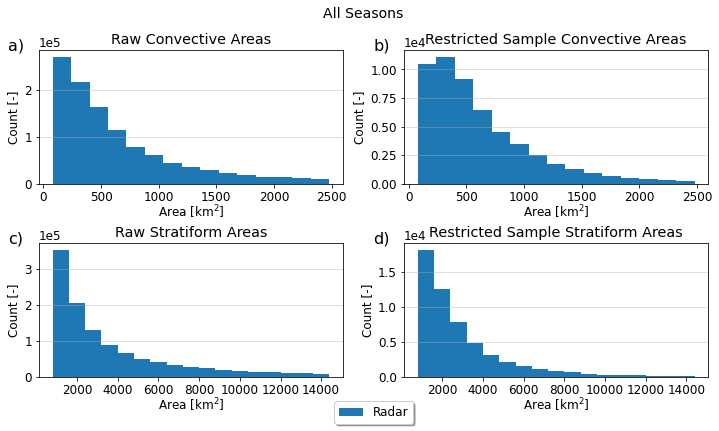

In [11]:
bs.compare_all_sizes(all_radar, fig_dir, suff)

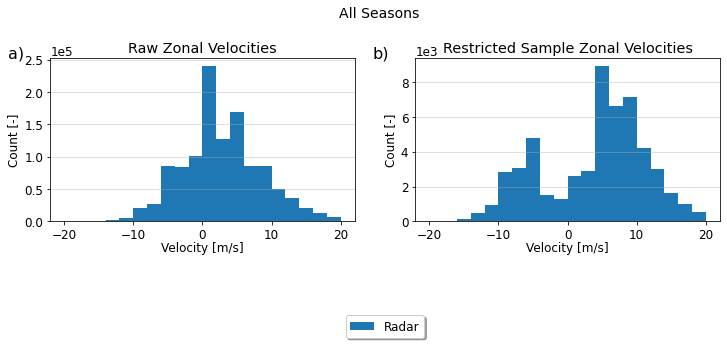

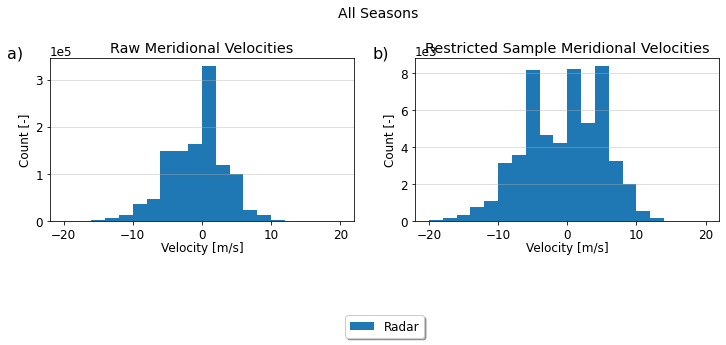

In [12]:
bs.plot_all_velocities(all_radar, fig_dir, suff)

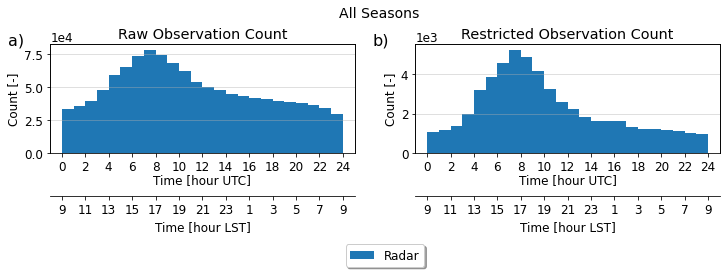

In [13]:
bs.plot_all_diurnal(all_radar, fig_dir, suff)

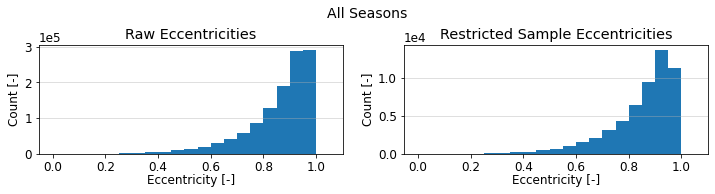

In [14]:
bs.plot_all_eccentricities(all_radar, fig_dir, suff)

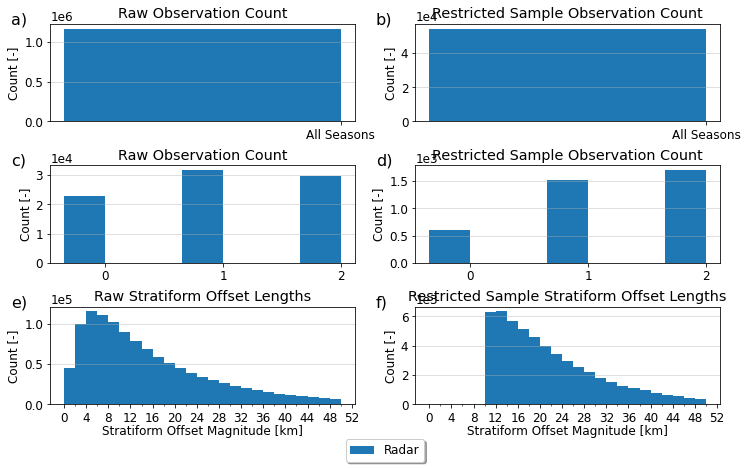

In [15]:
bs.plot_regional_seasonal_and_so(all_obs_regional, all_radar, fig_dir, suff)

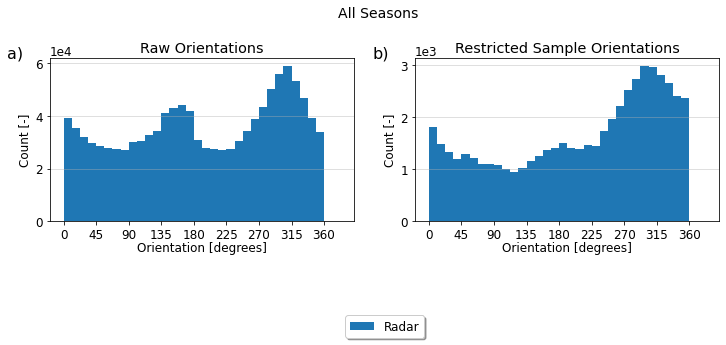

In [16]:
bs.plot_all_orientations(all_radar, fig_dir, suff)

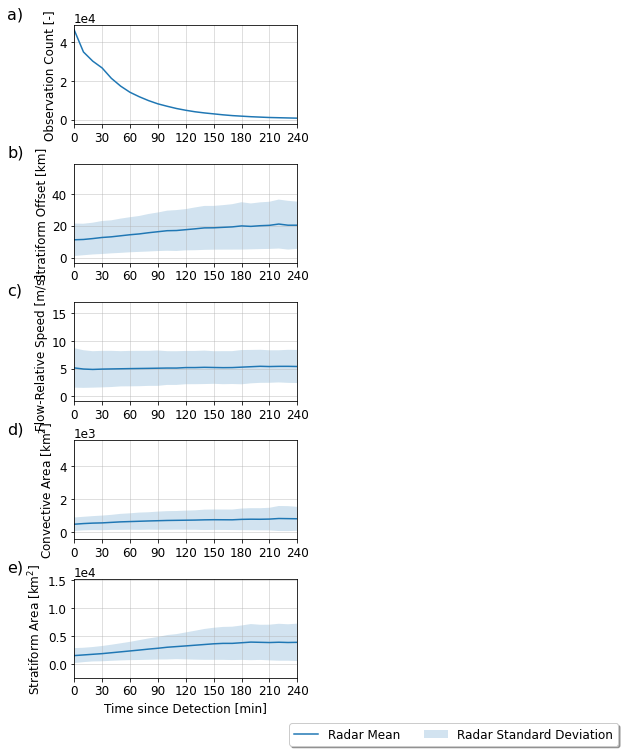

In [17]:
bs.plot_all_time_series(time_series_radar, fig_dir, suff)

Radar 42, year 2020.
Calculating system tracks.
Restricting to hour UTC < 12
Radar 42, year 2021.
Calculating system tracks.
Restricting to hour UTC < 12
Radar 63, year 2020.
Calculating system tracks.
Restricting to hour UTC < 12
Radar 63, year 2021.
Calculating system tracks.
Restricting to hour UTC < 12
Radar 77, year 2020.
Calculating system tracks.
Restricting to hour UTC < 12
Radar 77, year 2021.
Calculating system tracks.
Restricting to hour UTC < 12
Radar 42, year 2020.
Calculating system tracks.
Restricting to hour UTC < 12
Radar 42, year 2021.
Calculating system tracks.
Restricting to hour UTC < 12
Radar 63, year 2020.
Calculating system tracks.
Restricting to hour UTC < 12
Radar 63, year 2021.
Calculating system tracks.
Restricting to hour UTC < 12
Radar 77, year 2020.
Calculating system tracks.
Restricting to hour UTC < 12
Radar 77, year 2021.
Calculating system tracks.
Restricting to hour UTC < 12
Radar 42, year 2020.
Calculating system tracks.
Restricting to hour UTC < 12

Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Radar 63, year 2020.
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Radar 63, year 2021.
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calcul

Calculating system tracks.
Restricting to hour UTC < 12
No included observations.
Calculating system tracks.
Restricting to hour UTC < 12
No included observations.
Calculating system tracks.
Restricting to hour UTC < 12
No included observations.
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
No included observations.
Calculating system tracks.
Restricting to hour UTC < 12
No included observations.
Radar 63, year 2020.
Calculating system tracks.
Restricting to hour UTC < 12
No included observations.
Calculating system tracks.
Restricting to hour UTC < 12
No included observations.
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
No included observations.
Calculating system tracks.
Restricting to h

Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Radar 63, year 2020.
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Radar 63, year 2021.
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restri

Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Radar 77, year 2020.
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
No included observations.
Radar 77, year 2021.
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricti

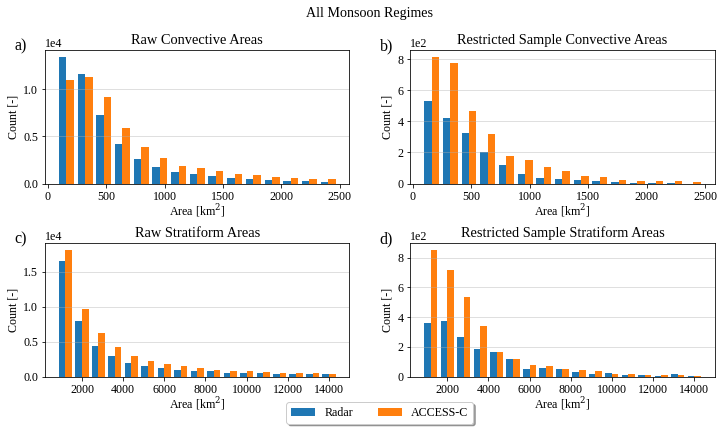

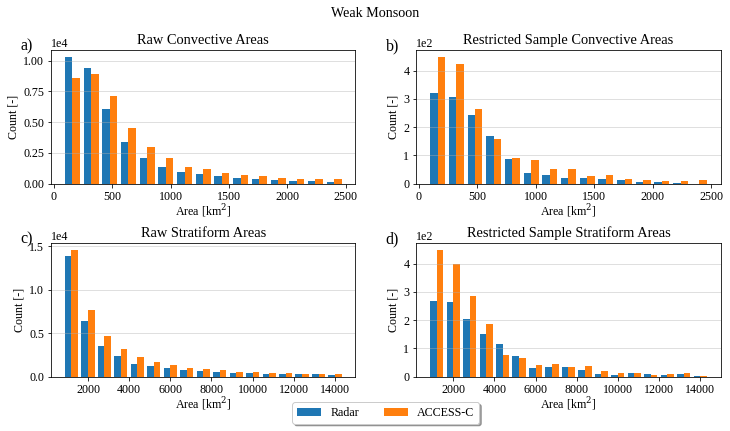

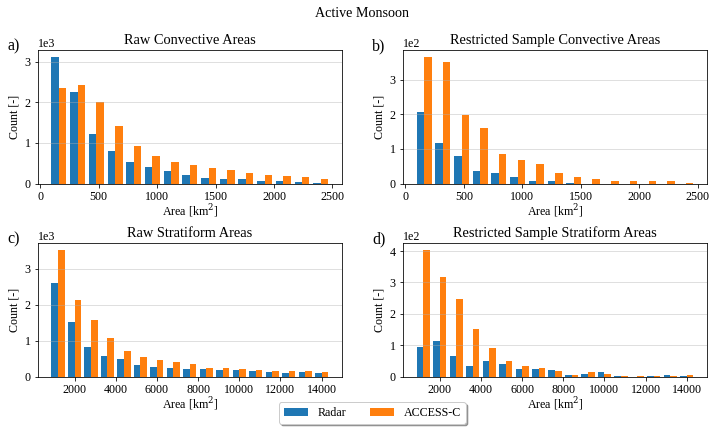

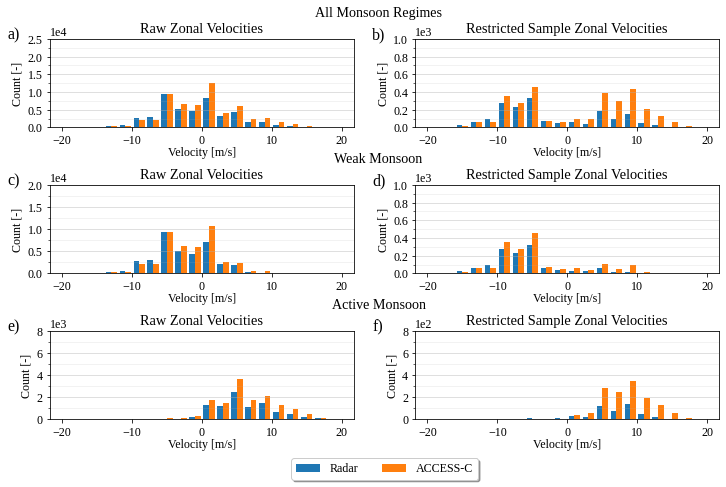

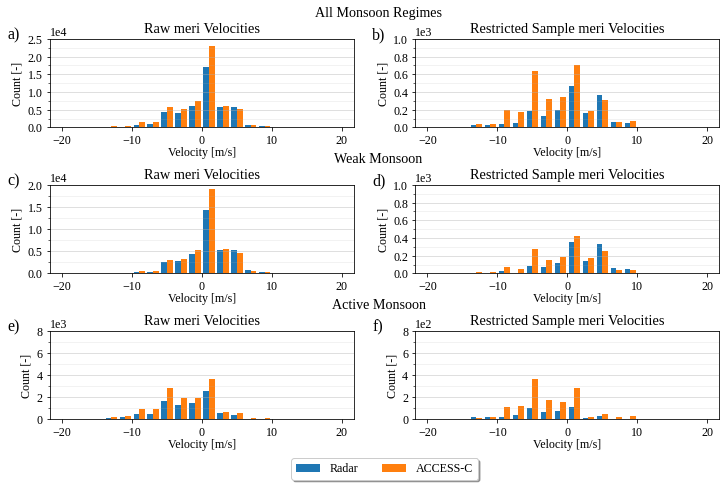

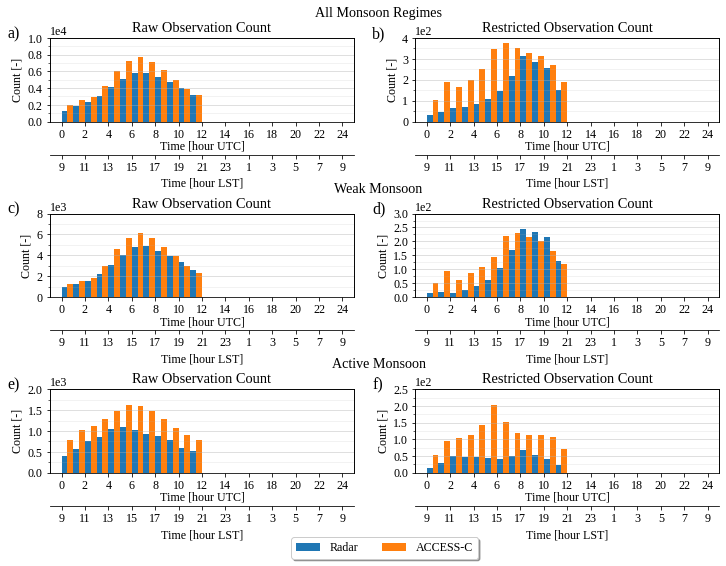

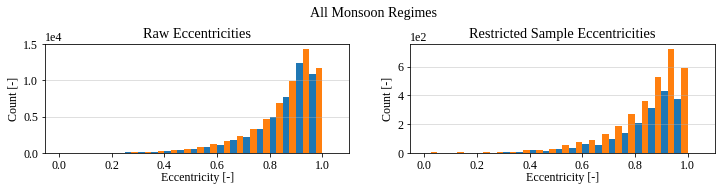

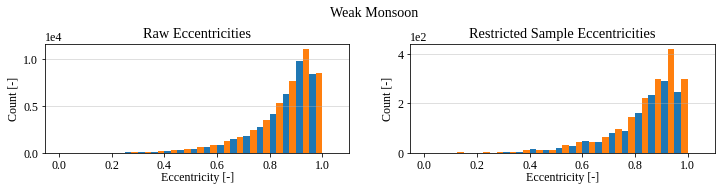

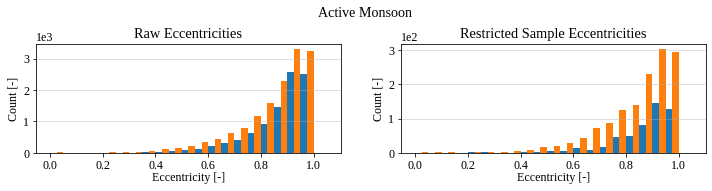

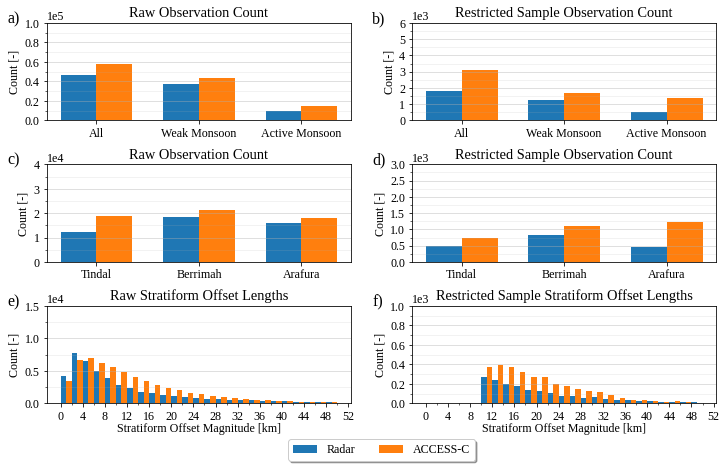

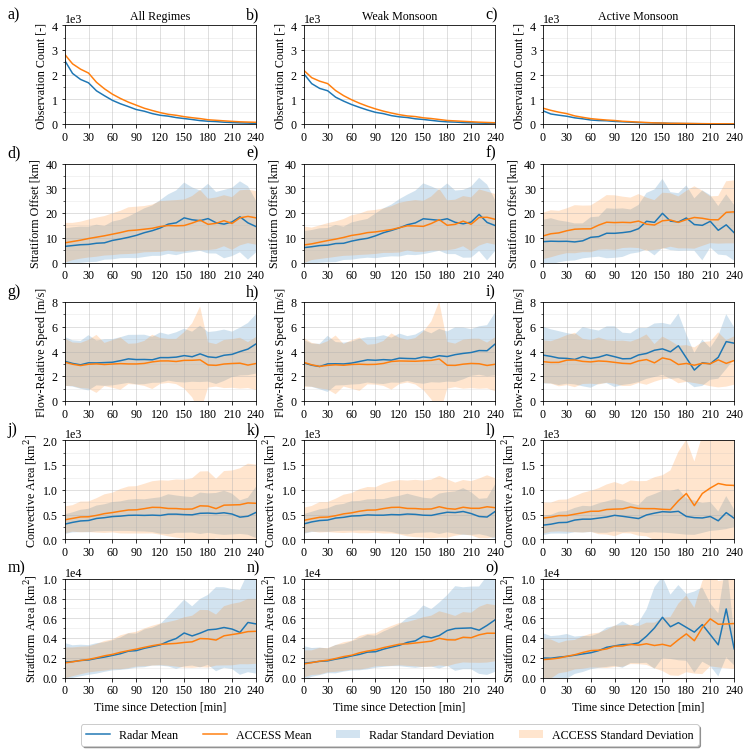

In [11]:
save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/ACCESS_radar_base/'
save_dir_alt = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/ACCESS_radar_morning_only/'
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/ACCESS_radar_morning_only/'
suff = fig_dir.split('/')[-2][13:]

if not os.path.exists(save_dir_alt):
    os.makedirs(save_dir)
    print('Creating new directory.')

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print('Creating new directory.')

all_ACCESS = bs.get_all_and_QC_ACCESS_stats(
    save_dir, class_thresh=None, 
    excl_thresh=None, exclusions=None, morning_only=True)
all_radar = bs.get_all_and_QC_radar_stats(
    save_dir, class_thresh=None, morning_only=True,
    excl_thresh=None, exclusions=None)
time_series_all = bs.get_all_time_series(
    save_dir, class_thresh=None, 
    excl_thresh=None, exclusions=None, morning_only=True)
all_obs_regional = bs.get_all_regional(
    save_dir, class_thresh=None, excl_thresh=None,
    exclusions=None, morning_only=True)

with open(save_dir_alt + '/ACCESS_bs.pkl', 'wb') as f:
    pickle.dump(all_ACCESS, f)
with open(save_dir_alt + '/radar_bs.pkl', 'wb') as f:
    pickle.dump(all_radar, f)
with open(save_dir_alt + '/time_series_bs.pkl', 'wb') as f:
    pickle.dump(time_series_all, f)
with open(save_dir_alt + '/regional_bs.pkl', 'wb') as f:
    pickle.dump(all_obs_regional, f)

[
    all_obs_radar, QC_obs_radar, all_obs_weak_radar, QC_obs_weak_radar,
    all_obs_active_radar, QC_obs_active_radar] = all_radar

[
    all_obs_ACCESS, QC_obs_ACCESS, all_obs_weak_ACCESS, QC_obs_weak_ACCESS,
    all_obs_active_ACCESS, QC_obs_active_ACCESS] = all_ACCESS

[
    time_series_radar, time_series_weak_radar, time_series_active_radar,
    time_series_ACCESS, time_series_weak_ACCESS, time_series_active_ACCESS] = time_series_all

[
    all_obs_ACCESS_42, QC_obs_ACCESS_42, all_obs_ACCESS_63, QC_obs_ACCESS_63,
    all_obs_ACCESS_77, QC_obs_ACCESS_77, all_obs_radar_42, QC_obs_radar_42, 
    all_obs_radar_63, QC_obs_radar_63, all_obs_radar_77, QC_obs_radar_77] = all_obs_regional

bs.compare_all_sizes(all_radar, all_ACCESS, fig_dir, suff)
bs.plot_all_velocities(all_radar, all_ACCESS, fig_dir, suff)
bs.plot_all_diurnal(all_radar, all_ACCESS, fig_dir, suff)
bs.plot_all_eccentricities(all_radar, all_ACCESS, fig_dir, suff)
bs.plot_regional_seasonal_and_so(all_obs_regional, all_radar, all_ACCESS, fig_dir, suff)
bs.plot_all_time_series(time_series_all, fig_dir, suff)

In [62]:
test_names += ['morning_only']

In [170]:
save_dir_alt = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/ACCESS_radar_base/'

with open(save_dir_alt + 'ACCESS_bs.pkl', 'rb') as f:
    all_ACCESS = pickle.load(f)

with open(save_dir_alt + 'radar_bs.pkl', 'rb') as f:
    all_radar = pickle.load(f)

In [171]:
aa = all_ACCESS[0][3]

In [172]:
bb = all_radar[0][3]

In [173]:
aa/bb

1.2722769575066182

In [108]:
large_vel_radar_raw = []
large_vel_radar_res = []
large_vel_ACCESS_raw = []
large_vel_ACCESS_res = []

orientation_radar_raw = []
orientation_radar_res = []
orientation_ACCESS_raw = []
orientation_ACCESS_res = []

for i in range(len(test_names)):
    
    print('Getting test {}.'.format(test_names[i]))

    save_dir_alt = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/ACCESS_radar_' + test_names[i] + '/'

    with open(save_dir_alt + 'ACCESS_bs.pkl', 'rb') as f:
        all_ACCESS = pickle.load(f)

    with open(save_dir_alt + 'radar_bs.pkl', 'rb') as f:
        all_radar = pickle.load(f)

    [
        all_obs_radar, QC_obs_radar, all_obs_weak_radar, QC_obs_weak_radar,
        all_obs_active_radar, QC_obs_active_radar] = all_radar

    [
        all_obs_ACCESS, QC_obs_ACCESS, all_obs_weak_ACCESS, QC_obs_weak_ACCESS,
        all_obs_active_ACCESS, QC_obs_active_ACCESS] = all_ACCESS

    vel_radar_all = np.array(all_obs_active_radar[5])
    vel_ACCESS_all = np.array(all_obs_active_ACCESS[5])

    vel_radar_QC = np.array(QC_obs_active_radar[5])
    vel_ACCESS_QC = np.array(QC_obs_active_ACCESS[5])
    
    ori_radar_all = np.array(all_obs_active_radar[7])
    ori_ACCESS_all = np.array(all_obs_active_ACCESS[7])

    ori_radar_QC = np.array(QC_obs_active_radar[7])
    ori_ACCESS_QC = np.array(QC_obs_active_ACCESS[7])

    large_vel_radar_raw.append(
        len(vel_radar_all[vel_radar_all > 12])/len(vel_radar_all))
    large_vel_radar_res.append(
        len(vel_radar_QC[vel_radar_QC > 12])/len(vel_radar_QC))
    large_vel_ACCESS_raw.append(
        len(vel_ACCESS_all[vel_ACCESS_all > 12])/len(vel_ACCESS_all))
    large_vel_ACCESS_res.append(
        len(vel_ACCESS_QC[vel_ACCESS_QC > 12])/len(vel_ACCESS_QC))
    
    cond1 = (ori_radar_all > 340)*(ori_radar_all < 20)
    cond1 += (ori_radar_all > 160)*(ori_radar_all < 200)
    
    cond2 = (ori_ACCESS_all > 340)*(ori_ACCESS_all < 20)
    cond2 += (ori_ACCESS_all > 160)*(ori_ACCESS_all < 200)
    
    cond3 = (ori_radar_QC > 340)*(ori_radar_QC < 20)
    cond3 += (ori_radar_QC > 160)*(ori_radar_QC < 200)
    
    cond4 = (ori_ACCESS_QC > 340)*(ori_ACCESS_QC < 20)
    cond4 += (ori_ACCESS_QC > 160)*(ori_ACCESS_QC < 200)
    
    orientation_radar_raw.append(
        len(ori_radar_all[cond1])/len(ori_radar_all))
    orientation_ACCESS_raw.append(
        len(ori_ACCESS_all[cond2])/len(ori_ACCESS_all))
    orientation_radar_res.append(
        len(ori_radar_QC[cond3])/len(ori_radar_QC))
    orientation_ACCESS_res.append(
        len(ori_ACCESS_QC[cond4])/len(ori_ACCESS_QC))

Getting test base.
Getting test ambient_swapped.
Getting test ambient_swapped_lower_wind_level.
Getting test lower_wind_level.
Getting test higher_wind_level.
Getting test no_steiner.
Getting test lower_ref_thresh.
Getting test higher_offset_thresh.
Getting test higher_border_thresh.
Getting test higher_area_thresh.
Getting test higher_conv_area_thresh.
Getting test linear_50.
Getting test linear_25.
Getting test combined_sensitivity.


In [105]:
all_obs_ACCESS[7]

[233.625,
 221.046,
 214.857,
 50.392,
 165.557,
 174.416,
 170.249,
 183.46,
 191.18,
 187.807,
 205.575,
 211.708,
 212.949,
 227.823,
 109.755,
 268.772,
 100.324,
 271.736,
 275.769,
 106.891,
 164.618,
 171.084,
 178.221,
 177.623,
 144.558,
 139.465,
 154.158,
 129.557,
 159.938,
 162.316,
 188.364,
 174.395,
 137.117,
 122.48,
 125.192,
 149.535,
 139.68,
 140.417,
 140.698,
 143.977,
 142.404,
 145.956,
 159.091,
 154.907,
 148.899,
 148.061,
 133.519,
 124.36,
 123.272,
 124.452,
 124.505,
 124.101,
 303.674,
 124.166,
 124.282,
 124.643,
 124.059,
 123.695,
 124.474,
 124.521,
 123.5,
 123.528,
 126.372,
 156.309,
 158.231,
 154.618,
 154.289,
 154.458,
 153.986,
 154.601,
 155.207,
 154.915,
 153.849,
 153.614,
 148.304,
 148.455,
 156.541,
 244.563,
 199.41,
 241.473,
 303.484,
 292.966,
 117.656,
 294.704,
 296.099,
 109.333,
 291.124,
 183.471,
 291.875,
 166.119,
 291.593,
 180.463,
 288.506,
 331.64,
 288.617,
 125.106,
 285.151,
 286.467,
 285.238,
 284.537,
 288.19,
 

In [107]:
True*True

1

In [96]:
large_vel_radar_raw[0]

0.07054593004249755

In [97]:
large_vel_ACCESS_raw[0]

0.11211092478219968

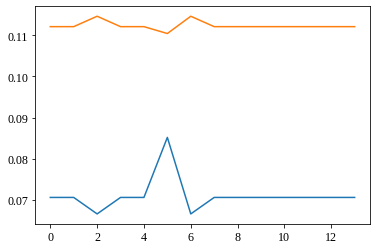

In [109]:
plt.plot(np.array(large_vel_radar_raw))
plt.plot(np.array(large_vel_ACCESS_raw))

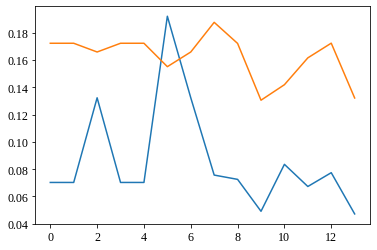

In [174]:
plt.plot(np.array(large_vel_radar_res))
plt.plot(np.array(large_vel_ACCESS_res))

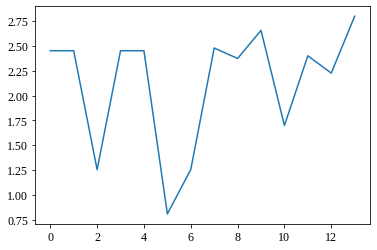

In [175]:
plt.plot(np.array(large_vel_ACCESS_res)/np.array(large_vel_radar_res))

In [132]:
max(np.array(large_vel_radar_raw)-np.array(large_vel_ACCESS_raw))

-0.025285999226158

In [126]:
print(orientation_radar_raw[5])
print(orientation_ACCESS_raw[5])

0.13898080741230973
0.22336535179677214


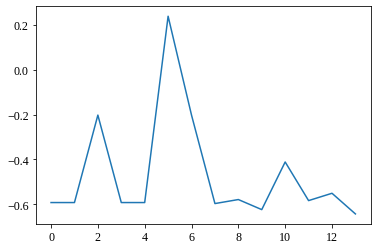

In [134]:
plt.plot((np.array(large_vel_radar_res)-np.array(large_vel_ACCESS_res))/np.array(large_vel_ACCESS_res))

In [128]:
min(np.array(large_vel_radar_res)-np.array(large_vel_ACCESS_res))

-0.11186710324287327

In [121]:
cond = np.arange(len(large_vel_radar_res))!=5

In [125]:
print(min(np.array(large_vel_radar_res)[cond]), max(np.array(large_vel_radar_res)[cond]))
print(min(np.array(large_vel_ACCESS_res)[cond]), max(np.array(large_vel_ACCESS_res)[cond]))

0.04722222222222222 0.13227513227513227
0.13050847457627118 0.18754277891854895


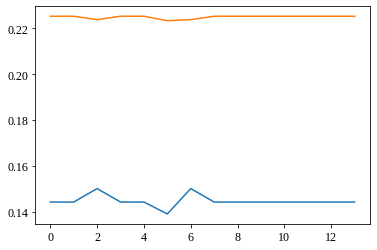

In [112]:
plt.plot(np.array(orientation_radar_raw))
plt.plot(np.array(orientation_ACCESS_raw))

In [116]:
print(orientation_radar_raw[0])
print(orientation_ACCESS_raw[0])

0.14416475972540047
0.22532618921019265


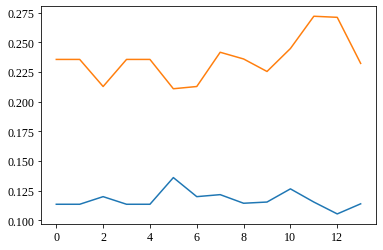

In [113]:
plt.plot(np.array(orientation_radar_res))
plt.plot(np.array(orientation_ACCESS_res))

In [118]:
print(min(orientation_radar_res), max(orientation_radar_res))
print(min(orientation_ACCESS_res), max(orientation_ACCESS_res))

0.1053763440860215 0.136
0.2108641975308642 0.27197149643705465


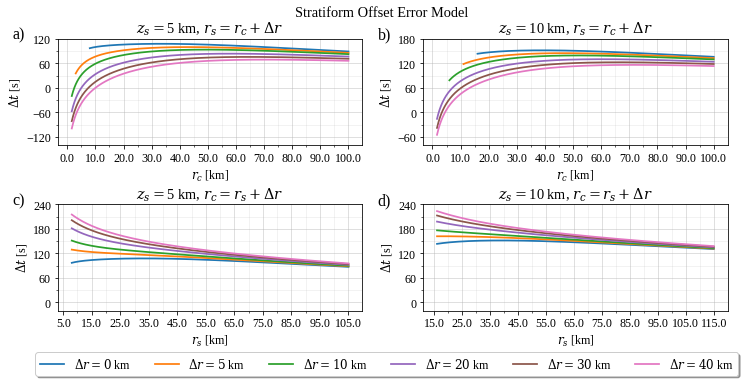

In [304]:
fig, ax = plt.subplots(2, 2, figsize=(12, 5))

bs.gen_error_model_plot(
    z_s=5000, fig=fig, ax=ax.flatten()[0], t_min=-120, t_max=120, 
    r_min=0, r_max=100e3, dr=10e3)
bs.gen_error_model_plot(
    z_s=10000, fig=fig, ax=ax.flatten()[1], t_min=-60, t_max=180, 
    r_min=0, r_max=100e3, dr=10e3)
bs.gen_error_model_plot(
    z_s=5000, fig=fig, ax=ax.flatten()[2], 
    closest='stratiform', t_max=240, r_min=5e3, r_max=105e3, dr=10e3)
bs.gen_error_model_plot(
    z_s=10000, fig=fig, ax=ax.flatten()[3], closest='stratiform', 
    t_max=240, r_min=15e3, r_max=115e3, dr=10e3)

# lines, labels = ax[0].get_legend_handles_labels()
# lines = [lines[i] for i in [0, 3, 1, 4, 2]]
# labels = [labels[i] for i in [0, 3, 1, 4, 2]]

ax.flatten()[2].legend(
    loc='lower center',
    bbox_to_anchor=(1.08, -.67),
    ncol=6, fancybox=True, shadow=True)

plt.subplots_adjust(hspace=.56)

plt.suptitle('Stratiform Offset Error Model', y=.97)

cl.make_subplot_labels(ax.flatten(), x_shift=-.15)

plt.savefig(
    fig_dir + '/error_model.png',
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

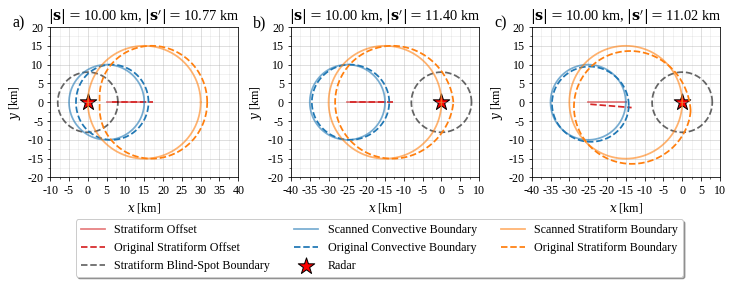

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

z_s = 5e3

# row 1
bs.plot_deformation(
    fig=fig, ax=ax[0], u=-10, v=0, strat_centroid_x=15e3, 
    conv_centroid_x=5e3, 
    conv_radius=10e3, strat_radius=15e3, tau=252, 
    extent=[-10e3, 40e3, -20e3, 20e3], dx=5e3, z_s=z_s)

bs.plot_deformation(
    fig=fig, ax=ax[1], u=-10, v=0, strat_centroid_x=-15e3, 
    conv_centroid_x=-25e3, conv_radius=10e3, strat_radius=15e3, 
    tau=252, extent=[-40e3, 10e3, -20e3, 20e3], dx=5e3, z_s=z_s)

bs.plot_deformation(
    fig=fig, ax=ax[2], u=-np.sqrt(1/2)*10, v=np.sqrt(1/2)*10, 
    strat_centroid_x=-15e3, conv_centroid_x=-25e3, conv_radius=10e3, 
    strat_radius=15e3, tau=252, extent=[-40e3, 10e3, -20e3, 20e3], 
    dx=5e3, z_s=z_s)

for i in range(len(ax.flatten())):
    ax.flatten()[i].set_aspect('equal')
    
lines, labels = ax[0].get_legend_handles_labels()
lines = [lines[i] for i in [0, 1, 2, 3, 4, 7, 5, 6]]
labels = [labels[i] for i in [0, 1, 2, 3, 4, 7, 5, 6]]

ax[0].legend(
    lines, labels,
    loc='lower center',
    bbox_to_anchor=(1.75, -.7),
    ncol=3, fancybox=True, shadow=True)

cl.make_subplot_labels(ax.flatten(), x_shift=-.2)
plt.subplots_adjust(wspace=.28)

plt.savefig(
    fig_dir + '/deformation.png',
    dpi=200, facecolor='w', edgecolor='white', 
    bbox_inches='tight')

In [15]:
x_range = np.arange(-100e3, 101e3, 1e3)
conv_radius = 10e3
strat_radius = 15e3

so_list = [10e3, 10e3, 10e3, 30e3, 10e3, 10e3]
u_list = [-10, -10, -np.sqrt(1/2)*10, -10, -10, -10]
v_list = [0, 0, np.sqrt(1/2)*10, 0, 0, 0]
conv_centroid_y = [0, 20e3, 0, 0, 0, 0]
strat_centroid_y = [0, 20e3, 0, 0, 0, 0]
conv_radius = [10e3, 10e3, 10e3, 10e3, 20e3, 10e3]
strat_radius = [15e3, 15e3, 15e3, 15e3, 15e3, 30e3]

labels = [
    r'Baseline', r'$y$ Displacement', r'Non-Parallel',
    r'$|\mathrm{\mathbf{s}}|=$ 30 km', r'Larger Convective Area', 
    r'Larger Stratiform Area']

In [16]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors = [colors[i] for i in [0, 1, 2, 4, 5, 6]]

In [17]:
offsets = [np.zeros(len(x_range)) for i in range(len(so_list))]

for k in range(len(so_list)):
    for i in range(len(x_range)):
        offset = bs.plot_deformation(
            u=u_list[k], v=v_list[k], 
            strat_centroid_x=x_range[i], 
            conv_centroid_x=(x_range[i]+so_list[k]),
            conv_radius=conv_radius[k], strat_radius=strat_radius[k],
            conv_centroid_y=conv_centroid_y[k],
            strat_centroid_y=strat_centroid_y[k],
            tau=300, plot=False)
        offsets[k][i] = offset
        plt.close('all')

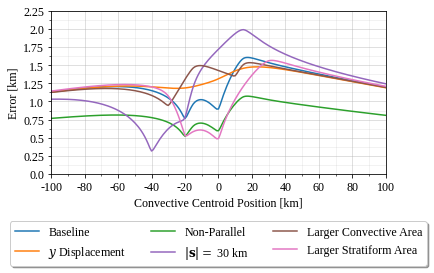

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

# for so in list(set(so_list))[:-1]:
#     ax.plot(
#         x_range, so*np.ones_like(x_range),  '--', color='grey')
# ax.plot(
#     x_range, np.zeros_like(x_range),  '--', color='grey')

extent = [-100e3, 100e3, 0, 2.25e3]
dx = 20e3
dy = .25e3

for k in range(len(so_list)):

    ax.plot(
        x_range, so_list[k]-offsets[k], color=colors[k], label=labels[k])

ax.set_xlim([extent[0], extent[1]])
ax.set_ylim([extent[2], extent[3]])
ax.set_xticks(np.arange(extent[0], extent[1]+dx, dx))
ax.set_xticks(
    np.arange(extent[0], extent[1]+dx/2, dx/2), minor=True)
ax.set_xticklabels(
    (np.arange(extent[0], extent[1]+dx, dx)/1e3).astype(int))
ax.set_yticks(np.arange(extent[2], extent[3]+dy, dy))
ax.set_yticks(
    np.arange(extent[2], extent[3]+dy/2, dy/2), minor=True)
ax.set_yticklabels(
    (np.arange(extent[2], extent[3]+dy, dy)/1e3).round(2))

ax.grid(which='minor', alpha=0.2, axis='both')
ax.grid(which='major', alpha=0.5, axis='both')
ax.set_xlabel(r'Convective Centroid Position [km]')
ax.set_ylabel(r"Error [km]")
    
ax.legend(
    loc='lower center',
    bbox_to_anchor=(.5, -.6),
    ncol=3, fancybox=True, shadow=True)

plt.savefig(
    fig_dir + '/so_error.png',
    dpi=200, facecolor='w', edgecolor='white', 
    bbox_inches='tight')

In [107]:
ACCESS_dicts = td.shear_versus_orientation_ACCESS()

Getting data for radar 42, year 2020.
Getting data for radar 63, year 2020.
Getting data for radar 77, year 2020.
Getting data for radar 42, year 2021.
Getting data for radar 63, year 2021.
Getting data for radar 77, year 2021.


In [108]:
radar_dicts = td.shear_versus_orientation_radar()

Getting data for radar 42, year 2020, month 10.
Getting data for radar 42, year 2020, month 11.
Getting data for radar 42, year 2020, month 12.
Getting data for radar 42, year 2021, month 1.
Getting data for radar 42, year 2021, month 2.
Getting data for radar 42, year 2021, month 3.
Getting data for radar 42, year 2021, month 4.
No systems.
Getting data for radar 63, year 2020, month 10.
Getting data for radar 63, year 2020, month 11.
Getting data for radar 63, year 2020, month 12.
Getting data for radar 63, year 2021, month 1.
Getting data for radar 63, year 2021, month 2.
Getting data for radar 63, year 2021, month 3.
Getting data for radar 63, year 2021, month 4.
Getting data for radar 77, year 2020, month 10.
Getting data for radar 77, year 2020, month 11.
Getting data for radar 77, year 2020, month 12.
Getting data for radar 77, year 2021, month 1.
Getting data for radar 77, year 2021, month 2.
Getting data for radar 77, year 2021, month 3.
Getting data for radar 77, year 2021, m

[1.0, 1.0, 1.0, 1.0]

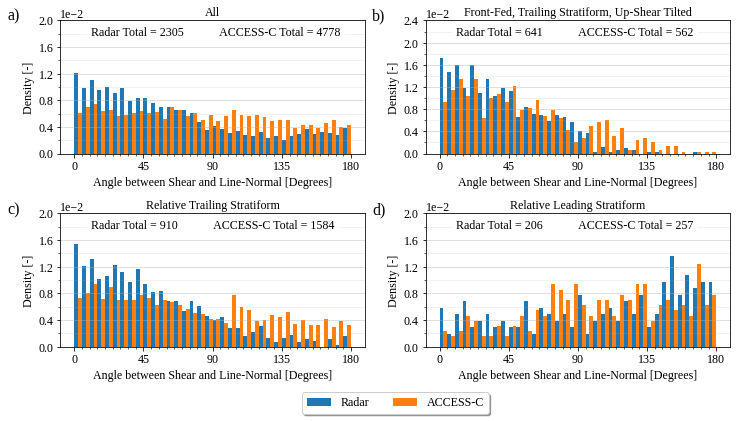

In [115]:
titles = [
    'All', 'Front-Fed, Trailing Stratiform, Up-Shear Tilted', 
    'Relative Trailing Stratiform', 'Relative Leading Stratiform']
td.shear_angle_versus_orientation_hist_compare(radar_dicts, ACCESS_dicts, titles=titles)

[1.0, 1.0, 1.0, 1.0]

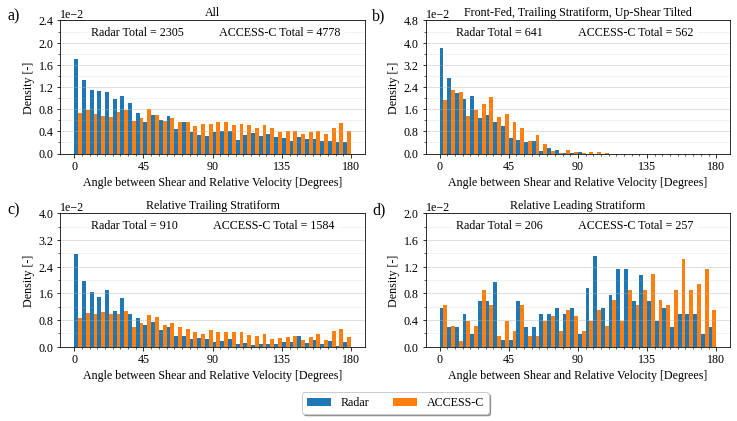

In [116]:
td.shear_angle_versus_propagation_hist_compare(radar_dicts, ACCESS_dicts, titles=titles)

In [23]:
all_excl_ACCESS = bs.count_ACCESS_exclusions(
    save_dir, regime=None, radars=radars, morning_only=morning_only)
all_excl_radar = bs.count_radar_exclusions(
    save_dir, regime=None, radars=radars, morning_only=morning_only)

weak_excl_ACCESS = bs.count_ACCESS_exclusions(
    save_dir, regime=1, radars=radars, morning_only=morning_only)
weak_excl_radar = bs.count_radar_exclusions(
    save_dir, regime=1, radars=radars, morning_only=morning_only)

active_excl_ACCESS = bs.count_ACCESS_exclusions(
    save_dir, regime=2, radars=radars, morning_only=morning_only)
active_excl_radar = bs.count_radar_exclusions(
    save_dir, regime=2, radars=radars, morning_only=morning_only)

TypeError: count_ACCESS_exclusions() got an unexpected keyword argument 'morning_only'

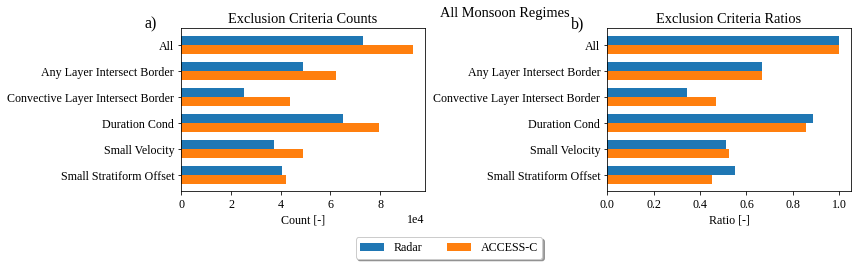

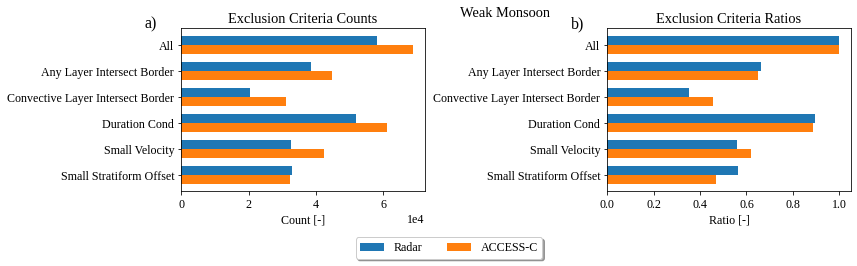

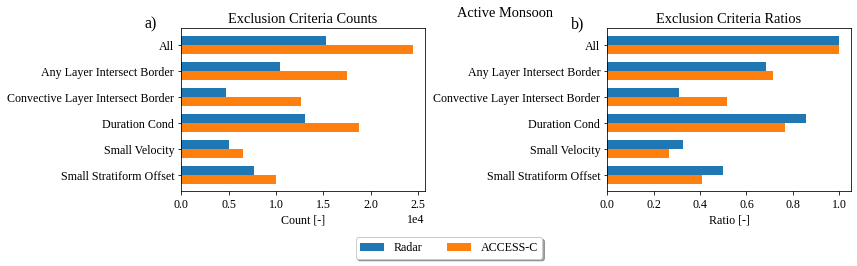

In [202]:
bs.compare_exclusions(all_excl_radar, all_excl_ACCESS, title='All Monsoon Regimes')
plt.savefig(
    fig_dir + 'excl_all_{}.png'.format(suff), dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')
bs.compare_exclusions(weak_excl_radar, weak_excl_ACCESS, title='Weak Monsoon')
plt.savefig(
    fig_dir + 'excl_weak_{}.png'.format(suff), dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')
bs.compare_exclusions(active_excl_radar, active_excl_ACCESS, title='Active Monsoon')
plt.savefig(
    fig_dir + 'excl_active_{}.png'.format(suff), dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')

In [2]:
import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [3]:
file_name = '/home/student.unimelb.edu.au/shorte1/Documents/radar_examples/77_20210101.pvol/77_20210101_000500.pvol.h5'
my_radar = pyart.aux_io.read_odim_h5(file_name, file_field_names=True)

In [12]:
time = my_radar.time['data']

In [13]:
elevation =  my_radar.elevation['data']

In [39]:
import matplotlib.pyplot as plt
import numpy as np

In [66]:
t

array([  0.,  33.,  64.,  86., 106., 127., 145., 163., 180., 198., 216.,
       234., 252.], dtype=float32)

In [42]:
elevation[2000]

4.7

In [77]:
el, ind = np.unique(elevation, return_index=True)
print(el, ind)

[ 0.5  0.8  1.4  2.4  3.5  4.7  6.   7.8 10.  13.  17.  23.  32. ] [   0  360  720 1080 1440 1800 2160 2520 2880 3240 3600 3960 4320]


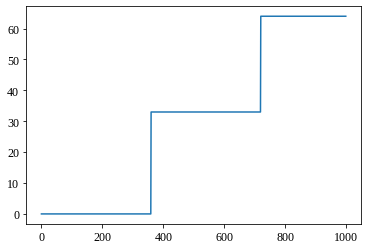

In [293]:
plt.plot(time[:1000])

In [294]:
time

array([  0.,   0.,   0., ..., 252., 252., 252.], dtype=float32)

In [291]:
el[-1]-el[-2]

9.0

In [292]:
t[-1]-t[-2]

18.0

In [232]:
# c = 62.5684116732685
c = 62.57
a = 31.5/np.sinh(252/c)
el_ap = a*np.sinh(t/c)+.5

In [288]:
a

1.1229544141076924

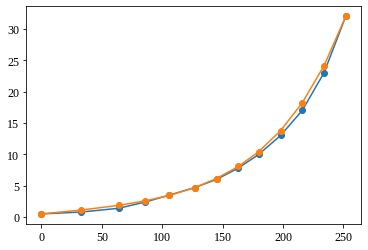

In [228]:
plt.plot(t, el, '-o')
# plt.plot(time, elevation, '-o')
# plt.plot(t, p(t))
# el_ap = np.sinh(t/61)+.5
plt.plot(t, el_ap, '-o')

In [219]:
el_ap

array([ 0.5      ,  0.8      ,  1.1998004,  1.6362213,  2.2203107,
        3.1303067,  4.2698827,  5.893951 ,  8.059732 , 11.303207 ,
       15.935074 , 22.550608 , 31.999998 ], dtype=float32)

In [224]:
el[5]

4.7

In [222]:
t[5]

127.0

In [193]:
t_ap = np.arcsinh((el-0.5))*61

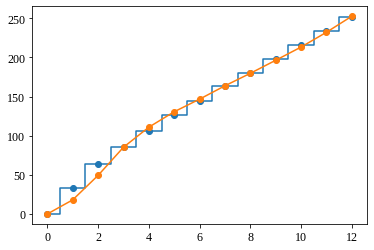

In [194]:
plt.step(t, '-o', where='mid')
plt.plot(t_ap, '-o')

In [195]:
np.max(np.abs(t[:-1]-t_ap[1:]))/252

0.09890965878236536

In [287]:
np.max(np.abs(el-el_ap))/32

0.037710726261138916

In [60]:
c = np.polyfit(t, el, 5)
# c[-1] = 0
p = np.poly1d(c)

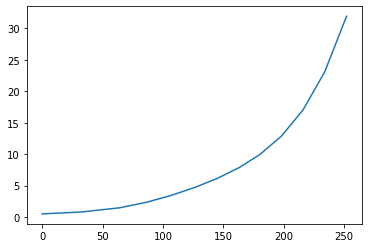

In [61]:
plt.plot(t, p(t))